
**Eye Disease Classification**

**Importing Liabraries**

In [1]:
import cv2
import os
from skimage.io import imread

import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import ConcatDataset, DataLoader
import torch.nn as nn
import torchvision.models as models

import albumentations as A
import imgaug.augmenters as iaa

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


**Preprocessing Images**

In [2]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Upload My Drive onto sys
FOLDERNAME = 'mini_project/dataset'
assert FOLDERNAME is not None, "[!] Enter the foldername."
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# Upload My Drive onto os
os.getcwd()
os.chdir('/content/drive/My Drive')

Mounted at /content/drive


 Printing Image Sizes for each Class

In [4]:
# Main Dataset Folder path
folder_path = '/content/drive/My Drive/mini_project/dataset'

# Subfolders
subfolders = ['cataract', 'diabetic_retinopathy', 'normal', 'glaucoma']

print('(Height, Width, Channels)')
print(70*'-')

# Iterate over each subfolder
for subdir in subfolders:
    class_folder = os.path.join(folder_path, subdir)
    files_path = os.listdir(class_folder)
    size = set()

    for fp in files_path:
        img = imread(os.path.join(class_folder, fp))
        size.add(img.shape)

    print(subdir + ':', size)


(Height, Width, Channels)
----------------------------------------------------------------------
cataract: {(512, 512, 3), (1728, 2592, 3), (1632, 2464, 3), (1224, 1848, 3), (256, 256, 3)}
diabetic_retinopathy: {(512, 512, 3)}
normal: {(512, 512, 3)}
glaucoma: {(512, 512, 3), (1728, 2592, 3), (1632, 2464, 3), (1224, 1848, 3), (256, 256, 3)}


The above output depicts that the images belonging to different classes have different dimensions hence,we will resize the images to 224x224x3 which is also the image dimensions in the ImageNet dataset that the ShuffleNet V2 architecture was trained upon.

 Resizing Images of every class to 224 x 224 x 3

In [6]:
names = ['cataract', 'glaucoma', 'normal', 'diabetic_retinopathy']

for name in names:

  # Image Folder Path and Output Folder Path
  folder_path = 'mini_project/dataset/' + name
  output_folder_path = '/content/drive/My Drive/mini_project/resize_dataset/' + name

  # Create the output folder if it doesn't exist
  if not os.path.exists(output_folder_path):
      os.makedirs(output_folder_path)

  # Loop through each image file in the folder
  for filename in os.listdir(folder_path):
      # Read the image
      image_path = os.path.join(folder_path, filename)
      image = cv2.imread(image_path)

      # Resize the image to 224x224
      resized_image = cv2.resize(image, (224, 224))

      # Save the resized image to the output folder
      output_path = os.path.join(output_folder_path, filename)
      cv2.imwrite(output_path, resized_image)

print("Resizing complete.")


Resizing complete.


 Printing Unique Sizes in New Dataset

In [7]:
# Main Dataset Folder path
folder_path = '/content/drive/My Drive/mini_project/resize_dataset'

# Subfolders
subfolders = ['cataract', 'diabetic_retinopathy', 'normal', 'glaucoma']

print('(Height, Width, Channels)')
print(70*'-')

# Iterate over each subfolder and print unique image sizes
for subdir in subfolders:
    class_folder = os.path.join(folder_path, subdir)
    files_path = os.listdir(class_folder)
    size = set()

    for fp in files_path:
        img = imread(os.path.join(class_folder, fp))
        size.add(img.shape)

    print(subdir + ':', size)

(Height, Width, Channels)
----------------------------------------------------------------------
cataract: {(224, 224, 3)}
diabetic_retinopathy: {(224, 224, 3)}
normal: {(224, 224, 3)}
glaucoma: {(224, 224, 3)}


As we can see now, all images have been resized to same size, 224 x 224 x 3. Hence now they can be used as input to ShuffleNet V2.

Analysis of Distribution of Images in each Class

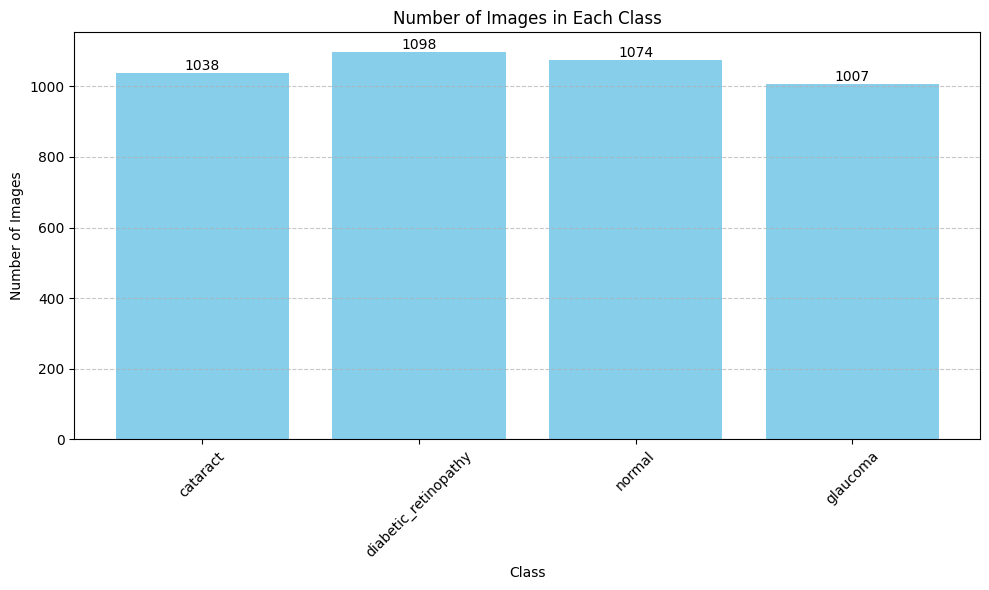

In [8]:
# Define Folder Path and list subfolders/classes
folder_path = '/content/drive/My Drive/mini_project/dataset'
subfolders = ['cataract', 'diabetic_retinopathy', 'normal', 'glaucoma']

# Store Image Counts for each Class
image_counts = []
annotations = []
for subdir in subfolders:
    class_folder = os.path.join(folder_path, subdir)
    files_path = os.listdir(class_folder)
    image_count = len(files_path)
    image_counts.append(image_count)
    annotations.append(str(image_count))

# Plot Bar Graph for Visualisation
plt.figure(figsize=(10, 6))
bars = plt.bar(subfolders, image_counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for bar, annotation in zip(bars, annotations):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), annotation,
             ha='center', va='bottom')
plt.tight_layout()
plt.show()


The dataset that we are working on is well balanced as depicted by the bar graph above. Each retinal disease class has roughly the same number of images, hence there is no bias towards any specific class.

**Train-Test Split of Images in Every Class**

 Perform Split

In [9]:
class PermuteChannels(object):
    def __call__(self, x):
        # Permute (H, W, C) to (C, H, W)
        return x.permute(1, 2, 0)

In [10]:
folder_path = '/content/drive/My Drive/mini_project/resize_dataset/'

#to tensor + change channel
transform = transforms.Compose([
    transforms.ToTensor(),
    #changed this og
#     PermuteChannels(),
])

# Extract Dataset from Folder Path
dataset = ImageFolder(root=folder_path, transform=transform)

#70-10-20
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64)
test_loader = DataLoader(test_set, batch_size=64)

 Visualise Training Data for each Class

Class: cataract


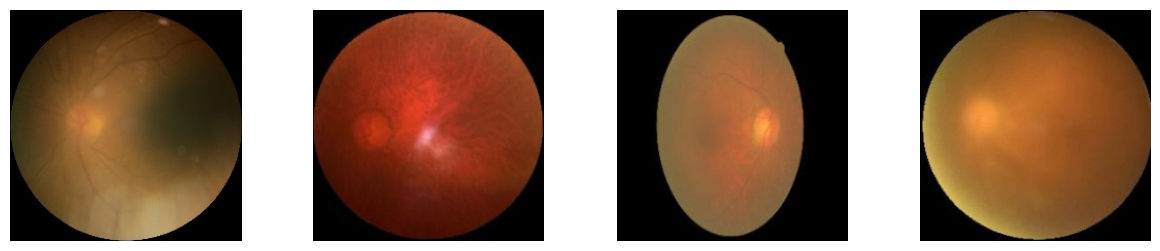

Class: diabetic_retinopathy


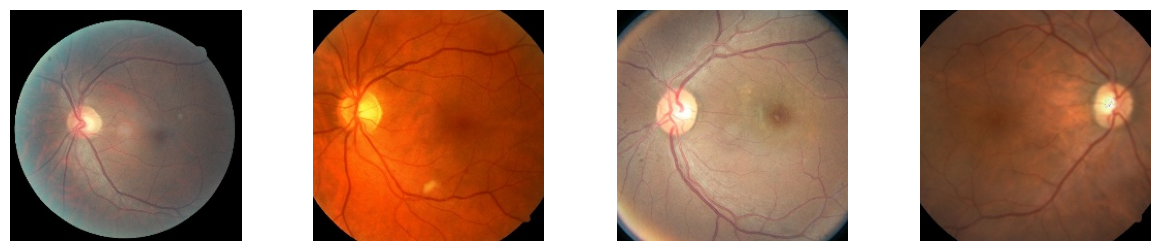

Class: glaucoma


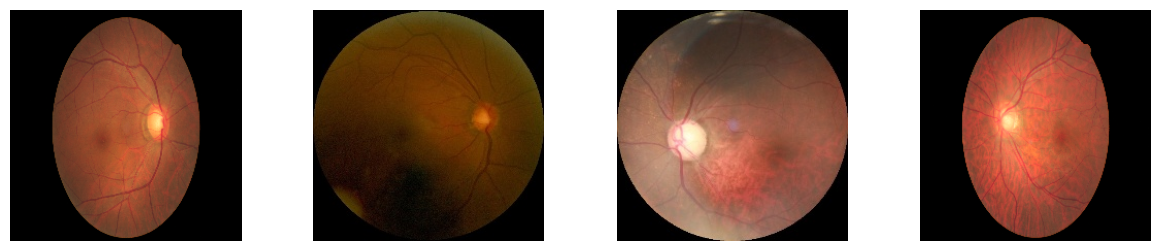

Class: normal


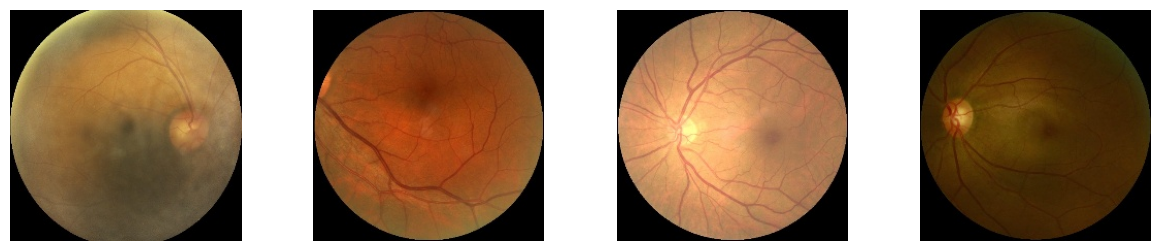

In [11]:
def display_images(loader, class_names, num_images_per_class):
    # Initialize a dictionary to store images for each class
    images_by_class = {class_name: [] for class_name in class_names}

    for images, labels in loader:
        for image, label in zip(images, labels):
            class_name = class_names[label.item()]
            if len(images_by_class[class_name]) < num_images_per_class:
                images_by_class[class_name].append(image)

    # Display images for each class
    for class_name, class_images in images_by_class.items():
        print(f"Class: {class_name}")
        plt.figure(figsize=(15, 3))
        for i in range(num_images_per_class):
            plt.subplot(1, num_images_per_class, i + 1)
            plt.imshow(class_images[i].numpy().transpose(1, 2, 0))
            plt.axis('off')
        plt.show()

class_names = dataset.classes

display_images(train_loader, class_names, num_images_per_class=4)

**Performing Data Augmentation**





 Define Augmentation for Each Class

In [12]:
 # Glaucoma Augmentation
glaucoma_augmentation = A.Compose([
    A.GridDistortion(p=1),
])

# Cataract Augmentation
cataract_augmentation = iaa.GaussianBlur(sigma=(0.0, 3.0))

# DR Augmentation
diabetic_retinopathy_augmentation = iaa.arithmetic.Dropout(p=(0.01, 0.1))

 Apply Data Augmentation

In [13]:
# Dictionary for each class
class_to_label = {
    'glaucoma': 2,
    'cataract': 0,
    'diabetic_retinopathy': 1,
    'normal': 3
}


batch_size = 64
train_dataset = train_loader.dataset

# List to collect Augmented Data
augmented_datasets = []

# Loop over each train Image and Augment it
for images, labels in train_loader:
    augmented_images = []
    augmented_labels = []
    for image, label in zip(images, labels):

        # Convert PyTorch tensor to NumPy array since the augmentation methods take numpy array as input
        image_np = image.numpy()

        # Extract Class Label and Name
        class_label = label.item()

        # Apply common augmentation (random rotation and horizontal flip)
        augmented_image = image_np

        # Apply Class Specific Augmentation
        if class_label == 2:
            # Glaucoma
            augmented_image = glaucoma_augmentation(image=augmented_image)['image']
        elif class_label == 0:
            # Cataract
            augmented_image = cataract_augmentation.augment_images(augmented_image)
        elif class_label == 1:
            # Diabetic Retinopathy
            augmented_image = diabetic_retinopathy_augmentation.augment_images(augmented_image)

        # Convert NumPy array to PyTorch tensor since stacking requires tensor input
        augmented_images.append(torch.tensor(augmented_image))

        # Add Augmented data to Augmented List
        augmented_labels.append(label)

    # Create a tensor from augmented_labels
    augmented_labels_tensor = torch.tensor(augmented_labels)

    # Create a TensorDataset from augmented_images and augmented_labels
    augmented_dataset = torch.utils.data.TensorDataset(torch.stack(augmented_images), augmented_labels_tensor)
    augmented_datasets.append(augmented_dataset)


# Concatenate the original training dataset with augmented datasets
combined_dataset = ConcatDataset([train_dataset] + augmented_datasets)

# Create a new DataLoader for the combined dataset
augmented_train_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

 Check New Data

In [14]:
print("Original training dataset size:", len(train_dataset))
print("Training dataset size after augmentation:", len(combined_dataset))

Original training dataset size: 2951
Training dataset size after augmentation: 5902


 Display Augmented Data

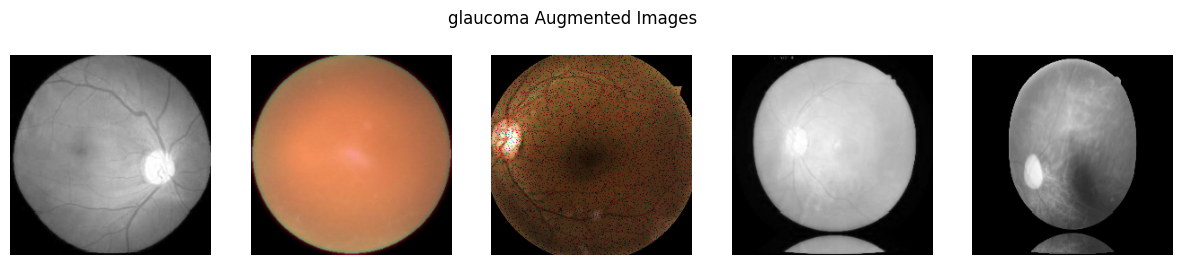

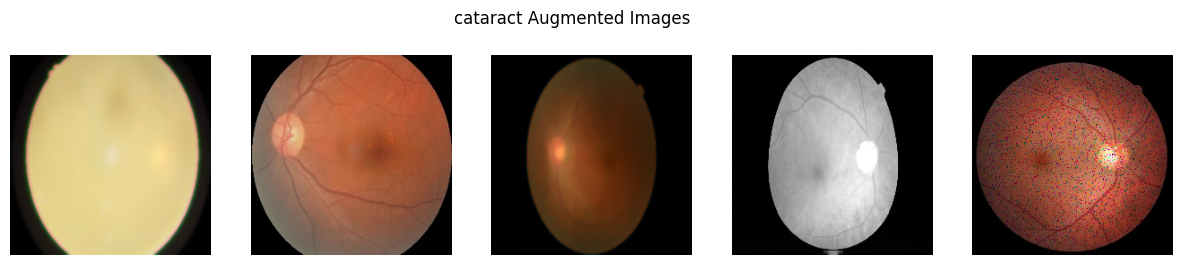

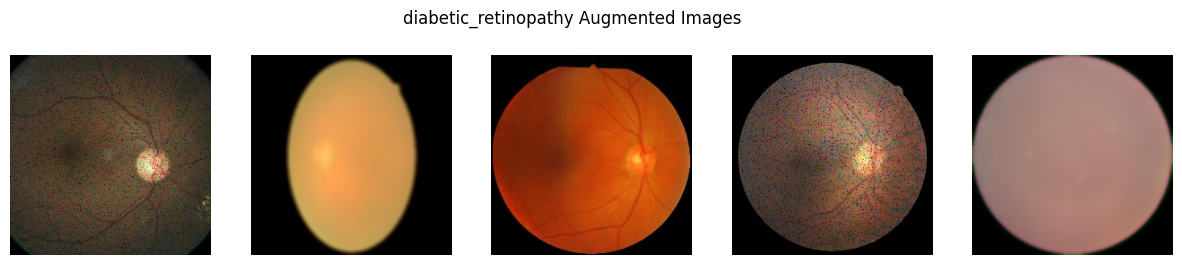

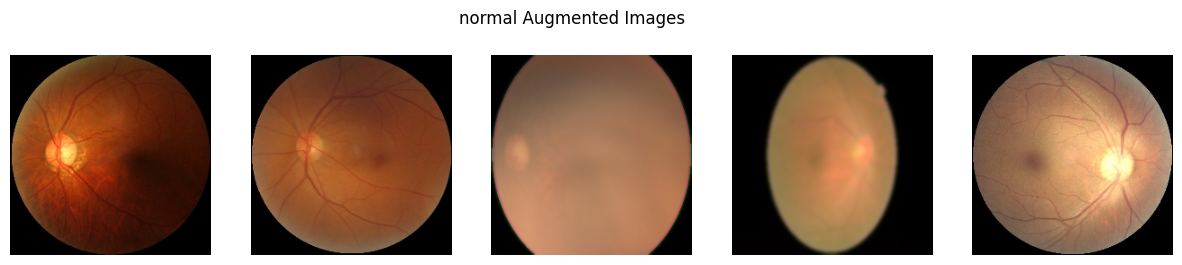

In [15]:
def display_images(images, class_name):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
    fig.suptitle(f"{class_name} Augmented Images")
    for i, image in enumerate(images):
        image_np = image.numpy()
        axes[i].imshow(image_np.transpose(1, 2, 0))
        axes[i].axis('off')
    plt.show()

for class_name in class_to_label.keys():
    class_label = class_to_label[class_name]

    # Filter augmented dataset for the current class
    class_dataset = [augmented_dataset for augmented_dataset in augmented_datasets if augmented_dataset.tensors[1][0] == class_label]

    count = 0
    if len(class_dataset) > 0:
        # Extract a batch of images from the dataset
        sample_images, sample_labels = next(iter(DataLoader(class_dataset[count], batch_size=5)))
        count+=1

        # Display the images
        display_images(sample_images, class_name)

**Designing Model**

Define Specialised ShuffleNetv2 Model

In [16]:
class CustomShuffleNet(nn.Module):

    def __init__(self, num_classes):

        super(CustomShuffleNet, self).__init__()
        # Load the pretrained ShuffleNetV2 model
        shufflenet = models.shufflenet_v2_x1_0(weights=True)

        # Freeze all the layers initially
        for param in shufflenet.parameters():
            param.requires_grad = False

        # Replace the last fully connected layer
        num_ftrs = shufflenet.fc.in_features
        shufflenet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
            nn.Softmax(dim=1)  # Add softmax activation for classification
        )

        self.shufflenet = shufflenet

    def forward(self, x):
        return self.shufflenet(x)

 Initialise Model

In [17]:
custom_shuffleNet = CustomShuffleNet(num_classes = 4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 79.9MB/s]


Training Loop

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_model(model, train_loader, valid_loader, num_epochs=50, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)


    criterion = nn.CrossEntropyLoss()

    # Define the optimizer
    optimizer = torch.optim.Adam(custom_shuffleNet.shufflenet.fc.parameters(), lr=0.001)

    train_losses = []
    valid_losses = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} (Train)'):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(valid_loader, desc=f'Epoch {epoch + 1}/{num_epochs} (Valid)'):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                valid_loss += loss.item() * inputs.size(0)

            valid_loss /= len(valid_loader.dataset)
            valid_losses.append(valid_loss)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

    return train_losses, valid_losses


num_epochs = 3000
train_losses, valid_losses = train_model(custom_shuffleNet, train_loader, val_loader, num_epochs=num_epochs, lr= 1e-5)


Epoch 1/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]


Epoch 1/3000, Train Loss: 1.2610, Valid Loss: 1.1492


Epoch 2/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


Epoch 2/3000, Train Loss: 1.0544, Valid Loss: 1.0087


Epoch 3/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 3/3000, Train Loss: 0.9702, Valid Loss: 0.9539


Epoch 4/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.33it/s]


Epoch 4/3000, Train Loss: 0.9234, Valid Loss: 0.9143


Epoch 5/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.88it/s]


Epoch 5/3000, Train Loss: 0.8966, Valid Loss: 0.9080


Epoch 6/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.92it/s]


Epoch 6/3000, Train Loss: 0.8832, Valid Loss: 0.9018


Epoch 7/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 7/3000, Train Loss: 0.8679, Valid Loss: 0.8996


Epoch 8/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch 8/3000, Train Loss: 0.8697, Valid Loss: 0.8955


Epoch 9/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.83it/s]


Epoch 9/3000, Train Loss: 0.8503, Valid Loss: 0.8762


Epoch 10/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 10/3000, Train Loss: 0.8534, Valid Loss: 0.8947


Epoch 11/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.97it/s]


Epoch 11/3000, Train Loss: 0.8436, Valid Loss: 0.8638


Epoch 12/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 12/3000, Train Loss: 0.8371, Valid Loss: 0.8702


Epoch 13/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 13/3000, Train Loss: 0.8469, Valid Loss: 0.8632


Epoch 14/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.32it/s]


Epoch 14/3000, Train Loss: 0.8447, Valid Loss: 0.8637


Epoch 15/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 15/3000, Train Loss: 0.8323, Valid Loss: 0.8653


Epoch 16/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 16/3000, Train Loss: 0.8408, Valid Loss: 0.8589


Epoch 17/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.08it/s]


Epoch 17/3000, Train Loss: 0.8192, Valid Loss: 0.8632


Epoch 18/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Epoch 18/3000, Train Loss: 0.8283, Valid Loss: 0.8599


Epoch 19/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.91it/s]


Epoch 19/3000, Train Loss: 0.8247, Valid Loss: 0.8686


Epoch 20/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 20/3000, Train Loss: 0.8220, Valid Loss: 0.8562


Epoch 21/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.93it/s]


Epoch 21/3000, Train Loss: 0.8207, Valid Loss: 0.8594


Epoch 22/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 22/3000, Train Loss: 0.8178, Valid Loss: 0.8603


Epoch 23/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Epoch 23/3000, Train Loss: 0.8252, Valid Loss: 0.8630


Epoch 24/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.75it/s]


Epoch 24/3000, Train Loss: 0.8129, Valid Loss: 0.8610


Epoch 25/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.62it/s]


Epoch 25/3000, Train Loss: 0.8122, Valid Loss: 0.8583


Epoch 26/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.08it/s]


Epoch 26/3000, Train Loss: 0.8053, Valid Loss: 0.8592


Epoch 27/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.93it/s]


Epoch 27/3000, Train Loss: 0.8034, Valid Loss: 0.8609


Epoch 28/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch 28/3000, Train Loss: 0.8081, Valid Loss: 0.8543


Epoch 29/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch 29/3000, Train Loss: 0.8043, Valid Loss: 0.8530


Epoch 30/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 30/3000, Train Loss: 0.8060, Valid Loss: 0.8598


Epoch 31/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 31/3000, Train Loss: 0.8000, Valid Loss: 0.8606


Epoch 32/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.91it/s]


Epoch 32/3000, Train Loss: 0.7995, Valid Loss: 0.8642


Epoch 33/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.19it/s]


Epoch 33/3000, Train Loss: 0.8113, Valid Loss: 0.8567


Epoch 34/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.75it/s]


Epoch 34/3000, Train Loss: 0.8016, Valid Loss: 0.8644


Epoch 35/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 35/3000, Train Loss: 0.7980, Valid Loss: 0.8580


Epoch 36/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.33it/s]


Epoch 36/3000, Train Loss: 0.7955, Valid Loss: 0.8586


Epoch 37/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 37/3000, Train Loss: 0.8041, Valid Loss: 0.8531


Epoch 38/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.45it/s]


Epoch 38/3000, Train Loss: 0.7977, Valid Loss: 0.8703


Epoch 39/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.11it/s]


Epoch 39/3000, Train Loss: 0.8065, Valid Loss: 0.8566


Epoch 40/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.00it/s]


Epoch 40/3000, Train Loss: 0.8037, Valid Loss: 0.8509


Epoch 41/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.12it/s]


Epoch 41/3000, Train Loss: 0.8070, Valid Loss: 0.8573


Epoch 42/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.35it/s]


Epoch 42/3000, Train Loss: 0.7931, Valid Loss: 0.8476


Epoch 43/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.88it/s]


Epoch 43/3000, Train Loss: 0.8002, Valid Loss: 0.8559


Epoch 44/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 44/3000, Train Loss: 0.7904, Valid Loss: 0.8476


Epoch 45/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.96it/s]


Epoch 45/3000, Train Loss: 0.7977, Valid Loss: 0.8572


Epoch 46/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.24it/s]


Epoch 46/3000, Train Loss: 0.7881, Valid Loss: 0.8542


Epoch 47/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


Epoch 47/3000, Train Loss: 0.7950, Valid Loss: 0.8467


Epoch 48/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 48/3000, Train Loss: 0.7868, Valid Loss: 0.8704


Epoch 49/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 49/3000, Train Loss: 0.8104, Valid Loss: 0.8541


Epoch 50/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.99it/s]


Epoch 50/3000, Train Loss: 0.8076, Valid Loss: 0.8463


Epoch 51/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Epoch 51/3000, Train Loss: 0.7941, Valid Loss: 0.8526


Epoch 52/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.98it/s]


Epoch 52/3000, Train Loss: 0.7882, Valid Loss: 0.8503


Epoch 53/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.96it/s]


Epoch 53/3000, Train Loss: 0.7866, Valid Loss: 0.8564


Epoch 54/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 54/3000, Train Loss: 0.7982, Valid Loss: 0.8558


Epoch 55/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 55/3000, Train Loss: 0.7942, Valid Loss: 0.8691


Epoch 56/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 56/3000, Train Loss: 0.7970, Valid Loss: 0.8470


Epoch 57/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.92it/s]


Epoch 57/3000, Train Loss: 0.7829, Valid Loss: 0.8446


Epoch 58/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Epoch 58/3000, Train Loss: 0.8042, Valid Loss: 0.8417


Epoch 59/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


Epoch 59/3000, Train Loss: 0.7808, Valid Loss: 0.8486


Epoch 60/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.24it/s]


Epoch 60/3000, Train Loss: 0.7848, Valid Loss: 0.8456


Epoch 61/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.41it/s]


Epoch 61/3000, Train Loss: 0.7998, Valid Loss: 0.8659


Epoch 62/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 62/3000, Train Loss: 0.7921, Valid Loss: 0.8417


Epoch 63/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.42it/s]


Epoch 63/3000, Train Loss: 0.7853, Valid Loss: 0.8489


Epoch 64/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.93it/s]


Epoch 64/3000, Train Loss: 0.7869, Valid Loss: 0.8500


Epoch 65/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.01it/s]


Epoch 65/3000, Train Loss: 0.7984, Valid Loss: 0.8656


Epoch 66/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.96it/s]


Epoch 66/3000, Train Loss: 0.8138, Valid Loss: 0.8413


Epoch 67/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.62it/s]


Epoch 67/3000, Train Loss: 0.8093, Valid Loss: 0.8369


Epoch 68/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.04it/s]


Epoch 68/3000, Train Loss: 0.7964, Valid Loss: 0.8394


Epoch 69/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]


Epoch 69/3000, Train Loss: 0.7836, Valid Loss: 0.8473


Epoch 70/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 70/3000, Train Loss: 0.7808, Valid Loss: 0.8345


Epoch 71/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.90it/s]


Epoch 71/3000, Train Loss: 0.7767, Valid Loss: 0.8416


Epoch 72/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]


Epoch 72/3000, Train Loss: 0.7770, Valid Loss: 0.8473


Epoch 73/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 73/3000, Train Loss: 0.8006, Valid Loss: 0.8476


Epoch 74/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 74/3000, Train Loss: 0.7825, Valid Loss: 0.8595


Epoch 75/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.08it/s]


Epoch 75/3000, Train Loss: 0.7842, Valid Loss: 0.8538


Epoch 76/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.94it/s]


Epoch 76/3000, Train Loss: 0.7767, Valid Loss: 0.8761


Epoch 77/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.96it/s]


Epoch 77/3000, Train Loss: 0.8033, Valid Loss: 0.8519


Epoch 78/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 78/3000, Train Loss: 0.7877, Valid Loss: 0.8488


Epoch 79/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 79/3000, Train Loss: 0.7895, Valid Loss: 0.8686


Epoch 80/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.07it/s]


Epoch 80/3000, Train Loss: 0.7836, Valid Loss: 0.8482


Epoch 81/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.99it/s]


Epoch 81/3000, Train Loss: 0.7888, Valid Loss: 0.8624


Epoch 82/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.19it/s]


Epoch 82/3000, Train Loss: 0.7752, Valid Loss: 0.8511


Epoch 83/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.12it/s]


Epoch 83/3000, Train Loss: 0.7776, Valid Loss: 0.8491


Epoch 84/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Epoch 84/3000, Train Loss: 0.7811, Valid Loss: 0.8435


Epoch 85/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 85/3000, Train Loss: 0.7821, Valid Loss: 0.8458


Epoch 86/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 86/3000, Train Loss: 0.7755, Valid Loss: 0.8450


Epoch 87/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.88it/s]


Epoch 87/3000, Train Loss: 0.7809, Valid Loss: 0.8451


Epoch 88/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 88/3000, Train Loss: 0.7759, Valid Loss: 0.8376


Epoch 89/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.94it/s]


Epoch 89/3000, Train Loss: 0.7815, Valid Loss: 0.8504


Epoch 90/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


Epoch 90/3000, Train Loss: 0.8002, Valid Loss: 0.8502


Epoch 91/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.07it/s]


Epoch 91/3000, Train Loss: 0.7803, Valid Loss: 0.8532


Epoch 92/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.92it/s]


Epoch 92/3000, Train Loss: 0.7834, Valid Loss: 0.8551


Epoch 93/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


Epoch 93/3000, Train Loss: 0.8147, Valid Loss: 0.8444


Epoch 94/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.97it/s]


Epoch 94/3000, Train Loss: 0.7766, Valid Loss: 0.8504


Epoch 95/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch 95/3000, Train Loss: 0.7948, Valid Loss: 0.8389


Epoch 96/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.42it/s]


Epoch 96/3000, Train Loss: 0.7866, Valid Loss: 0.8454


Epoch 97/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.95it/s]


Epoch 97/3000, Train Loss: 0.7752, Valid Loss: 0.8326


Epoch 98/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.91it/s]


Epoch 98/3000, Train Loss: 0.7817, Valid Loss: 0.8523


Epoch 99/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.09it/s]


Epoch 99/3000, Train Loss: 0.7818, Valid Loss: 0.8528


Epoch 100/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 100/3000, Train Loss: 0.7815, Valid Loss: 0.8341


Epoch 101/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.14it/s]


Epoch 101/3000, Train Loss: 0.7784, Valid Loss: 0.8472


Epoch 102/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.05it/s]


Epoch 102/3000, Train Loss: 0.7759, Valid Loss: 0.8604


Epoch 103/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch 103/3000, Train Loss: 0.7780, Valid Loss: 0.8567


Epoch 104/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 104/3000, Train Loss: 0.7793, Valid Loss: 0.8408


Epoch 105/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 105/3000, Train Loss: 0.7746, Valid Loss: 0.8384


Epoch 106/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.01it/s]


Epoch 106/3000, Train Loss: 0.7745, Valid Loss: 0.8485


Epoch 107/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 107/3000, Train Loss: 0.7730, Valid Loss: 0.8399


Epoch 108/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


Epoch 108/3000, Train Loss: 0.7725, Valid Loss: 0.8390


Epoch 109/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.94it/s]


Epoch 109/3000, Train Loss: 0.7756, Valid Loss: 0.8398


Epoch 110/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


Epoch 110/3000, Train Loss: 0.7749, Valid Loss: 0.8696


Epoch 111/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.62it/s]


Epoch 111/3000, Train Loss: 0.7803, Valid Loss: 0.8431


Epoch 112/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Epoch 112/3000, Train Loss: 0.7766, Valid Loss: 0.8412


Epoch 113/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


Epoch 113/3000, Train Loss: 0.7740, Valid Loss: 0.8433


Epoch 114/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 114/3000, Train Loss: 0.7895, Valid Loss: 0.8604


Epoch 115/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 115/3000, Train Loss: 0.7901, Valid Loss: 0.8589


Epoch 116/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.97it/s]


Epoch 116/3000, Train Loss: 0.7778, Valid Loss: 0.8422


Epoch 117/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 117/3000, Train Loss: 0.7763, Valid Loss: 0.8369


Epoch 118/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.06it/s]


Epoch 118/3000, Train Loss: 0.7719, Valid Loss: 0.8548


Epoch 119/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 119/3000, Train Loss: 0.7700, Valid Loss: 0.8436


Epoch 120/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


Epoch 120/3000, Train Loss: 0.7709, Valid Loss: 0.8475


Epoch 121/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.37it/s]


Epoch 121/3000, Train Loss: 0.7710, Valid Loss: 0.8454


Epoch 122/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


Epoch 122/3000, Train Loss: 0.7742, Valid Loss: 0.8647


Epoch 123/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


Epoch 123/3000, Train Loss: 0.7706, Valid Loss: 0.8455


Epoch 124/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch 124/3000, Train Loss: 0.7704, Valid Loss: 0.8430


Epoch 125/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


Epoch 125/3000, Train Loss: 0.7714, Valid Loss: 0.8248


Epoch 126/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.14it/s]


Epoch 126/3000, Train Loss: 0.7836, Valid Loss: 0.8479


Epoch 127/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 127/3000, Train Loss: 0.8062, Valid Loss: 0.8567


Epoch 128/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


Epoch 128/3000, Train Loss: 0.7709, Valid Loss: 0.8427


Epoch 129/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.37it/s]


Epoch 129/3000, Train Loss: 0.7725, Valid Loss: 0.8340


Epoch 130/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 130/3000, Train Loss: 0.7814, Valid Loss: 0.8312


Epoch 131/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.83it/s]


Epoch 131/3000, Train Loss: 0.7811, Valid Loss: 0.8443


Epoch 132/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.00it/s]


Epoch 132/3000, Train Loss: 0.7735, Valid Loss: 0.8364


Epoch 133/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.19it/s]


Epoch 133/3000, Train Loss: 0.7708, Valid Loss: 0.8370


Epoch 134/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 134/3000, Train Loss: 0.7705, Valid Loss: 0.8393


Epoch 135/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch 135/3000, Train Loss: 0.7716, Valid Loss: 0.8560


Epoch 136/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 136/3000, Train Loss: 0.7746, Valid Loss: 0.8490


Epoch 137/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.13it/s]


Epoch 137/3000, Train Loss: 0.7724, Valid Loss: 0.8395


Epoch 138/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.76it/s]


Epoch 138/3000, Train Loss: 0.7691, Valid Loss: 0.8359


Epoch 139/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


Epoch 139/3000, Train Loss: 0.7693, Valid Loss: 0.8415


Epoch 140/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 140/3000, Train Loss: 0.7754, Valid Loss: 0.8501


Epoch 141/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.32it/s]


Epoch 141/3000, Train Loss: 0.7708, Valid Loss: 0.8457


Epoch 142/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 142/3000, Train Loss: 0.7661, Valid Loss: 0.8474


Epoch 143/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 143/3000, Train Loss: 0.7685, Valid Loss: 0.8586


Epoch 144/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.49it/s]


Epoch 144/3000, Train Loss: 0.7884, Valid Loss: 0.8938


Epoch 145/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch 145/3000, Train Loss: 0.7751, Valid Loss: 0.8394


Epoch 146/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.30it/s]


Epoch 146/3000, Train Loss: 0.7754, Valid Loss: 0.8529


Epoch 147/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.93it/s]


Epoch 147/3000, Train Loss: 0.7894, Valid Loss: 0.8461


Epoch 148/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.36it/s]


Epoch 148/3000, Train Loss: 0.7790, Valid Loss: 0.8344


Epoch 149/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.20it/s]


Epoch 149/3000, Train Loss: 0.7731, Valid Loss: 0.8344


Epoch 150/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.26it/s]


Epoch 150/3000, Train Loss: 0.7703, Valid Loss: 0.8290


Epoch 151/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


Epoch 151/3000, Train Loss: 0.7771, Valid Loss: 0.8439


Epoch 152/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.10it/s]


Epoch 152/3000, Train Loss: 0.7712, Valid Loss: 0.8396


Epoch 153/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


Epoch 153/3000, Train Loss: 0.7786, Valid Loss: 0.8516


Epoch 154/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]


Epoch 154/3000, Train Loss: 0.7687, Valid Loss: 0.8334


Epoch 155/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.10it/s]


Epoch 155/3000, Train Loss: 0.7683, Valid Loss: 0.8394


Epoch 156/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.01it/s]


Epoch 156/3000, Train Loss: 0.7647, Valid Loss: 0.8604


Epoch 157/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 157/3000, Train Loss: 0.7694, Valid Loss: 0.8447


Epoch 158/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.09it/s]


Epoch 158/3000, Train Loss: 0.7673, Valid Loss: 0.8413


Epoch 159/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.26it/s]


Epoch 159/3000, Train Loss: 0.7960, Valid Loss: 0.8486


Epoch 160/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch 160/3000, Train Loss: 0.7695, Valid Loss: 0.8469


Epoch 161/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


Epoch 161/3000, Train Loss: 0.7766, Valid Loss: 0.8458


Epoch 162/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.42it/s]


Epoch 162/3000, Train Loss: 0.8309, Valid Loss: 0.8762


Epoch 163/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 163/3000, Train Loss: 0.7780, Valid Loss: 0.8368


Epoch 164/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch 164/3000, Train Loss: 0.7694, Valid Loss: 0.8425


Epoch 165/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.04it/s]


Epoch 165/3000, Train Loss: 0.7787, Valid Loss: 0.8450


Epoch 166/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 166/3000, Train Loss: 0.7817, Valid Loss: 0.8452


Epoch 167/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 167/3000, Train Loss: 0.7675, Valid Loss: 0.8317


Epoch 168/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


Epoch 168/3000, Train Loss: 0.7705, Valid Loss: 0.8481


Epoch 169/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch 169/3000, Train Loss: 0.7700, Valid Loss: 0.8345


Epoch 170/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


Epoch 170/3000, Train Loss: 0.7677, Valid Loss: 0.8531


Epoch 171/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 171/3000, Train Loss: 0.7697, Valid Loss: 0.8360


Epoch 172/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 172/3000, Train Loss: 0.7658, Valid Loss: 0.8481


Epoch 173/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.90it/s]


Epoch 173/3000, Train Loss: 0.7669, Valid Loss: 0.8226


Epoch 174/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.96it/s]


Epoch 174/3000, Train Loss: 0.7668, Valid Loss: 0.8199


Epoch 175/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.92it/s]


Epoch 175/3000, Train Loss: 0.7666, Valid Loss: 0.8483


Epoch 176/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


Epoch 176/3000, Train Loss: 0.7644, Valid Loss: 0.8409


Epoch 177/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.62it/s]


Epoch 177/3000, Train Loss: 0.7643, Valid Loss: 0.8320


Epoch 178/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 178/3000, Train Loss: 0.7697, Valid Loss: 0.8422


Epoch 179/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


Epoch 179/3000, Train Loss: 0.7666, Valid Loss: 0.8303


Epoch 180/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


Epoch 180/3000, Train Loss: 0.7715, Valid Loss: 0.8423


Epoch 181/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]


Epoch 181/3000, Train Loss: 0.8084, Valid Loss: 0.8366


Epoch 182/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


Epoch 182/3000, Train Loss: 0.7659, Valid Loss: 0.8249


Epoch 183/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.20it/s]


Epoch 183/3000, Train Loss: 0.7653, Valid Loss: 0.8257


Epoch 184/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.20it/s]


Epoch 184/3000, Train Loss: 0.7694, Valid Loss: 0.8424


Epoch 185/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 185/3000, Train Loss: 0.7666, Valid Loss: 0.8253


Epoch 186/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.62it/s]


Epoch 186/3000, Train Loss: 0.7662, Valid Loss: 0.8362


Epoch 187/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]


Epoch 187/3000, Train Loss: 0.7662, Valid Loss: 0.8385


Epoch 188/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.45it/s]


Epoch 188/3000, Train Loss: 0.7640, Valid Loss: 0.8389


Epoch 189/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.11it/s]


Epoch 189/3000, Train Loss: 0.7659, Valid Loss: 0.8467


Epoch 190/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.16it/s]


Epoch 190/3000, Train Loss: 0.7828, Valid Loss: 0.8455


Epoch 191/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.13it/s]


Epoch 191/3000, Train Loss: 0.7671, Valid Loss: 0.8410


Epoch 192/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.86it/s]


Epoch 192/3000, Train Loss: 0.7681, Valid Loss: 0.8325


Epoch 193/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 193/3000, Train Loss: 0.7633, Valid Loss: 0.8409


Epoch 194/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]


Epoch 194/3000, Train Loss: 0.7642, Valid Loss: 0.8324


Epoch 195/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.56it/s]


Epoch 195/3000, Train Loss: 0.7629, Valid Loss: 0.8358


Epoch 196/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.08it/s]


Epoch 196/3000, Train Loss: 0.7773, Valid Loss: 0.8352


Epoch 197/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch 197/3000, Train Loss: 0.7688, Valid Loss: 0.8346


Epoch 198/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]


Epoch 198/3000, Train Loss: 0.7656, Valid Loss: 0.8334


Epoch 199/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.76it/s]


Epoch 199/3000, Train Loss: 0.7634, Valid Loss: 0.8376


Epoch 200/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 200/3000, Train Loss: 0.7638, Valid Loss: 0.8298


Epoch 201/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


Epoch 201/3000, Train Loss: 0.7644, Valid Loss: 0.8328


Epoch 202/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 202/3000, Train Loss: 0.7651, Valid Loss: 0.8267


Epoch 203/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.03it/s]


Epoch 203/3000, Train Loss: 0.7928, Valid Loss: 0.8304


Epoch 204/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.08it/s]


Epoch 204/3000, Train Loss: 0.7646, Valid Loss: 0.8441


Epoch 205/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.01it/s]


Epoch 205/3000, Train Loss: 0.7698, Valid Loss: 0.8307


Epoch 206/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.14it/s]


Epoch 206/3000, Train Loss: 0.7625, Valid Loss: 0.8392


Epoch 207/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.86it/s]


Epoch 207/3000, Train Loss: 0.7605, Valid Loss: 0.8355


Epoch 208/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.30it/s]


Epoch 208/3000, Train Loss: 0.7632, Valid Loss: 0.8257


Epoch 209/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.22it/s]


Epoch 209/3000, Train Loss: 0.7625, Valid Loss: 0.8319


Epoch 210/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 210/3000, Train Loss: 0.7666, Valid Loss: 0.8454


Epoch 211/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Epoch 211/3000, Train Loss: 0.7618, Valid Loss: 0.8502


Epoch 212/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.58it/s]


Epoch 212/3000, Train Loss: 0.7609, Valid Loss: 0.8473


Epoch 213/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Epoch 213/3000, Train Loss: 0.7634, Valid Loss: 0.8392


Epoch 214/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.33it/s]


Epoch 214/3000, Train Loss: 0.7620, Valid Loss: 0.8305


Epoch 215/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.20it/s]


Epoch 215/3000, Train Loss: 0.7609, Valid Loss: 0.8245


Epoch 216/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch 216/3000, Train Loss: 0.7728, Valid Loss: 0.8279


Epoch 217/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.27it/s]


Epoch 217/3000, Train Loss: 0.7620, Valid Loss: 0.8400


Epoch 218/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.18it/s]


Epoch 218/3000, Train Loss: 0.7640, Valid Loss: 0.8243


Epoch 219/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.08it/s]


Epoch 219/3000, Train Loss: 0.7662, Valid Loss: 0.8202


Epoch 220/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


Epoch 220/3000, Train Loss: 0.7601, Valid Loss: 0.8189


Epoch 221/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Epoch 221/3000, Train Loss: 0.7637, Valid Loss: 0.8421


Epoch 222/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.12it/s]


Epoch 222/3000, Train Loss: 0.7627, Valid Loss: 0.8278


Epoch 223/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.19it/s]


Epoch 223/3000, Train Loss: 0.7619, Valid Loss: 0.8321


Epoch 224/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.91it/s]


Epoch 224/3000, Train Loss: 0.7607, Valid Loss: 0.8347


Epoch 225/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 225/3000, Train Loss: 0.7610, Valid Loss: 0.8226


Epoch 226/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.95it/s]


Epoch 226/3000, Train Loss: 0.7856, Valid Loss: 0.8458


Epoch 227/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.88it/s]


Epoch 227/3000, Train Loss: 0.7773, Valid Loss: 0.8327


Epoch 228/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


Epoch 228/3000, Train Loss: 0.7677, Valid Loss: 0.8322


Epoch 229/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.77it/s]


Epoch 229/3000, Train Loss: 0.7705, Valid Loss: 0.8319


Epoch 230/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.58it/s]


Epoch 230/3000, Train Loss: 0.7617, Valid Loss: 0.8412


Epoch 231/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.12it/s]


Epoch 231/3000, Train Loss: 0.7656, Valid Loss: 0.8701


Epoch 232/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.13it/s]


Epoch 232/3000, Train Loss: 0.7619, Valid Loss: 0.8505


Epoch 233/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


Epoch 233/3000, Train Loss: 0.7616, Valid Loss: 0.8317


Epoch 234/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.04it/s]


Epoch 234/3000, Train Loss: 0.7618, Valid Loss: 0.8359


Epoch 235/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.45it/s]


Epoch 235/3000, Train Loss: 0.7817, Valid Loss: 0.8574


Epoch 236/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.39it/s]


Epoch 236/3000, Train Loss: 0.7618, Valid Loss: 0.8276


Epoch 237/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  5.61it/s]


Epoch 237/3000, Train Loss: 0.7595, Valid Loss: 0.8382


Epoch 238/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.22it/s]


Epoch 238/3000, Train Loss: 0.7592, Valid Loss: 0.8306


Epoch 239/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.06it/s]


Epoch 239/3000, Train Loss: 0.7603, Valid Loss: 0.8344


Epoch 240/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.01it/s]


Epoch 240/3000, Train Loss: 0.7571, Valid Loss: 0.8442


Epoch 241/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.53it/s]


Epoch 241/3000, Train Loss: 0.7579, Valid Loss: 0.8465


Epoch 242/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.63it/s]


Epoch 242/3000, Train Loss: 0.7621, Valid Loss: 0.8301


Epoch 243/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.18it/s]


Epoch 243/3000, Train Loss: 0.7582, Valid Loss: 0.8389


Epoch 244/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.27it/s]


Epoch 244/3000, Train Loss: 0.7650, Valid Loss: 0.8429


Epoch 245/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  5.83it/s]


Epoch 245/3000, Train Loss: 0.7592, Valid Loss: 0.8346


Epoch 246/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.21it/s]


Epoch 246/3000, Train Loss: 0.7670, Valid Loss: 0.8262


Epoch 247/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.21it/s]


Epoch 247/3000, Train Loss: 0.7617, Valid Loss: 0.8243


Epoch 248/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.40it/s]


Epoch 248/3000, Train Loss: 0.7604, Valid Loss: 0.8362


Epoch 249/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


Epoch 249/3000, Train Loss: 0.7768, Valid Loss: 0.8677


Epoch 250/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.29it/s]


Epoch 250/3000, Train Loss: 0.7766, Valid Loss: 0.8352


Epoch 251/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.23it/s]


Epoch 251/3000, Train Loss: 0.7585, Valid Loss: 0.8392


Epoch 252/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.61it/s]


Epoch 252/3000, Train Loss: 0.7584, Valid Loss: 0.8364


Epoch 253/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Epoch 253/3000, Train Loss: 0.7619, Valid Loss: 0.8316


Epoch 254/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


Epoch 254/3000, Train Loss: 0.7603, Valid Loss: 0.8364


Epoch 255/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.32it/s]


Epoch 255/3000, Train Loss: 0.7734, Valid Loss: 0.8367


Epoch 256/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.85it/s]


Epoch 256/3000, Train Loss: 0.7618, Valid Loss: 0.8380


Epoch 257/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.25it/s]


Epoch 257/3000, Train Loss: 0.7634, Valid Loss: 0.8342


Epoch 258/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.27it/s]


Epoch 258/3000, Train Loss: 0.7732, Valid Loss: 0.8346


Epoch 259/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.92it/s]


Epoch 259/3000, Train Loss: 0.7582, Valid Loss: 0.8431


Epoch 260/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.37it/s]


Epoch 260/3000, Train Loss: 0.7591, Valid Loss: 0.8413


Epoch 261/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.37it/s]


Epoch 261/3000, Train Loss: 0.7578, Valid Loss: 0.8398


Epoch 262/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.97it/s]


Epoch 262/3000, Train Loss: 0.7598, Valid Loss: 0.8453


Epoch 263/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.36it/s]


Epoch 263/3000, Train Loss: 0.7759, Valid Loss: 0.8388


Epoch 264/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.70it/s]


Epoch 264/3000, Train Loss: 0.7580, Valid Loss: 0.8388


Epoch 265/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]


Epoch 265/3000, Train Loss: 0.7576, Valid Loss: 0.8376


Epoch 266/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.91it/s]


Epoch 266/3000, Train Loss: 0.7566, Valid Loss: 0.8383


Epoch 267/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


Epoch 267/3000, Train Loss: 0.7653, Valid Loss: 0.8403


Epoch 268/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.72it/s]


Epoch 268/3000, Train Loss: 0.7620, Valid Loss: 0.8337


Epoch 269/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.85it/s]


Epoch 269/3000, Train Loss: 0.7672, Valid Loss: 0.8275


Epoch 270/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 270/3000, Train Loss: 0.7613, Valid Loss: 0.8264


Epoch 271/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Epoch 271/3000, Train Loss: 0.7561, Valid Loss: 0.8277


Epoch 272/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.12it/s]


Epoch 272/3000, Train Loss: 0.7570, Valid Loss: 0.8359


Epoch 273/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.75it/s]


Epoch 273/3000, Train Loss: 0.7747, Valid Loss: 0.8280


Epoch 274/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.22it/s]


Epoch 274/3000, Train Loss: 0.7599, Valid Loss: 0.8359


Epoch 275/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.45it/s]


Epoch 275/3000, Train Loss: 0.7635, Valid Loss: 0.8309


Epoch 276/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.10it/s]


Epoch 276/3000, Train Loss: 0.7567, Valid Loss: 0.8296


Epoch 277/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Epoch 277/3000, Train Loss: 0.7589, Valid Loss: 0.8464


Epoch 278/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Epoch 278/3000, Train Loss: 0.7787, Valid Loss: 0.8371


Epoch 279/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch 279/3000, Train Loss: 0.7585, Valid Loss: 0.8422


Epoch 280/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.01it/s]


Epoch 280/3000, Train Loss: 0.7573, Valid Loss: 0.8435


Epoch 281/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.79it/s]


Epoch 281/3000, Train Loss: 0.7587, Valid Loss: 0.8271


Epoch 282/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Epoch 282/3000, Train Loss: 0.7771, Valid Loss: 0.8511


Epoch 283/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.18it/s]


Epoch 283/3000, Train Loss: 0.7583, Valid Loss: 0.8208


Epoch 284/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.34it/s]


Epoch 284/3000, Train Loss: 0.7562, Valid Loss: 0.8517


Epoch 285/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.97it/s]


Epoch 285/3000, Train Loss: 0.7580, Valid Loss: 0.8250


Epoch 286/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.10it/s]


Epoch 286/3000, Train Loss: 0.7586, Valid Loss: 0.8344


Epoch 287/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.37it/s]


Epoch 287/3000, Train Loss: 0.7564, Valid Loss: 0.8309


Epoch 288/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.20it/s]


Epoch 288/3000, Train Loss: 0.7662, Valid Loss: 0.8268


Epoch 289/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.67it/s]


Epoch 289/3000, Train Loss: 0.7706, Valid Loss: 0.8243


Epoch 290/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.84it/s]


Epoch 290/3000, Train Loss: 0.7596, Valid Loss: 0.8368


Epoch 291/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]


Epoch 291/3000, Train Loss: 0.7592, Valid Loss: 0.8250


Epoch 292/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.96it/s]


Epoch 292/3000, Train Loss: 0.7558, Valid Loss: 0.8321


Epoch 293/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.94it/s]


Epoch 293/3000, Train Loss: 0.7605, Valid Loss: 0.8601


Epoch 294/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch 294/3000, Train Loss: 0.7618, Valid Loss: 0.8286


Epoch 295/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.21it/s]


Epoch 295/3000, Train Loss: 0.7625, Valid Loss: 0.8327


Epoch 296/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Epoch 296/3000, Train Loss: 0.7804, Valid Loss: 0.8628


Epoch 297/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.32it/s]


Epoch 297/3000, Train Loss: 0.7583, Valid Loss: 0.8375


Epoch 298/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.42it/s]


Epoch 298/3000, Train Loss: 0.7542, Valid Loss: 0.8302


Epoch 299/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


Epoch 299/3000, Train Loss: 0.7570, Valid Loss: 0.8470


Epoch 300/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.91it/s]


Epoch 300/3000, Train Loss: 0.7562, Valid Loss: 0.8359


Epoch 301/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 301/3000, Train Loss: 0.7597, Valid Loss: 0.8340


Epoch 302/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Epoch 302/3000, Train Loss: 0.7558, Valid Loss: 0.8535


Epoch 303/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.30it/s]


Epoch 303/3000, Train Loss: 0.7998, Valid Loss: 0.8700


Epoch 304/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.88it/s]


Epoch 304/3000, Train Loss: 0.7612, Valid Loss: 0.8411


Epoch 305/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.58it/s]


Epoch 305/3000, Train Loss: 0.7584, Valid Loss: 0.8684


Epoch 306/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch 306/3000, Train Loss: 0.7590, Valid Loss: 0.8290


Epoch 307/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Epoch 307/3000, Train Loss: 0.7573, Valid Loss: 0.8479


Epoch 308/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.00it/s]


Epoch 308/3000, Train Loss: 0.7587, Valid Loss: 0.8354


Epoch 309/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch 309/3000, Train Loss: 0.7625, Valid Loss: 0.8478


Epoch 310/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 310/3000, Train Loss: 0.7583, Valid Loss: 0.8485


Epoch 311/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.19it/s]


Epoch 311/3000, Train Loss: 0.7552, Valid Loss: 0.8264


Epoch 312/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  5.93it/s]


Epoch 312/3000, Train Loss: 0.7570, Valid Loss: 0.8298


Epoch 313/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.26it/s]


Epoch 313/3000, Train Loss: 0.7557, Valid Loss: 0.8241


Epoch 314/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Epoch 314/3000, Train Loss: 0.7542, Valid Loss: 0.8298


Epoch 315/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.16it/s]


Epoch 315/3000, Train Loss: 0.7557, Valid Loss: 0.8658


Epoch 316/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.49it/s]


Epoch 316/3000, Train Loss: 0.7572, Valid Loss: 0.8375


Epoch 317/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 317/3000, Train Loss: 0.7662, Valid Loss: 0.8426


Epoch 318/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Epoch 318/3000, Train Loss: 0.7552, Valid Loss: 0.8516


Epoch 319/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.93it/s]


Epoch 319/3000, Train Loss: 0.7607, Valid Loss: 0.8353


Epoch 320/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.10it/s]


Epoch 320/3000, Train Loss: 0.7572, Valid Loss: 0.8513


Epoch 321/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.13it/s]


Epoch 321/3000, Train Loss: 0.7588, Valid Loss: 0.8530


Epoch 322/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 322/3000, Train Loss: 0.7643, Valid Loss: 0.8281


Epoch 323/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 323/3000, Train Loss: 0.7585, Valid Loss: 0.8213


Epoch 324/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.83it/s]


Epoch 324/3000, Train Loss: 0.7558, Valid Loss: 0.8321


Epoch 325/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.19it/s]


Epoch 325/3000, Train Loss: 0.7598, Valid Loss: 0.8527


Epoch 326/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


Epoch 326/3000, Train Loss: 0.7624, Valid Loss: 0.8425


Epoch 327/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]


Epoch 327/3000, Train Loss: 0.7688, Valid Loss: 0.8432


Epoch 328/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  5.97it/s]


Epoch 328/3000, Train Loss: 0.7726, Valid Loss: 0.8307


Epoch 329/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]


Epoch 329/3000, Train Loss: 0.7558, Valid Loss: 0.8397


Epoch 330/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]


Epoch 330/3000, Train Loss: 0.7569, Valid Loss: 0.8280


Epoch 331/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 331/3000, Train Loss: 0.7536, Valid Loss: 0.8299


Epoch 332/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


Epoch 332/3000, Train Loss: 0.7561, Valid Loss: 0.8212


Epoch 333/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]


Epoch 333/3000, Train Loss: 0.7587, Valid Loss: 0.8422


Epoch 334/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.14it/s]


Epoch 334/3000, Train Loss: 0.7532, Valid Loss: 0.8316


Epoch 335/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.83it/s]


Epoch 335/3000, Train Loss: 0.7533, Valid Loss: 0.8409


Epoch 336/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 336/3000, Train Loss: 0.7522, Valid Loss: 0.8182


Epoch 337/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 337/3000, Train Loss: 0.7523, Valid Loss: 0.8248


Epoch 338/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.58it/s]


Epoch 338/3000, Train Loss: 0.7536, Valid Loss: 0.8215


Epoch 339/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.54it/s]


Epoch 339/3000, Train Loss: 0.7533, Valid Loss: 0.8296


Epoch 340/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


Epoch 340/3000, Train Loss: 0.7549, Valid Loss: 0.8208


Epoch 341/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 341/3000, Train Loss: 0.7549, Valid Loss: 0.8455


Epoch 342/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


Epoch 342/3000, Train Loss: 0.7572, Valid Loss: 0.8323


Epoch 343/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]


Epoch 343/3000, Train Loss: 0.7536, Valid Loss: 0.8263


Epoch 344/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 344/3000, Train Loss: 0.7551, Valid Loss: 0.8315


Epoch 345/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 345/3000, Train Loss: 0.7538, Valid Loss: 0.8321


Epoch 346/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.78it/s]


Epoch 346/3000, Train Loss: 0.7636, Valid Loss: 0.8226


Epoch 347/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.82it/s]


Epoch 347/3000, Train Loss: 0.7663, Valid Loss: 0.8506


Epoch 348/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 348/3000, Train Loss: 0.7562, Valid Loss: 0.8349


Epoch 349/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 349/3000, Train Loss: 0.7533, Valid Loss: 0.8208


Epoch 350/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 350/3000, Train Loss: 0.7574, Valid Loss: 0.8439


Epoch 351/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


Epoch 351/3000, Train Loss: 0.7537, Valid Loss: 0.8152


Epoch 352/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


Epoch 352/3000, Train Loss: 0.7544, Valid Loss: 0.8336


Epoch 353/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 353/3000, Train Loss: 0.7667, Valid Loss: 0.8379


Epoch 354/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


Epoch 354/3000, Train Loss: 0.7562, Valid Loss: 0.8437


Epoch 355/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.37it/s]


Epoch 355/3000, Train Loss: 0.7544, Valid Loss: 0.8163


Epoch 356/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.99it/s]


Epoch 356/3000, Train Loss: 0.7629, Valid Loss: 0.8133


Epoch 357/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 357/3000, Train Loss: 0.7534, Valid Loss: 0.8210


Epoch 358/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 358/3000, Train Loss: 0.7663, Valid Loss: 0.8321


Epoch 359/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.95it/s]


Epoch 359/3000, Train Loss: 0.7543, Valid Loss: 0.8034


Epoch 360/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.44it/s]


Epoch 360/3000, Train Loss: 0.7547, Valid Loss: 0.8439


Epoch 361/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.97it/s]


Epoch 361/3000, Train Loss: 0.7528, Valid Loss: 0.8299


Epoch 362/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.33it/s]


Epoch 362/3000, Train Loss: 0.7536, Valid Loss: 0.8305


Epoch 363/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 363/3000, Train Loss: 0.7541, Valid Loss: 0.8248


Epoch 364/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.35it/s]


Epoch 364/3000, Train Loss: 0.7525, Valid Loss: 0.8261


Epoch 365/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.63it/s]


Epoch 365/3000, Train Loss: 0.7554, Valid Loss: 0.8293


Epoch 366/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.41it/s]


Epoch 366/3000, Train Loss: 0.7526, Valid Loss: 0.8274


Epoch 367/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.10it/s]


Epoch 367/3000, Train Loss: 0.7520, Valid Loss: 0.8316


Epoch 368/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.16it/s]


Epoch 368/3000, Train Loss: 0.7554, Valid Loss: 0.8344


Epoch 369/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.24it/s]


Epoch 369/3000, Train Loss: 0.7534, Valid Loss: 0.8350


Epoch 370/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


Epoch 370/3000, Train Loss: 0.7541, Valid Loss: 0.8187


Epoch 371/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.10it/s]


Epoch 371/3000, Train Loss: 0.7569, Valid Loss: 0.8234


Epoch 372/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 372/3000, Train Loss: 0.7567, Valid Loss: 0.8322


Epoch 373/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]


Epoch 373/3000, Train Loss: 0.7552, Valid Loss: 0.8145


Epoch 374/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.97it/s]


Epoch 374/3000, Train Loss: 0.7525, Valid Loss: 0.8172


Epoch 375/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.58it/s]


Epoch 375/3000, Train Loss: 0.7530, Valid Loss: 0.8426


Epoch 376/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.42it/s]


Epoch 376/3000, Train Loss: 0.7556, Valid Loss: 0.8124


Epoch 377/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


Epoch 377/3000, Train Loss: 0.7520, Valid Loss: 0.8168


Epoch 378/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 378/3000, Train Loss: 0.7536, Valid Loss: 0.8195


Epoch 379/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.83it/s]


Epoch 379/3000, Train Loss: 0.7541, Valid Loss: 0.8424


Epoch 380/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.45it/s]


Epoch 380/3000, Train Loss: 0.7669, Valid Loss: 0.8226


Epoch 381/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.10it/s]


Epoch 381/3000, Train Loss: 0.7524, Valid Loss: 0.8163


Epoch 382/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 382/3000, Train Loss: 0.7530, Valid Loss: 0.8567


Epoch 383/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


Epoch 383/3000, Train Loss: 0.8038, Valid Loss: 0.8252


Epoch 384/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


Epoch 384/3000, Train Loss: 0.7552, Valid Loss: 0.8111


Epoch 385/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.36it/s]


Epoch 385/3000, Train Loss: 0.7541, Valid Loss: 0.8164


Epoch 386/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 386/3000, Train Loss: 0.7551, Valid Loss: 0.8233


Epoch 387/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


Epoch 387/3000, Train Loss: 0.7543, Valid Loss: 0.8295


Epoch 388/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch 388/3000, Train Loss: 0.7535, Valid Loss: 0.8539


Epoch 389/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.10it/s]


Epoch 389/3000, Train Loss: 0.7631, Valid Loss: 0.8373


Epoch 390/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 390/3000, Train Loss: 0.7524, Valid Loss: 0.8406


Epoch 391/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.20it/s]


Epoch 391/3000, Train Loss: 0.7519, Valid Loss: 0.8479


Epoch 392/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Epoch 392/3000, Train Loss: 0.7534, Valid Loss: 0.8147


Epoch 393/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.58it/s]


Epoch 393/3000, Train Loss: 0.7551, Valid Loss: 0.8244


Epoch 394/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 394/3000, Train Loss: 0.7543, Valid Loss: 0.8330


Epoch 395/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.30it/s]


Epoch 395/3000, Train Loss: 0.7553, Valid Loss: 0.8323


Epoch 396/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]


Epoch 396/3000, Train Loss: 0.7576, Valid Loss: 0.8455


Epoch 397/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


Epoch 397/3000, Train Loss: 0.7545, Valid Loss: 0.8347


Epoch 398/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 398/3000, Train Loss: 0.7523, Valid Loss: 0.8334


Epoch 399/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.72it/s]


Epoch 399/3000, Train Loss: 0.7518, Valid Loss: 0.8408


Epoch 400/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.50it/s]


Epoch 400/3000, Train Loss: 0.7516, Valid Loss: 0.8443


Epoch 401/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  5.85it/s]


Epoch 401/3000, Train Loss: 0.7520, Valid Loss: 0.8385


Epoch 402/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.37it/s]


Epoch 402/3000, Train Loss: 0.7515, Valid Loss: 0.8352


Epoch 403/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.32it/s]


Epoch 403/3000, Train Loss: 0.7673, Valid Loss: 0.8387


Epoch 404/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


Epoch 404/3000, Train Loss: 0.7548, Valid Loss: 0.8304


Epoch 405/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.68it/s]


Epoch 405/3000, Train Loss: 0.7542, Valid Loss: 0.8756


Epoch 406/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


Epoch 406/3000, Train Loss: 0.7650, Valid Loss: 0.8379


Epoch 407/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 407/3000, Train Loss: 0.7548, Valid Loss: 0.8450


Epoch 408/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 408/3000, Train Loss: 0.7646, Valid Loss: 0.8230


Epoch 409/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.99it/s]


Epoch 409/3000, Train Loss: 0.7563, Valid Loss: 0.8181


Epoch 410/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 410/3000, Train Loss: 0.7528, Valid Loss: 0.8327


Epoch 411/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 411/3000, Train Loss: 0.7518, Valid Loss: 0.8489


Epoch 412/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch 412/3000, Train Loss: 0.7537, Valid Loss: 0.8379


Epoch 413/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Epoch 413/3000, Train Loss: 0.7547, Valid Loss: 0.8204


Epoch 414/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch 414/3000, Train Loss: 0.7616, Valid Loss: 0.8328


Epoch 415/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


Epoch 415/3000, Train Loss: 0.7518, Valid Loss: 0.8143


Epoch 416/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 416/3000, Train Loss: 0.7555, Valid Loss: 0.8269


Epoch 417/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 417/3000, Train Loss: 0.7552, Valid Loss: 0.8213


Epoch 418/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 418/3000, Train Loss: 0.7531, Valid Loss: 0.8300


Epoch 419/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


Epoch 419/3000, Train Loss: 0.7703, Valid Loss: 0.8273


Epoch 420/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.12it/s]


Epoch 420/3000, Train Loss: 0.7507, Valid Loss: 0.8185


Epoch 421/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]


Epoch 421/3000, Train Loss: 0.7530, Valid Loss: 0.8346


Epoch 422/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


Epoch 422/3000, Train Loss: 0.7553, Valid Loss: 0.8386


Epoch 423/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 423/3000, Train Loss: 0.7562, Valid Loss: 0.8286


Epoch 424/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 424/3000, Train Loss: 0.7521, Valid Loss: 0.8267


Epoch 425/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch 425/3000, Train Loss: 0.7512, Valid Loss: 0.8343


Epoch 426/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 426/3000, Train Loss: 0.7533, Valid Loss: 0.8355


Epoch 427/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 427/3000, Train Loss: 0.7632, Valid Loss: 0.8274


Epoch 428/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


Epoch 428/3000, Train Loss: 0.7656, Valid Loss: 0.8431


Epoch 429/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.81it/s]


Epoch 429/3000, Train Loss: 0.7544, Valid Loss: 0.8290


Epoch 430/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch 430/3000, Train Loss: 0.7562, Valid Loss: 0.8214


Epoch 431/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 431/3000, Train Loss: 0.7510, Valid Loss: 0.8184


Epoch 432/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


Epoch 432/3000, Train Loss: 0.7599, Valid Loss: 0.8399


Epoch 433/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


Epoch 433/3000, Train Loss: 0.7542, Valid Loss: 0.8280


Epoch 434/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch 434/3000, Train Loss: 0.7518, Valid Loss: 0.8360


Epoch 435/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]


Epoch 435/3000, Train Loss: 0.7531, Valid Loss: 0.8331


Epoch 436/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.25it/s]


Epoch 436/3000, Train Loss: 0.7524, Valid Loss: 0.8333


Epoch 437/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Epoch 437/3000, Train Loss: 0.7520, Valid Loss: 0.8185


Epoch 438/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.42it/s]


Epoch 438/3000, Train Loss: 0.7502, Valid Loss: 0.8189


Epoch 439/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 439/3000, Train Loss: 0.7520, Valid Loss: 0.8242


Epoch 440/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.62it/s]


Epoch 440/3000, Train Loss: 0.7501, Valid Loss: 0.8276


Epoch 441/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 441/3000, Train Loss: 0.7508, Valid Loss: 0.8156


Epoch 442/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 442/3000, Train Loss: 0.7517, Valid Loss: 0.8347


Epoch 443/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.58it/s]


Epoch 443/3000, Train Loss: 0.7612, Valid Loss: 0.8199


Epoch 444/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.36it/s]


Epoch 444/3000, Train Loss: 0.7532, Valid Loss: 0.8185


Epoch 445/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 445/3000, Train Loss: 0.7518, Valid Loss: 0.8217


Epoch 446/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.93it/s]


Epoch 446/3000, Train Loss: 0.7510, Valid Loss: 0.8214


Epoch 447/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 447/3000, Train Loss: 0.7529, Valid Loss: 0.8365


Epoch 448/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.19it/s]


Epoch 448/3000, Train Loss: 0.7497, Valid Loss: 0.8139


Epoch 449/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 449/3000, Train Loss: 0.7517, Valid Loss: 0.8204


Epoch 450/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 450/3000, Train Loss: 0.7639, Valid Loss: 0.8399


Epoch 451/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 451/3000, Train Loss: 0.7538, Valid Loss: 0.8233


Epoch 452/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch 452/3000, Train Loss: 0.7630, Valid Loss: 0.8490


Epoch 453/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.37it/s]


Epoch 453/3000, Train Loss: 0.7546, Valid Loss: 0.8519


Epoch 454/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.30it/s]


Epoch 454/3000, Train Loss: 0.7502, Valid Loss: 0.8273


Epoch 455/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


Epoch 455/3000, Train Loss: 0.7565, Valid Loss: 0.8259


Epoch 456/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  7.00it/s]


Epoch 456/3000, Train Loss: 0.7527, Valid Loss: 0.8461


Epoch 457/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.62it/s]


Epoch 457/3000, Train Loss: 0.7567, Valid Loss: 0.8324


Epoch 458/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.13it/s]


Epoch 458/3000, Train Loss: 0.7513, Valid Loss: 0.8304


Epoch 459/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 459/3000, Train Loss: 0.7545, Valid Loss: 0.8496


Epoch 460/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 460/3000, Train Loss: 0.7530, Valid Loss: 0.8349


Epoch 461/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 461/3000, Train Loss: 0.7554, Valid Loss: 0.8238


Epoch 462/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]


Epoch 462/3000, Train Loss: 0.7495, Valid Loss: 0.8236


Epoch 463/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.49it/s]


Epoch 463/3000, Train Loss: 0.7518, Valid Loss: 0.8318


Epoch 464/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.73it/s]


Epoch 464/3000, Train Loss: 0.7493, Valid Loss: 0.8324


Epoch 465/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 465/3000, Train Loss: 0.7499, Valid Loss: 0.8222


Epoch 466/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.07it/s]


Epoch 466/3000, Train Loss: 0.7525, Valid Loss: 0.8202


Epoch 467/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.89it/s]


Epoch 467/3000, Train Loss: 0.7515, Valid Loss: 0.8190


Epoch 468/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 468/3000, Train Loss: 0.7502, Valid Loss: 0.8428


Epoch 469/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 469/3000, Train Loss: 0.7504, Valid Loss: 0.8192


Epoch 470/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.27it/s]


Epoch 470/3000, Train Loss: 0.7503, Valid Loss: 0.8500


Epoch 471/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.27it/s]


Epoch 471/3000, Train Loss: 0.7521, Valid Loss: 0.8360


Epoch 472/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]


Epoch 472/3000, Train Loss: 0.7687, Valid Loss: 0.8341


Epoch 473/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.11it/s]


Epoch 473/3000, Train Loss: 0.7549, Valid Loss: 0.8330


Epoch 474/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 474/3000, Train Loss: 0.8030, Valid Loss: 0.8466


Epoch 475/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 475/3000, Train Loss: 0.7551, Valid Loss: 0.8347


Epoch 476/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 476/3000, Train Loss: 0.7530, Valid Loss: 0.8256


Epoch 477/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 477/3000, Train Loss: 0.7554, Valid Loss: 0.8136


Epoch 478/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.62it/s]


Epoch 478/3000, Train Loss: 0.7557, Valid Loss: 0.8376


Epoch 479/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 479/3000, Train Loss: 0.7514, Valid Loss: 0.8468


Epoch 480/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


Epoch 480/3000, Train Loss: 0.7530, Valid Loss: 0.8545


Epoch 481/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 481/3000, Train Loss: 0.7542, Valid Loss: 0.8405


Epoch 482/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 482/3000, Train Loss: 0.7556, Valid Loss: 0.8313


Epoch 483/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.95it/s]


Epoch 483/3000, Train Loss: 0.7556, Valid Loss: 0.8451


Epoch 484/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.47it/s]


Epoch 484/3000, Train Loss: 0.7516, Valid Loss: 0.8476


Epoch 485/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 485/3000, Train Loss: 0.7526, Valid Loss: 0.8494


Epoch 486/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.83it/s]


Epoch 486/3000, Train Loss: 0.7496, Valid Loss: 0.8309


Epoch 487/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.23it/s]


Epoch 487/3000, Train Loss: 0.7518, Valid Loss: 0.8286


Epoch 488/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.25it/s]


Epoch 488/3000, Train Loss: 0.7495, Valid Loss: 0.8335


Epoch 489/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 489/3000, Train Loss: 0.7647, Valid Loss: 0.8172


Epoch 490/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch 490/3000, Train Loss: 0.7510, Valid Loss: 0.8237


Epoch 491/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.30it/s]


Epoch 491/3000, Train Loss: 0.7511, Valid Loss: 0.8350


Epoch 492/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 492/3000, Train Loss: 0.7523, Valid Loss: 0.8229


Epoch 493/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Epoch 493/3000, Train Loss: 0.7512, Valid Loss: 0.8167


Epoch 494/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.22it/s]


Epoch 494/3000, Train Loss: 0.7503, Valid Loss: 0.8374


Epoch 495/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.78it/s]


Epoch 495/3000, Train Loss: 0.7502, Valid Loss: 0.8241


Epoch 496/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 496/3000, Train Loss: 0.7496, Valid Loss: 0.8160


Epoch 497/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 497/3000, Train Loss: 0.7507, Valid Loss: 0.8413


Epoch 498/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.90it/s]


Epoch 498/3000, Train Loss: 0.7519, Valid Loss: 0.8404


Epoch 499/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.44it/s]


Epoch 499/3000, Train Loss: 0.7549, Valid Loss: 0.8299


Epoch 500/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.75it/s]


Epoch 500/3000, Train Loss: 0.7530, Valid Loss: 0.8219


Epoch 501/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Epoch 501/3000, Train Loss: 0.7541, Valid Loss: 0.8298


Epoch 502/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.96it/s]


Epoch 502/3000, Train Loss: 0.7518, Valid Loss: 0.8284


Epoch 503/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.99it/s]


Epoch 503/3000, Train Loss: 0.7505, Valid Loss: 0.8345


Epoch 504/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


Epoch 504/3000, Train Loss: 0.7505, Valid Loss: 0.8340


Epoch 505/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 505/3000, Train Loss: 0.7503, Valid Loss: 0.8367


Epoch 506/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.35it/s]


Epoch 506/3000, Train Loss: 0.7502, Valid Loss: 0.8245


Epoch 507/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.19it/s]


Epoch 507/3000, Train Loss: 0.7504, Valid Loss: 0.8257


Epoch 508/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


Epoch 508/3000, Train Loss: 0.7514, Valid Loss: 0.8223


Epoch 509/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.26it/s]


Epoch 509/3000, Train Loss: 0.7499, Valid Loss: 0.8261


Epoch 510/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 510/3000, Train Loss: 0.7491, Valid Loss: 0.8305


Epoch 511/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 511/3000, Train Loss: 0.7642, Valid Loss: 0.8507


Epoch 512/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 512/3000, Train Loss: 0.7558, Valid Loss: 0.8501


Epoch 513/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


Epoch 513/3000, Train Loss: 0.7524, Valid Loss: 0.8496


Epoch 514/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.17it/s]


Epoch 514/3000, Train Loss: 0.7659, Valid Loss: 0.8388


Epoch 515/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.16it/s]


Epoch 515/3000, Train Loss: 0.7548, Valid Loss: 0.8511


Epoch 516/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Epoch 516/3000, Train Loss: 0.7512, Valid Loss: 0.8423


Epoch 517/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Epoch 517/3000, Train Loss: 0.7534, Valid Loss: 0.8284


Epoch 518/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.34it/s]


Epoch 518/3000, Train Loss: 0.7524, Valid Loss: 0.8415


Epoch 519/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.04it/s]


Epoch 519/3000, Train Loss: 0.7521, Valid Loss: 0.8346


Epoch 520/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 520/3000, Train Loss: 0.7524, Valid Loss: 0.8303


Epoch 521/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 521/3000, Train Loss: 0.7519, Valid Loss: 0.8444


Epoch 522/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


Epoch 522/3000, Train Loss: 0.7510, Valid Loss: 0.8217


Epoch 523/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.78it/s]


Epoch 523/3000, Train Loss: 0.7498, Valid Loss: 0.8294


Epoch 524/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.14it/s]


Epoch 524/3000, Train Loss: 0.7490, Valid Loss: 0.8311


Epoch 525/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 525/3000, Train Loss: 0.7516, Valid Loss: 0.8282


Epoch 526/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.85it/s]


Epoch 526/3000, Train Loss: 0.7534, Valid Loss: 0.8091


Epoch 527/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 527/3000, Train Loss: 0.7518, Valid Loss: 0.8247


Epoch 528/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]


Epoch 528/3000, Train Loss: 0.7521, Valid Loss: 0.8269


Epoch 529/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.81it/s]


Epoch 529/3000, Train Loss: 0.7714, Valid Loss: 0.8193


Epoch 530/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.62it/s]


Epoch 530/3000, Train Loss: 0.7514, Valid Loss: 0.8301


Epoch 531/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


Epoch 531/3000, Train Loss: 0.7498, Valid Loss: 0.8132


Epoch 532/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 532/3000, Train Loss: 0.7516, Valid Loss: 0.8166


Epoch 533/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 533/3000, Train Loss: 0.7548, Valid Loss: 0.8287


Epoch 534/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch 534/3000, Train Loss: 0.7520, Valid Loss: 0.8219


Epoch 535/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.58it/s]


Epoch 535/3000, Train Loss: 0.7495, Valid Loss: 0.8356


Epoch 536/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 536/3000, Train Loss: 0.7518, Valid Loss: 0.8272


Epoch 537/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 537/3000, Train Loss: 0.7699, Valid Loss: 0.8504


Epoch 538/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 538/3000, Train Loss: 0.7536, Valid Loss: 0.8393


Epoch 539/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]


Epoch 539/3000, Train Loss: 0.7504, Valid Loss: 0.8262


Epoch 540/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 540/3000, Train Loss: 0.7508, Valid Loss: 0.8315


Epoch 541/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.87it/s]


Epoch 541/3000, Train Loss: 0.7728, Valid Loss: 0.8544


Epoch 542/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 542/3000, Train Loss: 0.7527, Valid Loss: 0.8345


Epoch 543/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 543/3000, Train Loss: 0.7525, Valid Loss: 0.8450


Epoch 544/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.14it/s]


Epoch 544/3000, Train Loss: 0.7521, Valid Loss: 0.8482


Epoch 545/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 545/3000, Train Loss: 0.7496, Valid Loss: 0.8427


Epoch 546/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 546/3000, Train Loss: 0.7507, Valid Loss: 0.8534


Epoch 547/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 547/3000, Train Loss: 0.7498, Valid Loss: 0.8359


Epoch 548/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 548/3000, Train Loss: 0.7499, Valid Loss: 0.8326


Epoch 549/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 549/3000, Train Loss: 0.7501, Valid Loss: 0.8316


Epoch 550/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 550/3000, Train Loss: 0.7503, Valid Loss: 0.8262


Epoch 551/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 551/3000, Train Loss: 0.7499, Valid Loss: 0.8214


Epoch 552/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.42it/s]


Epoch 552/3000, Train Loss: 0.7533, Valid Loss: 0.8499


Epoch 553/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 553/3000, Train Loss: 0.7703, Valid Loss: 0.8731


Epoch 554/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.36it/s]


Epoch 554/3000, Train Loss: 0.7537, Valid Loss: 0.8611


Epoch 555/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 555/3000, Train Loss: 0.7523, Valid Loss: 0.8454


Epoch 556/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Epoch 556/3000, Train Loss: 0.7490, Valid Loss: 0.8309


Epoch 557/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 557/3000, Train Loss: 0.7510, Valid Loss: 0.8488


Epoch 558/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.90it/s]


Epoch 558/3000, Train Loss: 0.7509, Valid Loss: 0.8245


Epoch 559/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.29it/s]


Epoch 559/3000, Train Loss: 0.7509, Valid Loss: 0.8282


Epoch 560/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 560/3000, Train Loss: 0.7502, Valid Loss: 0.8325


Epoch 561/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.36it/s]


Epoch 561/3000, Train Loss: 0.7491, Valid Loss: 0.8396


Epoch 562/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 562/3000, Train Loss: 0.7584, Valid Loss: 0.8270


Epoch 563/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


Epoch 563/3000, Train Loss: 0.7515, Valid Loss: 0.8157


Epoch 564/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 564/3000, Train Loss: 0.7497, Valid Loss: 0.8276


Epoch 565/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 565/3000, Train Loss: 0.7542, Valid Loss: 0.8411


Epoch 566/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.65it/s]


Epoch 566/3000, Train Loss: 0.7493, Valid Loss: 0.8216


Epoch 567/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 567/3000, Train Loss: 0.7546, Valid Loss: 0.8374


Epoch 568/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.97it/s]


Epoch 568/3000, Train Loss: 0.7491, Valid Loss: 0.8533


Epoch 569/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Epoch 569/3000, Train Loss: 0.7587, Valid Loss: 0.8348


Epoch 570/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.23it/s]


Epoch 570/3000, Train Loss: 0.7497, Valid Loss: 0.8289


Epoch 571/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 571/3000, Train Loss: 0.7508, Valid Loss: 0.8307


Epoch 572/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


Epoch 572/3000, Train Loss: 0.7482, Valid Loss: 0.8169


Epoch 573/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 573/3000, Train Loss: 0.7488, Valid Loss: 0.8241


Epoch 574/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.66it/s]


Epoch 574/3000, Train Loss: 0.7499, Valid Loss: 0.8245


Epoch 575/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.84it/s]


Epoch 575/3000, Train Loss: 0.7660, Valid Loss: 0.8293


Epoch 576/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 576/3000, Train Loss: 0.7496, Valid Loss: 0.8284


Epoch 577/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 577/3000, Train Loss: 0.7530, Valid Loss: 0.8293


Epoch 578/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


Epoch 578/3000, Train Loss: 0.7616, Valid Loss: 0.8373


Epoch 579/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.83it/s]


Epoch 579/3000, Train Loss: 0.7535, Valid Loss: 0.8439


Epoch 580/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 580/3000, Train Loss: 0.7504, Valid Loss: 0.8250


Epoch 581/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.84it/s]


Epoch 581/3000, Train Loss: 0.7497, Valid Loss: 0.8309


Epoch 582/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]


Epoch 582/3000, Train Loss: 0.7685, Valid Loss: 0.8521


Epoch 583/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.96it/s]


Epoch 583/3000, Train Loss: 0.7527, Valid Loss: 0.8571


Epoch 584/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.84it/s]


Epoch 584/3000, Train Loss: 0.7516, Valid Loss: 0.8441


Epoch 585/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 585/3000, Train Loss: 0.7649, Valid Loss: 0.8515


Epoch 586/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]


Epoch 586/3000, Train Loss: 0.7506, Valid Loss: 0.8517


Epoch 587/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 587/3000, Train Loss: 0.7509, Valid Loss: 0.8342


Epoch 588/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 588/3000, Train Loss: 0.7512, Valid Loss: 0.8310


Epoch 589/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Epoch 589/3000, Train Loss: 0.7500, Valid Loss: 0.8418


Epoch 590/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


Epoch 590/3000, Train Loss: 0.7499, Valid Loss: 0.8323


Epoch 591/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.95it/s]


Epoch 591/3000, Train Loss: 0.7505, Valid Loss: 0.8388


Epoch 592/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 592/3000, Train Loss: 0.7567, Valid Loss: 0.8320


Epoch 593/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 593/3000, Train Loss: 0.7513, Valid Loss: 0.8302


Epoch 594/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.35it/s]


Epoch 594/3000, Train Loss: 0.7523, Valid Loss: 0.8452


Epoch 595/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.16it/s]


Epoch 595/3000, Train Loss: 0.7507, Valid Loss: 0.8357


Epoch 596/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 596/3000, Train Loss: 0.7513, Valid Loss: 0.8338


Epoch 597/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 597/3000, Train Loss: 0.7508, Valid Loss: 0.8310


Epoch 598/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


Epoch 598/3000, Train Loss: 0.7505, Valid Loss: 0.8238


Epoch 599/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.78it/s]


Epoch 599/3000, Train Loss: 0.7504, Valid Loss: 0.8225


Epoch 600/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 600/3000, Train Loss: 0.7491, Valid Loss: 0.8267


Epoch 601/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 601/3000, Train Loss: 0.7482, Valid Loss: 0.8315


Epoch 602/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Epoch 602/3000, Train Loss: 0.7522, Valid Loss: 0.8415


Epoch 603/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Epoch 603/3000, Train Loss: 0.7507, Valid Loss: 0.8322


Epoch 604/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


Epoch 604/3000, Train Loss: 0.7488, Valid Loss: 0.8247


Epoch 605/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 605/3000, Train Loss: 0.7484, Valid Loss: 0.8203


Epoch 606/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 606/3000, Train Loss: 0.7497, Valid Loss: 0.8522


Epoch 607/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 607/3000, Train Loss: 0.7504, Valid Loss: 0.8365


Epoch 608/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


Epoch 608/3000, Train Loss: 0.7501, Valid Loss: 0.8217


Epoch 609/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Epoch 609/3000, Train Loss: 0.7487, Valid Loss: 0.8369


Epoch 610/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


Epoch 610/3000, Train Loss: 0.7517, Valid Loss: 0.8403


Epoch 611/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 611/3000, Train Loss: 0.7509, Valid Loss: 0.8225


Epoch 612/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Epoch 612/3000, Train Loss: 0.7532, Valid Loss: 0.8346


Epoch 613/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.83it/s]


Epoch 613/3000, Train Loss: 0.7540, Valid Loss: 0.8229


Epoch 614/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 614/3000, Train Loss: 0.7483, Valid Loss: 0.8147


Epoch 615/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Epoch 615/3000, Train Loss: 0.7485, Valid Loss: 0.8167


Epoch 616/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.29it/s]


Epoch 616/3000, Train Loss: 0.7510, Valid Loss: 0.8321


Epoch 617/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.38it/s]


Epoch 617/3000, Train Loss: 0.7490, Valid Loss: 0.8180


Epoch 618/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.02it/s]


Epoch 618/3000, Train Loss: 0.7525, Valid Loss: 0.8159


Epoch 619/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.51it/s]


Epoch 619/3000, Train Loss: 0.7497, Valid Loss: 0.8149


Epoch 620/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.39it/s]


Epoch 620/3000, Train Loss: 0.7487, Valid Loss: 0.8322


Epoch 621/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.01it/s]


Epoch 621/3000, Train Loss: 0.7482, Valid Loss: 0.8273


Epoch 622/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.26it/s]


Epoch 622/3000, Train Loss: 0.7491, Valid Loss: 0.8178


Epoch 623/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.35it/s]


Epoch 623/3000, Train Loss: 0.7505, Valid Loss: 0.8358


Epoch 624/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.88it/s]


Epoch 624/3000, Train Loss: 0.7499, Valid Loss: 0.8360


Epoch 625/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 625/3000, Train Loss: 0.7503, Valid Loss: 0.8293


Epoch 626/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Epoch 626/3000, Train Loss: 0.7495, Valid Loss: 0.8480


Epoch 627/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 627/3000, Train Loss: 0.7487, Valid Loss: 0.8200


Epoch 628/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 628/3000, Train Loss: 0.7495, Valid Loss: 0.8254


Epoch 629/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.30it/s]


Epoch 629/3000, Train Loss: 0.7496, Valid Loss: 0.8573


Epoch 630/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 630/3000, Train Loss: 0.7798, Valid Loss: 0.8426


Epoch 631/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.86it/s]


Epoch 631/3000, Train Loss: 0.7759, Valid Loss: 0.8288


Epoch 632/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


Epoch 632/3000, Train Loss: 0.7568, Valid Loss: 0.8288


Epoch 633/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch 633/3000, Train Loss: 0.7502, Valid Loss: 0.8262


Epoch 634/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.36it/s]


Epoch 634/3000, Train Loss: 0.7890, Valid Loss: 0.8671


Epoch 635/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.62it/s]


Epoch 635/3000, Train Loss: 0.7585, Valid Loss: 0.8608


Epoch 636/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.70it/s]


Epoch 636/3000, Train Loss: 0.7539, Valid Loss: 0.8320


Epoch 637/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.21it/s]


Epoch 637/3000, Train Loss: 0.7507, Valid Loss: 0.8253


Epoch 638/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 638/3000, Train Loss: 0.7494, Valid Loss: 0.8373


Epoch 639/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.20it/s]


Epoch 639/3000, Train Loss: 0.7507, Valid Loss: 0.8422


Epoch 640/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


Epoch 640/3000, Train Loss: 0.7519, Valid Loss: 0.8205


Epoch 641/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 641/3000, Train Loss: 0.7506, Valid Loss: 0.8255


Epoch 642/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


Epoch 642/3000, Train Loss: 0.7488, Valid Loss: 0.8185


Epoch 643/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 643/3000, Train Loss: 0.7504, Valid Loss: 0.8198


Epoch 644/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.25it/s]


Epoch 644/3000, Train Loss: 0.7544, Valid Loss: 0.8380


Epoch 645/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 645/3000, Train Loss: 0.7573, Valid Loss: 0.8308


Epoch 646/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 646/3000, Train Loss: 0.7518, Valid Loss: 0.8231


Epoch 647/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


Epoch 647/3000, Train Loss: 0.7543, Valid Loss: 0.8253


Epoch 648/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


Epoch 648/3000, Train Loss: 0.7526, Valid Loss: 0.8711


Epoch 649/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.35it/s]


Epoch 649/3000, Train Loss: 0.7552, Valid Loss: 0.8301


Epoch 650/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 650/3000, Train Loss: 0.7503, Valid Loss: 0.8317


Epoch 651/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]


Epoch 651/3000, Train Loss: 0.7486, Valid Loss: 0.8404


Epoch 652/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 652/3000, Train Loss: 0.7501, Valid Loss: 0.8537


Epoch 653/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Epoch 653/3000, Train Loss: 0.7594, Valid Loss: 0.8450


Epoch 654/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


Epoch 654/3000, Train Loss: 0.7488, Valid Loss: 0.8261


Epoch 655/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]


Epoch 655/3000, Train Loss: 0.7480, Valid Loss: 0.8196


Epoch 656/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.58it/s]


Epoch 656/3000, Train Loss: 0.7494, Valid Loss: 0.8266


Epoch 657/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 657/3000, Train Loss: 0.7534, Valid Loss: 0.8249


Epoch 658/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 658/3000, Train Loss: 0.7500, Valid Loss: 0.8107


Epoch 659/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 659/3000, Train Loss: 0.7495, Valid Loss: 0.8140


Epoch 660/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 660/3000, Train Loss: 0.7490, Valid Loss: 0.8186


Epoch 661/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


Epoch 661/3000, Train Loss: 0.7487, Valid Loss: 0.8250


Epoch 662/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 662/3000, Train Loss: 0.7518, Valid Loss: 0.8328


Epoch 663/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.37it/s]


Epoch 663/3000, Train Loss: 0.7525, Valid Loss: 0.8288


Epoch 664/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.87it/s]


Epoch 664/3000, Train Loss: 0.7491, Valid Loss: 0.8291


Epoch 665/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 665/3000, Train Loss: 0.7506, Valid Loss: 0.8273


Epoch 666/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.78it/s]


Epoch 666/3000, Train Loss: 0.7487, Valid Loss: 0.8369


Epoch 667/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


Epoch 667/3000, Train Loss: 0.7495, Valid Loss: 0.8268


Epoch 668/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 668/3000, Train Loss: 0.7526, Valid Loss: 0.8196


Epoch 669/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


Epoch 669/3000, Train Loss: 0.7482, Valid Loss: 0.8284


Epoch 670/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 670/3000, Train Loss: 0.7488, Valid Loss: 0.8226


Epoch 671/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 671/3000, Train Loss: 0.7481, Valid Loss: 0.8155


Epoch 672/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.16it/s]


Epoch 672/3000, Train Loss: 0.7490, Valid Loss: 0.8233


Epoch 673/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 673/3000, Train Loss: 0.7492, Valid Loss: 0.8253


Epoch 674/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 674/3000, Train Loss: 0.7484, Valid Loss: 0.8267


Epoch 675/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.18it/s]


Epoch 675/3000, Train Loss: 0.7488, Valid Loss: 0.8273


Epoch 676/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.37it/s]


Epoch 676/3000, Train Loss: 0.7483, Valid Loss: 0.8141


Epoch 677/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


Epoch 677/3000, Train Loss: 0.7484, Valid Loss: 0.8488


Epoch 678/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.15it/s]


Epoch 678/3000, Train Loss: 0.7493, Valid Loss: 0.8413


Epoch 679/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.92it/s]


Epoch 679/3000, Train Loss: 0.7556, Valid Loss: 0.8103


Epoch 680/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


Epoch 680/3000, Train Loss: 0.7485, Valid Loss: 0.8202


Epoch 681/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.27it/s]


Epoch 681/3000, Train Loss: 0.7492, Valid Loss: 0.8517


Epoch 682/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.24it/s]


Epoch 682/3000, Train Loss: 0.7529, Valid Loss: 0.8400


Epoch 683/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 683/3000, Train Loss: 0.7505, Valid Loss: 0.8267


Epoch 684/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 684/3000, Train Loss: 0.7488, Valid Loss: 0.8189


Epoch 685/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.90it/s]


Epoch 685/3000, Train Loss: 0.7490, Valid Loss: 0.8142


Epoch 686/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 686/3000, Train Loss: 0.7501, Valid Loss: 0.8262


Epoch 687/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


Epoch 687/3000, Train Loss: 0.7505, Valid Loss: 0.8153


Epoch 688/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.25it/s]


Epoch 688/3000, Train Loss: 0.7557, Valid Loss: 0.8426


Epoch 689/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.42it/s]


Epoch 689/3000, Train Loss: 0.7504, Valid Loss: 0.8148


Epoch 690/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.45it/s]


Epoch 690/3000, Train Loss: 0.7564, Valid Loss: 0.8389


Epoch 691/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.95it/s]


Epoch 691/3000, Train Loss: 0.7523, Valid Loss: 0.8151


Epoch 692/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.35it/s]


Epoch 692/3000, Train Loss: 0.7503, Valid Loss: 0.8298


Epoch 693/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


Epoch 693/3000, Train Loss: 0.7487, Valid Loss: 0.8157


Epoch 694/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 694/3000, Train Loss: 0.7506, Valid Loss: 0.8212


Epoch 695/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.35it/s]


Epoch 695/3000, Train Loss: 0.7500, Valid Loss: 0.8352


Epoch 696/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


Epoch 696/3000, Train Loss: 0.7499, Valid Loss: 0.8216


Epoch 697/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.16it/s]


Epoch 697/3000, Train Loss: 0.7532, Valid Loss: 0.8287


Epoch 698/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 698/3000, Train Loss: 0.7520, Valid Loss: 0.8462


Epoch 699/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.38it/s]


Epoch 699/3000, Train Loss: 0.7512, Valid Loss: 0.8258


Epoch 700/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 700/3000, Train Loss: 0.7516, Valid Loss: 0.8364


Epoch 701/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch 701/3000, Train Loss: 0.7496, Valid Loss: 0.8413


Epoch 702/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Epoch 702/3000, Train Loss: 0.7501, Valid Loss: 0.8217


Epoch 703/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.21it/s]


Epoch 703/3000, Train Loss: 0.7484, Valid Loss: 0.8284


Epoch 704/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.36it/s]


Epoch 704/3000, Train Loss: 0.7520, Valid Loss: 0.8155


Epoch 705/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 705/3000, Train Loss: 0.7501, Valid Loss: 0.8205


Epoch 706/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch 706/3000, Train Loss: 0.7497, Valid Loss: 0.8602


Epoch 707/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.78it/s]


Epoch 707/3000, Train Loss: 0.7590, Valid Loss: 0.8448


Epoch 709/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.97it/s]


Epoch 709/3000, Train Loss: 0.7500, Valid Loss: 0.8433


Epoch 710/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 710/3000, Train Loss: 0.7506, Valid Loss: 0.8382


Epoch 711/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.24it/s]


Epoch 711/3000, Train Loss: 0.7488, Valid Loss: 0.8249


Epoch 712/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch 712/3000, Train Loss: 0.7496, Valid Loss: 0.8444


Epoch 713/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 713/3000, Train Loss: 0.7489, Valid Loss: 0.8338


Epoch 714/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Epoch 714/3000, Train Loss: 0.7492, Valid Loss: 0.8360


Epoch 715/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch 715/3000, Train Loss: 0.7488, Valid Loss: 0.8275


Epoch 716/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 716/3000, Train Loss: 0.7488, Valid Loss: 0.8179


Epoch 717/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.81it/s]


Epoch 717/3000, Train Loss: 0.7481, Valid Loss: 0.8301


Epoch 718/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


Epoch 718/3000, Train Loss: 0.7479, Valid Loss: 0.8375


Epoch 719/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.45it/s]


Epoch 719/3000, Train Loss: 0.7495, Valid Loss: 0.8458


Epoch 720/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.45it/s]


Epoch 720/3000, Train Loss: 0.7598, Valid Loss: 0.8297


Epoch 721/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch 721/3000, Train Loss: 0.7508, Valid Loss: 0.8266


Epoch 722/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.24it/s]


Epoch 722/3000, Train Loss: 0.7493, Valid Loss: 0.8123


Epoch 723/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.98it/s]


Epoch 723/3000, Train Loss: 0.7696, Valid Loss: 0.8448


Epoch 724/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 724/3000, Train Loss: 0.7722, Valid Loss: 0.8464


Epoch 725/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.35it/s]


Epoch 725/3000, Train Loss: 0.7506, Valid Loss: 0.8131


Epoch 726/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Epoch 726/3000, Train Loss: 0.7501, Valid Loss: 0.8256


Epoch 727/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]


Epoch 727/3000, Train Loss: 0.7548, Valid Loss: 0.8303


Epoch 728/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.36it/s]


Epoch 728/3000, Train Loss: 0.7519, Valid Loss: 0.8512


Epoch 729/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 729/3000, Train Loss: 0.7509, Valid Loss: 0.8355


Epoch 730/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Epoch 730/3000, Train Loss: 0.7535, Valid Loss: 0.8549


Epoch 731/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


Epoch 731/3000, Train Loss: 0.7554, Valid Loss: 0.8462


Epoch 732/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


Epoch 732/3000, Train Loss: 0.7490, Valid Loss: 0.8411


Epoch 733/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


Epoch 733/3000, Train Loss: 0.7483, Valid Loss: 0.8360


Epoch 734/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.94it/s]


Epoch 734/3000, Train Loss: 0.7474, Valid Loss: 0.8432


Epoch 735/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 735/3000, Train Loss: 0.7484, Valid Loss: 0.8198


Epoch 736/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch 736/3000, Train Loss: 0.7483, Valid Loss: 0.8197


Epoch 737/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


Epoch 737/3000, Train Loss: 0.7493, Valid Loss: 0.8241


Epoch 738/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 738/3000, Train Loss: 0.7490, Valid Loss: 0.8218


Epoch 739/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.62it/s]


Epoch 739/3000, Train Loss: 0.7509, Valid Loss: 0.8322


Epoch 740/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.83it/s]


Epoch 740/3000, Train Loss: 0.7488, Valid Loss: 0.8102


Epoch 741/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.45it/s]


Epoch 741/3000, Train Loss: 0.7483, Valid Loss: 0.8386


Epoch 742/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.37it/s]


Epoch 742/3000, Train Loss: 0.7490, Valid Loss: 0.8363


Epoch 743/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 743/3000, Train Loss: 0.7568, Valid Loss: 0.8307


Epoch 744/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch 744/3000, Train Loss: 0.7575, Valid Loss: 0.8489


Epoch 745/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 745/3000, Train Loss: 0.7490, Valid Loss: 0.8219


Epoch 746/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 746/3000, Train Loss: 0.7495, Valid Loss: 0.8298


Epoch 747/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 747/3000, Train Loss: 0.7485, Valid Loss: 0.8395


Epoch 748/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 748/3000, Train Loss: 0.7505, Valid Loss: 0.8340


Epoch 755/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.84it/s]


Epoch 755/3000, Train Loss: 0.7485, Valid Loss: 0.8414


Epoch 756/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.09it/s]


Epoch 756/3000, Train Loss: 0.7659, Valid Loss: 0.8559


Epoch 757/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 757/3000, Train Loss: 0.7509, Valid Loss: 0.8570


Epoch 758/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 758/3000, Train Loss: 0.7497, Valid Loss: 0.8397


Epoch 759/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch 759/3000, Train Loss: 0.7536, Valid Loss: 0.8410


Epoch 760/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.97it/s]


Epoch 760/3000, Train Loss: 0.7636, Valid Loss: 0.8531


Epoch 761/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch 761/3000, Train Loss: 0.7512, Valid Loss: 0.8213


Epoch 762/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.93it/s]


Epoch 762/3000, Train Loss: 0.7486, Valid Loss: 0.8300


Epoch 763/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.87it/s]


Epoch 763/3000, Train Loss: 0.7496, Valid Loss: 0.8376


Epoch 764/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.81it/s]


Epoch 764/3000, Train Loss: 0.7506, Valid Loss: 0.8285


Epoch 765/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 765/3000, Train Loss: 0.7489, Valid Loss: 0.8304


Epoch 766/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]


Epoch 766/3000, Train Loss: 0.7488, Valid Loss: 0.8489


Epoch 767/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 767/3000, Train Loss: 0.7517, Valid Loss: 0.8390


Epoch 768/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 768/3000, Train Loss: 0.7516, Valid Loss: 0.8458


Epoch 769/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 769/3000, Train Loss: 0.7510, Valid Loss: 0.8460


Epoch 770/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.67it/s]


Epoch 770/3000, Train Loss: 0.7496, Valid Loss: 0.8250


Epoch 771/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 771/3000, Train Loss: 0.7485, Valid Loss: 0.8277


Epoch 772/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 772/3000, Train Loss: 0.7504, Valid Loss: 0.8329


Epoch 773/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


Epoch 773/3000, Train Loss: 0.7773, Valid Loss: 0.8527


Epoch 774/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]


Epoch 774/3000, Train Loss: 0.7497, Valid Loss: 0.8374


Epoch 775/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 775/3000, Train Loss: 0.7488, Valid Loss: 0.8397


Epoch 776/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.78it/s]


Epoch 776/3000, Train Loss: 0.7506, Valid Loss: 0.8503


Epoch 777/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.88it/s]


Epoch 777/3000, Train Loss: 0.7504, Valid Loss: 0.8286


Epoch 778/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.36it/s]


Epoch 778/3000, Train Loss: 0.7510, Valid Loss: 0.8186


Epoch 779/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 779/3000, Train Loss: 0.7510, Valid Loss: 0.8500


Epoch 780/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 780/3000, Train Loss: 0.7501, Valid Loss: 0.8286


Epoch 781/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.81it/s]


Epoch 781/3000, Train Loss: 0.7742, Valid Loss: 0.8547


Epoch 782/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.98it/s]


Epoch 782/3000, Train Loss: 0.7517, Valid Loss: 0.8498


Epoch 783/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


Epoch 783/3000, Train Loss: 0.7515, Valid Loss: 0.8469


Epoch 784/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


Epoch 784/3000, Train Loss: 0.7496, Valid Loss: 0.8187


Epoch 785/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.45it/s]


Epoch 785/3000, Train Loss: 0.7511, Valid Loss: 0.8204


Epoch 786/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 786/3000, Train Loss: 0.7486, Valid Loss: 0.8169


Epoch 787/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 787/3000, Train Loss: 0.7490, Valid Loss: 0.8092


Epoch 788/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.19it/s]


Epoch 788/3000, Train Loss: 0.7478, Valid Loss: 0.8159


Epoch 789/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Epoch 789/3000, Train Loss: 0.7488, Valid Loss: 0.8137


Epoch 790/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 790/3000, Train Loss: 0.7547, Valid Loss: 0.8306


Epoch 791/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 791/3000, Train Loss: 0.7499, Valid Loss: 0.8287


Epoch 792/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch 792/3000, Train Loss: 0.7485, Valid Loss: 0.8205


Epoch 793/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 793/3000, Train Loss: 0.7490, Valid Loss: 0.8259


Epoch 800/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 800/3000, Train Loss: 0.7505, Valid Loss: 0.8441


Epoch 801/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 801/3000, Train Loss: 0.7499, Valid Loss: 0.8286


Epoch 802/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.44it/s]


Epoch 802/3000, Train Loss: 0.7504, Valid Loss: 0.8295


Epoch 803/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 803/3000, Train Loss: 0.7538, Valid Loss: 0.8322


Epoch 804/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 804/3000, Train Loss: 0.7515, Valid Loss: 0.8392


Epoch 805/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch 805/3000, Train Loss: 0.7635, Valid Loss: 0.8237


Epoch 806/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 806/3000, Train Loss: 0.7547, Valid Loss: 0.8461


Epoch 807/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


Epoch 807/3000, Train Loss: 0.7528, Valid Loss: 0.8389


Epoch 808/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 808/3000, Train Loss: 0.7507, Valid Loss: 0.8283


Epoch 809/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 809/3000, Train Loss: 0.7492, Valid Loss: 0.8340


Epoch 810/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 810/3000, Train Loss: 0.7501, Valid Loss: 0.8553


Epoch 811/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 811/3000, Train Loss: 0.7507, Valid Loss: 0.8303


Epoch 812/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 812/3000, Train Loss: 0.7548, Valid Loss: 0.8340


Epoch 813/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]


Epoch 813/3000, Train Loss: 0.7495, Valid Loss: 0.8432


Epoch 814/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 814/3000, Train Loss: 0.7509, Valid Loss: 0.8377


Epoch 815/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 815/3000, Train Loss: 0.7497, Valid Loss: 0.8506


Epoch 816/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 816/3000, Train Loss: 0.7645, Valid Loss: 0.8225


Epoch 817/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.89it/s]


Epoch 817/3000, Train Loss: 0.7851, Valid Loss: 0.8405


Epoch 818/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.81it/s]


Epoch 818/3000, Train Loss: 0.7565, Valid Loss: 0.8322


Epoch 819/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.75it/s]


Epoch 819/3000, Train Loss: 0.7498, Valid Loss: 0.8228


Epoch 820/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.92it/s]


Epoch 820/3000, Train Loss: 0.7734, Valid Loss: 0.8414


Epoch 821/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch 821/3000, Train Loss: 0.7510, Valid Loss: 0.8395


Epoch 822/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch 822/3000, Train Loss: 0.7557, Valid Loss: 0.8405


Epoch 823/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.91it/s]


Epoch 823/3000, Train Loss: 0.7536, Valid Loss: 0.8159


Epoch 824/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


Epoch 824/3000, Train Loss: 0.7524, Valid Loss: 0.8114


Epoch 825/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.44it/s]


Epoch 825/3000, Train Loss: 0.7501, Valid Loss: 0.8191


Epoch 826/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Epoch 826/3000, Train Loss: 0.7502, Valid Loss: 0.8303


Epoch 827/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


Epoch 827/3000, Train Loss: 0.7497, Valid Loss: 0.8204


Epoch 828/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  5.51it/s]


Epoch 828/3000, Train Loss: 0.7474, Valid Loss: 0.8295


Epoch 829/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Epoch 829/3000, Train Loss: 0.7490, Valid Loss: 0.8319


Epoch 830/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.18it/s]


Epoch 830/3000, Train Loss: 0.7611, Valid Loss: 0.8313


Epoch 831/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


Epoch 831/3000, Train Loss: 0.7490, Valid Loss: 0.8115


Epoch 832/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 832/3000, Train Loss: 0.7489, Valid Loss: 0.8066


Epoch 833/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


Epoch 833/3000, Train Loss: 0.7520, Valid Loss: 0.8022


Epoch 834/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 834/3000, Train Loss: 0.7494, Valid Loss: 0.8045


Epoch 835/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.84it/s]


Epoch 835/3000, Train Loss: 0.7508, Valid Loss: 0.8311


Epoch 836/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.36it/s]


Epoch 836/3000, Train Loss: 0.7479, Valid Loss: 0.8078


Epoch 837/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.23it/s]


Epoch 837/3000, Train Loss: 0.7652, Valid Loss: 0.8443


Epoch 838/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


Epoch 838/3000, Train Loss: 0.7742, Valid Loss: 0.8411


Epoch 839/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 839/3000, Train Loss: 0.7535, Valid Loss: 0.8139


Epoch 840/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.37it/s]


Epoch 840/3000, Train Loss: 0.7516, Valid Loss: 0.8205


Epoch 847/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 847/3000, Train Loss: 0.7483, Valid Loss: 0.8079


Epoch 848/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 848/3000, Train Loss: 0.7477, Valid Loss: 0.8075


Epoch 849/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.01it/s]


Epoch 849/3000, Train Loss: 0.7485, Valid Loss: 0.8236


Epoch 850/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 850/3000, Train Loss: 0.7484, Valid Loss: 0.8231


Epoch 851/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 851/3000, Train Loss: 0.7490, Valid Loss: 0.8089


Epoch 852/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 852/3000, Train Loss: 0.7492, Valid Loss: 0.8176


Epoch 853/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


Epoch 853/3000, Train Loss: 0.7491, Valid Loss: 0.8267


Epoch 854/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch 854/3000, Train Loss: 0.7486, Valid Loss: 0.8135


Epoch 855/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.78it/s]


Epoch 855/3000, Train Loss: 0.7486, Valid Loss: 0.8247


Epoch 856/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 856/3000, Train Loss: 0.7485, Valid Loss: 0.8173


Epoch 857/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.22it/s]


Epoch 857/3000, Train Loss: 0.7486, Valid Loss: 0.8331


Epoch 858/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.75it/s]


Epoch 858/3000, Train Loss: 0.7512, Valid Loss: 0.8186


Epoch 859/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Epoch 859/3000, Train Loss: 0.7503, Valid Loss: 0.8139


Epoch 860/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.44it/s]


Epoch 860/3000, Train Loss: 0.7560, Valid Loss: 0.8400


Epoch 861/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.79it/s]


Epoch 861/3000, Train Loss: 0.7489, Valid Loss: 0.8037


Epoch 862/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.83it/s]


Epoch 862/3000, Train Loss: 0.7504, Valid Loss: 0.8419


Epoch 863/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.45it/s]


Epoch 863/3000, Train Loss: 0.7493, Valid Loss: 0.8272


Epoch 864/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 864/3000, Train Loss: 0.7481, Valid Loss: 0.8387


Epoch 865/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


Epoch 865/3000, Train Loss: 0.7483, Valid Loss: 0.8262


Epoch 866/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 866/3000, Train Loss: 0.7500, Valid Loss: 0.8317


Epoch 867/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.88it/s]


Epoch 867/3000, Train Loss: 0.7548, Valid Loss: 0.8342


Epoch 868/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 868/3000, Train Loss: 0.7478, Valid Loss: 0.8223


Epoch 869/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 869/3000, Train Loss: 0.7479, Valid Loss: 0.8123


Epoch 870/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.90it/s]


Epoch 870/3000, Train Loss: 0.7538, Valid Loss: 0.8317


Epoch 871/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.84it/s]


Epoch 871/3000, Train Loss: 0.7501, Valid Loss: 0.8230


Epoch 872/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 872/3000, Train Loss: 0.7488, Valid Loss: 0.8221


Epoch 873/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.98it/s]


Epoch 873/3000, Train Loss: 0.7487, Valid Loss: 0.8286


Epoch 874/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.08it/s]


Epoch 874/3000, Train Loss: 0.7498, Valid Loss: 0.8306


Epoch 875/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.37it/s]


Epoch 875/3000, Train Loss: 0.7505, Valid Loss: 0.8317


Epoch 876/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.16it/s]


Epoch 876/3000, Train Loss: 0.7607, Valid Loss: 0.8422


Epoch 877/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 877/3000, Train Loss: 0.7528, Valid Loss: 0.8257


Epoch 878/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


Epoch 878/3000, Train Loss: 0.7826, Valid Loss: 0.8541


Epoch 879/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.95it/s]


Epoch 879/3000, Train Loss: 0.7525, Valid Loss: 0.8326


Epoch 880/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 880/3000, Train Loss: 0.7491, Valid Loss: 0.8255


Epoch 881/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.13it/s]


Epoch 881/3000, Train Loss: 0.7528, Valid Loss: 0.8461


Epoch 882/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.92it/s]


Epoch 882/3000, Train Loss: 0.7528, Valid Loss: 0.8197


Epoch 883/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.22it/s]


Epoch 883/3000, Train Loss: 0.7497, Valid Loss: 0.8289


Epoch 884/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Epoch 884/3000, Train Loss: 0.7484, Valid Loss: 0.8238


Epoch 885/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 885/3000, Train Loss: 0.7494, Valid Loss: 0.8368


Epoch 886/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 886/3000, Train Loss: 0.7478, Valid Loss: 0.8247


Epoch 893/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.36it/s]


Epoch 893/3000, Train Loss: 0.7503, Valid Loss: 0.8387


Epoch 894/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.30it/s]


Epoch 894/3000, Train Loss: 0.7481, Valid Loss: 0.8417


Epoch 895/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


Epoch 895/3000, Train Loss: 0.7486, Valid Loss: 0.8508


Epoch 896/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.02it/s]


Epoch 896/3000, Train Loss: 0.7502, Valid Loss: 0.8261


Epoch 897/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.97it/s]


Epoch 897/3000, Train Loss: 0.7509, Valid Loss: 0.8217


Epoch 898/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.84it/s]


Epoch 898/3000, Train Loss: 0.7490, Valid Loss: 0.8280


Epoch 899/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.05it/s]


Epoch 899/3000, Train Loss: 0.7492, Valid Loss: 0.8218


Epoch 900/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 900/3000, Train Loss: 0.7488, Valid Loss: 0.8123


Epoch 901/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.12it/s]


Epoch 901/3000, Train Loss: 0.7531, Valid Loss: 0.8308


Epoch 902/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Epoch 902/3000, Train Loss: 0.7474, Valid Loss: 0.8269


Epoch 903/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 903/3000, Train Loss: 0.7478, Valid Loss: 0.8252


Epoch 904/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 904/3000, Train Loss: 0.7484, Valid Loss: 0.8257


Epoch 905/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 905/3000, Train Loss: 0.7493, Valid Loss: 0.8228


Epoch 906/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.88it/s]


Epoch 906/3000, Train Loss: 0.7494, Valid Loss: 0.8135


Epoch 907/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 907/3000, Train Loss: 0.7482, Valid Loss: 0.8262


Epoch 908/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 908/3000, Train Loss: 0.7485, Valid Loss: 0.8225


Epoch 909/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.17it/s]


Epoch 909/3000, Train Loss: 0.7490, Valid Loss: 0.8439


Epoch 910/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.44it/s]


Epoch 910/3000, Train Loss: 0.7528, Valid Loss: 0.8182


Epoch 911/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 911/3000, Train Loss: 0.7499, Valid Loss: 0.8299


Epoch 912/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


Epoch 912/3000, Train Loss: 0.7485, Valid Loss: 0.8177


Epoch 913/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.27it/s]


Epoch 913/3000, Train Loss: 0.7471, Valid Loss: 0.8190


Epoch 914/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 914/3000, Train Loss: 0.7484, Valid Loss: 0.8250


Epoch 915/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 915/3000, Train Loss: 0.7485, Valid Loss: 0.8404


Epoch 916/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.95it/s]


Epoch 916/3000, Train Loss: 0.7724, Valid Loss: 0.8456


Epoch 917/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.59it/s]


Epoch 917/3000, Train Loss: 0.7513, Valid Loss: 0.8224


Epoch 918/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.39it/s]


Epoch 918/3000, Train Loss: 0.7502, Valid Loss: 0.8176


Epoch 919/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.54it/s]


Epoch 919/3000, Train Loss: 0.7488, Valid Loss: 0.8293


Epoch 920/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 920/3000, Train Loss: 0.7492, Valid Loss: 0.8347


Epoch 921/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.45it/s]


Epoch 921/3000, Train Loss: 0.7501, Valid Loss: 0.8280


Epoch 922/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.91it/s]


Epoch 922/3000, Train Loss: 0.7491, Valid Loss: 0.8272


Epoch 923/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 923/3000, Train Loss: 0.7476, Valid Loss: 0.8562


Epoch 924/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.21it/s]


Epoch 924/3000, Train Loss: 0.7517, Valid Loss: 0.8492


Epoch 925/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.12it/s]


Epoch 925/3000, Train Loss: 0.7531, Valid Loss: 0.8330


Epoch 926/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 926/3000, Train Loss: 0.7489, Valid Loss: 0.8338


Epoch 927/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


Epoch 927/3000, Train Loss: 0.7498, Valid Loss: 0.8405


Epoch 928/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 928/3000, Train Loss: 0.7483, Valid Loss: 0.8202


Epoch 929/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 929/3000, Train Loss: 0.7485, Valid Loss: 0.8207


Epoch 930/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.84it/s]


Epoch 930/3000, Train Loss: 0.7617, Valid Loss: 0.8466


Epoch 931/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 931/3000, Train Loss: 0.7492, Valid Loss: 0.8233


Epoch 932/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.62it/s]


Epoch 932/3000, Train Loss: 0.7514, Valid Loss: 0.8372


Epoch 933/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 933/3000, Train Loss: 0.7679, Valid Loss: 0.8432


Epoch 940/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 940/3000, Train Loss: 0.7491, Valid Loss: 0.8355


Epoch 941/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.36it/s]


Epoch 941/3000, Train Loss: 0.7819, Valid Loss: 0.8738


Epoch 942/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch 942/3000, Train Loss: 0.7539, Valid Loss: 0.8262


Epoch 943/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 943/3000, Train Loss: 0.7545, Valid Loss: 0.8335


Epoch 944/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch 944/3000, Train Loss: 0.7511, Valid Loss: 0.8178


Epoch 945/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.23it/s]


Epoch 945/3000, Train Loss: 0.7499, Valid Loss: 0.8110


Epoch 946/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 946/3000, Train Loss: 0.7498, Valid Loss: 0.8047


Epoch 947/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 947/3000, Train Loss: 0.7487, Valid Loss: 0.8167


Epoch 948/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.93it/s]


Epoch 948/3000, Train Loss: 0.7488, Valid Loss: 0.8348


Epoch 949/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 949/3000, Train Loss: 0.7499, Valid Loss: 0.8170


Epoch 950/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Epoch 950/3000, Train Loss: 0.7502, Valid Loss: 0.8276


Epoch 951/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 951/3000, Train Loss: 0.7500, Valid Loss: 0.8133


Epoch 952/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 952/3000, Train Loss: 0.7498, Valid Loss: 0.8400


Epoch 953/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.64it/s]


Epoch 953/3000, Train Loss: 0.7511, Valid Loss: 0.8347


Epoch 954/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 954/3000, Train Loss: 0.7497, Valid Loss: 0.8299


Epoch 955/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 955/3000, Train Loss: 0.7499, Valid Loss: 0.8268


Epoch 956/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]


Epoch 956/3000, Train Loss: 0.7499, Valid Loss: 0.8280


Epoch 957/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.29it/s]


Epoch 957/3000, Train Loss: 0.7500, Valid Loss: 0.8357


Epoch 958/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.96it/s]


Epoch 958/3000, Train Loss: 0.7495, Valid Loss: 0.8400


Epoch 959/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.30it/s]


Epoch 959/3000, Train Loss: 0.7499, Valid Loss: 0.8337


Epoch 960/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 960/3000, Train Loss: 0.7477, Valid Loss: 0.8283


Epoch 961/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.88it/s]


Epoch 961/3000, Train Loss: 0.7480, Valid Loss: 0.8184


Epoch 962/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 962/3000, Train Loss: 0.7494, Valid Loss: 0.8187


Epoch 963/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.97it/s]


Epoch 963/3000, Train Loss: 0.7484, Valid Loss: 0.8150


Epoch 964/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]


Epoch 964/3000, Train Loss: 0.7477, Valid Loss: 0.8174


Epoch 965/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 965/3000, Train Loss: 0.7481, Valid Loss: 0.8092


Epoch 966/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.08it/s]


Epoch 966/3000, Train Loss: 0.7502, Valid Loss: 0.8093


Epoch 967/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Epoch 967/3000, Train Loss: 0.7481, Valid Loss: 0.8140


Epoch 968/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch 968/3000, Train Loss: 0.7514, Valid Loss: 0.8253


Epoch 969/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.02it/s]


Epoch 969/3000, Train Loss: 0.7483, Valid Loss: 0.8168


Epoch 970/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 970/3000, Train Loss: 0.7485, Valid Loss: 0.8128


Epoch 971/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 971/3000, Train Loss: 0.7503, Valid Loss: 0.8296


Epoch 972/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.20it/s]


Epoch 972/3000, Train Loss: 0.7491, Valid Loss: 0.8528


Epoch 973/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 973/3000, Train Loss: 0.7646, Valid Loss: 0.8397


Epoch 974/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 974/3000, Train Loss: 0.7641, Valid Loss: 0.8290


Epoch 975/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


Epoch 975/3000, Train Loss: 0.7497, Valid Loss: 0.8364


Epoch 976/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 976/3000, Train Loss: 0.7531, Valid Loss: 0.8551


Epoch 977/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 977/3000, Train Loss: 0.7517, Valid Loss: 0.8253


Epoch 978/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.91it/s]


Epoch 978/3000, Train Loss: 0.7506, Valid Loss: 0.8191


Epoch 979/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.98it/s]


Epoch 979/3000, Train Loss: 0.7505, Valid Loss: 0.8449


Epoch 980/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.45it/s]


Epoch 980/3000, Train Loss: 0.7494, Valid Loss: 0.8499


Epoch 981/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.75it/s]


Epoch 981/3000, Train Loss: 0.7571, Valid Loss: 0.8336


Epoch 982/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.01it/s]


Epoch 982/3000, Train Loss: 0.7487, Valid Loss: 0.8369


Epoch 983/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Epoch 983/3000, Train Loss: 0.7550, Valid Loss: 0.8275


Epoch 984/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.17it/s]


Epoch 984/3000, Train Loss: 0.7500, Valid Loss: 0.8287


Epoch 985/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.84it/s]


Epoch 985/3000, Train Loss: 0.7498, Valid Loss: 0.8342


Epoch 986/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 986/3000, Train Loss: 0.7494, Valid Loss: 0.8313


Epoch 987/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  5.96it/s]


Epoch 987/3000, Train Loss: 0.7485, Valid Loss: 0.8305


Epoch 988/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 988/3000, Train Loss: 0.7491, Valid Loss: 0.8245


Epoch 989/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 989/3000, Train Loss: 0.7478, Valid Loss: 0.8246


Epoch 990/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]


Epoch 990/3000, Train Loss: 0.7490, Valid Loss: 0.8208


Epoch 991/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]


Epoch 991/3000, Train Loss: 0.7498, Valid Loss: 0.8431


Epoch 992/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.91it/s]


Epoch 992/3000, Train Loss: 0.7501, Valid Loss: 0.8311


Epoch 993/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Epoch 993/3000, Train Loss: 0.7494, Valid Loss: 0.8229


Epoch 994/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.75it/s]


Epoch 994/3000, Train Loss: 0.7478, Valid Loss: 0.8302


Epoch 995/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 995/3000, Train Loss: 0.7504, Valid Loss: 0.8382


Epoch 996/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 996/3000, Train Loss: 0.7486, Valid Loss: 0.8176


Epoch 997/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 997/3000, Train Loss: 0.7506, Valid Loss: 0.8375


Epoch 998/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.37it/s]


Epoch 998/3000, Train Loss: 0.7478, Valid Loss: 0.8219


Epoch 999/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.35it/s]


Epoch 999/3000, Train Loss: 0.7541, Valid Loss: 0.8551


Epoch 1000/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.84it/s]


Epoch 1000/3000, Train Loss: 0.7529, Valid Loss: 0.8220


Epoch 1001/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.95it/s]


Epoch 1001/3000, Train Loss: 0.7478, Valid Loss: 0.8437


Epoch 1002/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Epoch 1002/3000, Train Loss: 0.7484, Valid Loss: 0.8231


Epoch 1003/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]


Epoch 1003/3000, Train Loss: 0.7485, Valid Loss: 0.8415


Epoch 1004/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.92it/s]


Epoch 1004/3000, Train Loss: 0.7484, Valid Loss: 0.8260


Epoch 1005/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 1005/3000, Train Loss: 0.7484, Valid Loss: 0.8301


Epoch 1006/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.83it/s]


Epoch 1006/3000, Train Loss: 0.7487, Valid Loss: 0.8362


Epoch 1007/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 1007/3000, Train Loss: 0.7492, Valid Loss: 0.8319


Epoch 1008/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Epoch 1008/3000, Train Loss: 0.7686, Valid Loss: 0.8408


Epoch 1009/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 1009/3000, Train Loss: 0.7507, Valid Loss: 0.8346


Epoch 1010/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 1010/3000, Train Loss: 0.7508, Valid Loss: 0.8298


Epoch 1011/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.75it/s]


Epoch 1011/3000, Train Loss: 0.7499, Valid Loss: 0.8475


Epoch 1012/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 1012/3000, Train Loss: 0.7546, Valid Loss: 0.8596


Epoch 1013/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch 1013/3000, Train Loss: 0.7534, Valid Loss: 0.8235


Epoch 1014/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.14it/s]


Epoch 1014/3000, Train Loss: 0.7504, Valid Loss: 0.8335


Epoch 1015/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 1015/3000, Train Loss: 0.7505, Valid Loss: 0.8341


Epoch 1016/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 1016/3000, Train Loss: 0.7487, Valid Loss: 0.8439


Epoch 1017/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 1017/3000, Train Loss: 0.7493, Valid Loss: 0.8439


Epoch 1018/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.93it/s]


Epoch 1018/3000, Train Loss: 0.7478, Valid Loss: 0.8469


Epoch 1019/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.25it/s]


Epoch 1019/3000, Train Loss: 0.7492, Valid Loss: 0.8526


Epoch 1020/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


Epoch 1020/3000, Train Loss: 0.7522, Valid Loss: 0.8355


Epoch 1021/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.42it/s]


Epoch 1021/3000, Train Loss: 0.7491, Valid Loss: 0.8580


Epoch 1022/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.97it/s]


Epoch 1022/3000, Train Loss: 0.7509, Valid Loss: 0.8384


Epoch 1023/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]


Epoch 1023/3000, Train Loss: 0.7491, Valid Loss: 0.8142


Epoch 1024/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 1024/3000, Train Loss: 0.7471, Valid Loss: 0.8163


Epoch 1025/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.91it/s]


Epoch 1025/3000, Train Loss: 0.7483, Valid Loss: 0.8416


Epoch 1026/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 1026/3000, Train Loss: 0.7471, Valid Loss: 0.8155


Epoch 1027/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.16it/s]


Epoch 1027/3000, Train Loss: 0.7480, Valid Loss: 0.8374


Epoch 1028/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.30it/s]


Epoch 1028/3000, Train Loss: 0.7489, Valid Loss: 0.8185


Epoch 1029/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 1029/3000, Train Loss: 0.7488, Valid Loss: 0.8550


Epoch 1030/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 1030/3000, Train Loss: 0.7499, Valid Loss: 0.8154


Epoch 1031/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.09it/s]


Epoch 1031/3000, Train Loss: 0.7696, Valid Loss: 0.8225


Epoch 1032/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.24it/s]


Epoch 1032/3000, Train Loss: 0.7567, Valid Loss: 0.8279


Epoch 1033/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.81it/s]


Epoch 1033/3000, Train Loss: 0.7524, Valid Loss: 0.8407


Epoch 1034/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.78it/s]


Epoch 1034/3000, Train Loss: 0.7535, Valid Loss: 0.8235


Epoch 1035/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.29it/s]


Epoch 1035/3000, Train Loss: 0.7554, Valid Loss: 0.8366


Epoch 1036/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.42it/s]


Epoch 1036/3000, Train Loss: 0.7502, Valid Loss: 0.8288


Epoch 1037/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.32it/s]


Epoch 1037/3000, Train Loss: 0.7719, Valid Loss: 0.8313


Epoch 1038/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.93it/s]


Epoch 1038/3000, Train Loss: 0.7511, Valid Loss: 0.8369


Epoch 1039/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.99it/s]


Epoch 1039/3000, Train Loss: 0.7491, Valid Loss: 0.8349


Epoch 1040/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


Epoch 1040/3000, Train Loss: 0.7496, Valid Loss: 0.8308


Epoch 1041/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch 1041/3000, Train Loss: 0.7679, Valid Loss: 0.8390


Epoch 1042/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.05it/s]


Epoch 1042/3000, Train Loss: 0.7550, Valid Loss: 0.8358


Epoch 1043/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 1043/3000, Train Loss: 0.7511, Valid Loss: 0.8388


Epoch 1044/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


Epoch 1044/3000, Train Loss: 0.7489, Valid Loss: 0.8237


Epoch 1045/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  7.00it/s]


Epoch 1045/3000, Train Loss: 0.7495, Valid Loss: 0.8226


Epoch 1046/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 1046/3000, Train Loss: 0.7481, Valid Loss: 0.8238


Epoch 1047/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 1047/3000, Train Loss: 0.7489, Valid Loss: 0.8414


Epoch 1048/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]


Epoch 1048/3000, Train Loss: 0.7495, Valid Loss: 0.8400


Epoch 1049/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.35it/s]


Epoch 1049/3000, Train Loss: 0.7481, Valid Loss: 0.8285


Epoch 1050/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 1050/3000, Train Loss: 0.7494, Valid Loss: 0.8286


Epoch 1051/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 1051/3000, Train Loss: 0.7492, Valid Loss: 0.8203


Epoch 1052/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 1052/3000, Train Loss: 0.7618, Valid Loss: 0.8402


Epoch 1053/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 1053/3000, Train Loss: 0.7512, Valid Loss: 0.8251


Epoch 1054/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


Epoch 1054/3000, Train Loss: 0.7485, Valid Loss: 0.8251


Epoch 1055/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 1055/3000, Train Loss: 0.7547, Valid Loss: 0.8153


Epoch 1056/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.10it/s]


Epoch 1056/3000, Train Loss: 0.7520, Valid Loss: 0.8276


Epoch 1057/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 1057/3000, Train Loss: 0.7556, Valid Loss: 0.8264


Epoch 1058/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.99it/s]


Epoch 1058/3000, Train Loss: 0.7514, Valid Loss: 0.8241


Epoch 1059/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.92it/s]


Epoch 1059/3000, Train Loss: 0.7495, Valid Loss: 0.8163


Epoch 1060/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 1060/3000, Train Loss: 0.7493, Valid Loss: 0.8269


Epoch 1061/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 1061/3000, Train Loss: 0.7484, Valid Loss: 0.8395


Epoch 1062/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.00it/s]


Epoch 1062/3000, Train Loss: 0.7526, Valid Loss: 0.8147


Epoch 1063/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]


Epoch 1063/3000, Train Loss: 0.7502, Valid Loss: 0.8167


Epoch 1064/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.16it/s]


Epoch 1064/3000, Train Loss: 0.7482, Valid Loss: 0.8196


Epoch 1065/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


Epoch 1065/3000, Train Loss: 0.7480, Valid Loss: 0.8161


Epoch 1066/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.07it/s]


Epoch 1066/3000, Train Loss: 0.7488, Valid Loss: 0.8313


Epoch 1067/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.91it/s]


Epoch 1067/3000, Train Loss: 0.7495, Valid Loss: 0.8248


Epoch 1068/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.84it/s]


Epoch 1068/3000, Train Loss: 0.7491, Valid Loss: 0.8180


Epoch 1069/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


Epoch 1069/3000, Train Loss: 0.7474, Valid Loss: 0.8224


Epoch 1070/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.84it/s]


Epoch 1070/3000, Train Loss: 0.7485, Valid Loss: 0.8155


Epoch 1071/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch 1071/3000, Train Loss: 0.7476, Valid Loss: 0.8127


Epoch 1072/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.99it/s]


Epoch 1072/3000, Train Loss: 0.7488, Valid Loss: 0.8158


Epoch 1073/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.27it/s]


Epoch 1073/3000, Train Loss: 0.7480, Valid Loss: 0.8239


Epoch 1074/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 1074/3000, Train Loss: 0.7498, Valid Loss: 0.8333


Epoch 1075/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.44it/s]


Epoch 1075/3000, Train Loss: 0.7490, Valid Loss: 0.8252


Epoch 1076/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 1076/3000, Train Loss: 0.7474, Valid Loss: 0.8257


Epoch 1077/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 1077/3000, Train Loss: 0.7470, Valid Loss: 0.8349


Epoch 1078/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.26it/s]


Epoch 1078/3000, Train Loss: 0.7469, Valid Loss: 0.8271


Epoch 1079/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Epoch 1079/3000, Train Loss: 0.7476, Valid Loss: 0.8344


Epoch 1080/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 1080/3000, Train Loss: 0.7522, Valid Loss: 0.8272


Epoch 1081/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


Epoch 1081/3000, Train Loss: 0.7492, Valid Loss: 0.8220


Epoch 1082/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.88it/s]


Epoch 1082/3000, Train Loss: 0.7475, Valid Loss: 0.8086


Epoch 1083/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 1083/3000, Train Loss: 0.7495, Valid Loss: 0.8070


Epoch 1084/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.98it/s]


Epoch 1084/3000, Train Loss: 0.7480, Valid Loss: 0.8075


Epoch 1085/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.43it/s]


Epoch 1085/3000, Train Loss: 0.7471, Valid Loss: 0.8072


Epoch 1086/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.91it/s]


Epoch 1086/3000, Train Loss: 0.7470, Valid Loss: 0.8170


Epoch 1087/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 1087/3000, Train Loss: 0.7662, Valid Loss: 0.8327


Epoch 1088/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.33it/s]


Epoch 1088/3000, Train Loss: 0.7523, Valid Loss: 0.8174


Epoch 1089/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]


Epoch 1089/3000, Train Loss: 0.7477, Valid Loss: 0.8187


Epoch 1090/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.45it/s]


Epoch 1090/3000, Train Loss: 0.7583, Valid Loss: 0.8300


Epoch 1091/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


Epoch 1091/3000, Train Loss: 0.7493, Valid Loss: 0.8285


Epoch 1092/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.15it/s]


Epoch 1092/3000, Train Loss: 0.7500, Valid Loss: 0.8331


Epoch 1093/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.83it/s]


Epoch 1093/3000, Train Loss: 0.7490, Valid Loss: 0.8230


Epoch 1094/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]


Epoch 1094/3000, Train Loss: 0.7711, Valid Loss: 0.8353


Epoch 1095/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


Epoch 1095/3000, Train Loss: 0.7532, Valid Loss: 0.8281


Epoch 1096/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.17it/s]


Epoch 1096/3000, Train Loss: 0.7519, Valid Loss: 0.8452


Epoch 1097/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.56it/s]


Epoch 1097/3000, Train Loss: 0.7524, Valid Loss: 0.8616


Epoch 1098/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 1098/3000, Train Loss: 0.7521, Valid Loss: 0.8422


Epoch 1099/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]


Epoch 1099/3000, Train Loss: 0.7593, Valid Loss: 0.8597


Epoch 1100/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Epoch 1100/3000, Train Loss: 0.7495, Valid Loss: 0.8154


Epoch 1101/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]


Epoch 1101/3000, Train Loss: 0.7539, Valid Loss: 0.8270


Epoch 1102/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.32it/s]


Epoch 1102/3000, Train Loss: 0.7551, Valid Loss: 0.8344


Epoch 1103/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 1103/3000, Train Loss: 0.7474, Valid Loss: 0.8321


Epoch 1104/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 1104/3000, Train Loss: 0.7473, Valid Loss: 0.8427


Epoch 1105/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


Epoch 1105/3000, Train Loss: 0.7481, Valid Loss: 0.8294


Epoch 1106/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


Epoch 1106/3000, Train Loss: 0.7477, Valid Loss: 0.8484


Epoch 1107/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 1107/3000, Train Loss: 0.7699, Valid Loss: 0.8255


Epoch 1108/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.29it/s]


Epoch 1108/3000, Train Loss: 0.7544, Valid Loss: 0.8526


Epoch 1109/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.29it/s]


Epoch 1109/3000, Train Loss: 0.7491, Valid Loss: 0.8206


Epoch 1110/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.58it/s]


Epoch 1110/3000, Train Loss: 0.7489, Valid Loss: 0.8189


Epoch 1111/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 1111/3000, Train Loss: 0.7474, Valid Loss: 0.8174


Epoch 1112/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 1112/3000, Train Loss: 0.7467, Valid Loss: 0.8296


Epoch 1113/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 1113/3000, Train Loss: 0.7491, Valid Loss: 0.8181


Epoch 1114/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.17it/s]


Epoch 1114/3000, Train Loss: 0.7535, Valid Loss: 0.8215


Epoch 1115/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


Epoch 1115/3000, Train Loss: 0.7482, Valid Loss: 0.8298


Epoch 1116/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.37it/s]


Epoch 1116/3000, Train Loss: 0.7477, Valid Loss: 0.8147


Epoch 1117/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]


Epoch 1117/3000, Train Loss: 0.7484, Valid Loss: 0.8189


Epoch 1118/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.29it/s]


Epoch 1118/3000, Train Loss: 0.7480, Valid Loss: 0.8286


Epoch 1119/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


Epoch 1119/3000, Train Loss: 0.7584, Valid Loss: 0.8230


Epoch 1120/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 1120/3000, Train Loss: 0.7489, Valid Loss: 0.8187


Epoch 1121/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]


Epoch 1121/3000, Train Loss: 0.7473, Valid Loss: 0.8199


Epoch 1122/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.23it/s]


Epoch 1122/3000, Train Loss: 0.7474, Valid Loss: 0.8112


Epoch 1123/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.27it/s]


Epoch 1123/3000, Train Loss: 0.7474, Valid Loss: 0.8125


Epoch 1124/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.77it/s]


Epoch 1124/3000, Train Loss: 0.7474, Valid Loss: 0.8286


Epoch 1125/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Epoch 1125/3000, Train Loss: 0.7468, Valid Loss: 0.8209


Epoch 1126/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch 1126/3000, Train Loss: 0.7478, Valid Loss: 0.8231


Epoch 1127/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.36it/s]


Epoch 1127/3000, Train Loss: 0.7485, Valid Loss: 0.8166


Epoch 1128/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.15it/s]


Epoch 1128/3000, Train Loss: 0.7491, Valid Loss: 0.8275


Epoch 1129/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.36it/s]


Epoch 1129/3000, Train Loss: 0.7519, Valid Loss: 0.8280


Epoch 1130/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.60it/s]


Epoch 1130/3000, Train Loss: 0.7481, Valid Loss: 0.8292


Epoch 1131/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.98it/s]


Epoch 1131/3000, Train Loss: 0.7493, Valid Loss: 0.8301


Epoch 1132/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.24it/s]


Epoch 1132/3000, Train Loss: 0.7523, Valid Loss: 0.8472


Epoch 1133/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.08it/s]


Epoch 1133/3000, Train Loss: 0.7504, Valid Loss: 0.8342


Epoch 1134/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.37it/s]


Epoch 1134/3000, Train Loss: 0.7485, Valid Loss: 0.8270


Epoch 1135/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 1135/3000, Train Loss: 0.7484, Valid Loss: 0.8188


Epoch 1136/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


Epoch 1136/3000, Train Loss: 0.7481, Valid Loss: 0.8268


Epoch 1137/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.44it/s]


Epoch 1137/3000, Train Loss: 0.7484, Valid Loss: 0.8392


Epoch 1138/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.22it/s]


Epoch 1138/3000, Train Loss: 0.7474, Valid Loss: 0.8217


Epoch 1139/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.14it/s]


Epoch 1139/3000, Train Loss: 0.7487, Valid Loss: 0.8144


Epoch 1140/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Epoch 1140/3000, Train Loss: 0.7495, Valid Loss: 0.8401


Epoch 1141/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


Epoch 1141/3000, Train Loss: 0.7484, Valid Loss: 0.8097


Epoch 1142/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 1142/3000, Train Loss: 0.7464, Valid Loss: 0.8181


Epoch 1143/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.86it/s]


Epoch 1143/3000, Train Loss: 0.7482, Valid Loss: 0.8149


Epoch 1144/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 1144/3000, Train Loss: 0.7487, Valid Loss: 0.8304


Epoch 1145/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 1145/3000, Train Loss: 0.7482, Valid Loss: 0.8224


Epoch 1146/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 1146/3000, Train Loss: 0.7504, Valid Loss: 0.8230


Epoch 1147/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch 1147/3000, Train Loss: 0.7480, Valid Loss: 0.8218


Epoch 1148/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch 1148/3000, Train Loss: 0.7473, Valid Loss: 0.8276


Epoch 1149/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch 1149/3000, Train Loss: 0.7486, Valid Loss: 0.8339


Epoch 1150/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 1150/3000, Train Loss: 0.7510, Valid Loss: 0.8132


Epoch 1151/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.27it/s]


Epoch 1151/3000, Train Loss: 0.7487, Valid Loss: 0.8310


Epoch 1152/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.81it/s]


Epoch 1152/3000, Train Loss: 0.7474, Valid Loss: 0.8166


Epoch 1153/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.75it/s]


Epoch 1153/3000, Train Loss: 0.7471, Valid Loss: 0.8152


Epoch 1154/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


Epoch 1154/3000, Train Loss: 0.7471, Valid Loss: 0.8299


Epoch 1155/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Epoch 1155/3000, Train Loss: 0.7493, Valid Loss: 0.8413


Epoch 1156/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch 1156/3000, Train Loss: 0.7471, Valid Loss: 0.8196


Epoch 1157/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Epoch 1157/3000, Train Loss: 0.7492, Valid Loss: 0.8234


Epoch 1158/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Epoch 1158/3000, Train Loss: 0.7486, Valid Loss: 0.8196


Epoch 1159/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 1159/3000, Train Loss: 0.7467, Valid Loss: 0.8406


Epoch 1160/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 1160/3000, Train Loss: 0.7666, Valid Loss: 0.8355


Epoch 1161/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


Epoch 1161/3000, Train Loss: 0.7836, Valid Loss: 0.8358


Epoch 1162/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.55it/s]


Epoch 1162/3000, Train Loss: 0.7526, Valid Loss: 0.8440


Epoch 1163/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch 1163/3000, Train Loss: 0.7568, Valid Loss: 0.8331


Epoch 1164/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.00it/s]


Epoch 1164/3000, Train Loss: 0.7503, Valid Loss: 0.8268


Epoch 1165/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.36it/s]


Epoch 1165/3000, Train Loss: 0.7513, Valid Loss: 0.8558


Epoch 1166/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.62it/s]


Epoch 1166/3000, Train Loss: 0.7488, Valid Loss: 0.8293


Epoch 1167/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.01it/s]


Epoch 1167/3000, Train Loss: 0.7476, Valid Loss: 0.8269


Epoch 1168/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.85it/s]


Epoch 1168/3000, Train Loss: 0.7499, Valid Loss: 0.8498


Epoch 1169/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 1169/3000, Train Loss: 0.7502, Valid Loss: 0.8473


Epoch 1170/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.78it/s]


Epoch 1170/3000, Train Loss: 0.7483, Valid Loss: 0.8281


Epoch 1171/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]


Epoch 1171/3000, Train Loss: 0.7473, Valid Loss: 0.8302


Epoch 1172/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


Epoch 1172/3000, Train Loss: 0.7465, Valid Loss: 0.8292


Epoch 1173/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.23it/s]


Epoch 1173/3000, Train Loss: 0.7596, Valid Loss: 0.8444


Epoch 1174/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.42it/s]


Epoch 1174/3000, Train Loss: 0.7487, Valid Loss: 0.8388


Epoch 1175/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Epoch 1175/3000, Train Loss: 0.7478, Valid Loss: 0.8299


Epoch 1176/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.01it/s]


Epoch 1176/3000, Train Loss: 0.7475, Valid Loss: 0.8231


Epoch 1177/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.20it/s]


Epoch 1177/3000, Train Loss: 0.7472, Valid Loss: 0.8153


Epoch 1178/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Epoch 1178/3000, Train Loss: 0.7474, Valid Loss: 0.8310


Epoch 1179/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.17it/s]


Epoch 1179/3000, Train Loss: 0.7483, Valid Loss: 0.8210


Epoch 1180/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Epoch 1180/3000, Train Loss: 0.7465, Valid Loss: 0.8099


Epoch 1181/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.00it/s]


Epoch 1181/3000, Train Loss: 0.7468, Valid Loss: 0.8089


Epoch 1182/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch 1182/3000, Train Loss: 0.7492, Valid Loss: 0.8215


Epoch 1183/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.81it/s]


Epoch 1183/3000, Train Loss: 0.7483, Valid Loss: 0.8241


Epoch 1184/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]


Epoch 1184/3000, Train Loss: 0.7467, Valid Loss: 0.8223


Epoch 1185/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Epoch 1185/3000, Train Loss: 0.7496, Valid Loss: 0.8392


Epoch 1186/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 1186/3000, Train Loss: 0.7474, Valid Loss: 0.8234


Epoch 1187/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 1187/3000, Train Loss: 0.7475, Valid Loss: 0.8582


Epoch 1188/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.45it/s]


Epoch 1188/3000, Train Loss: 0.7692, Valid Loss: 0.8732


Epoch 1189/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.42it/s]


Epoch 1189/3000, Train Loss: 0.7522, Valid Loss: 0.8284


Epoch 1190/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 1190/3000, Train Loss: 0.7488, Valid Loss: 0.8173


Epoch 1191/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.08it/s]


Epoch 1191/3000, Train Loss: 0.7519, Valid Loss: 0.8339


Epoch 1192/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Epoch 1192/3000, Train Loss: 0.7504, Valid Loss: 0.8476


Epoch 1193/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.48it/s]


Epoch 1193/3000, Train Loss: 0.7491, Valid Loss: 0.8436


Epoch 1194/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 1194/3000, Train Loss: 0.7479, Valid Loss: 0.8273


Epoch 1195/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


Epoch 1195/3000, Train Loss: 0.7534, Valid Loss: 0.8404


Epoch 1196/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 1196/3000, Train Loss: 0.7476, Valid Loss: 0.8408


Epoch 1197/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


Epoch 1197/3000, Train Loss: 0.7471, Valid Loss: 0.8367


Epoch 1198/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]


Epoch 1198/3000, Train Loss: 0.7471, Valid Loss: 0.8317


Epoch 1199/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch 1199/3000, Train Loss: 0.7492, Valid Loss: 0.8402


Epoch 1200/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Epoch 1200/3000, Train Loss: 0.7467, Valid Loss: 0.8251


Epoch 1201/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.90it/s]


Epoch 1201/3000, Train Loss: 0.7485, Valid Loss: 0.8315


Epoch 1202/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]


Epoch 1202/3000, Train Loss: 0.7467, Valid Loss: 0.8346


Epoch 1203/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 1203/3000, Train Loss: 0.7473, Valid Loss: 0.8278


Epoch 1204/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch 1204/3000, Train Loss: 0.7600, Valid Loss: 0.8513


Epoch 1205/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


Epoch 1205/3000, Train Loss: 0.7501, Valid Loss: 0.8318


Epoch 1206/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.39it/s]


Epoch 1206/3000, Train Loss: 0.7508, Valid Loss: 0.8319


Epoch 1207/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.81it/s]


Epoch 1207/3000, Train Loss: 0.7495, Valid Loss: 0.8193


Epoch 1208/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.29it/s]


Epoch 1208/3000, Train Loss: 0.7491, Valid Loss: 0.8236


Epoch 1209/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


Epoch 1209/3000, Train Loss: 0.7484, Valid Loss: 0.8411


Epoch 1210/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  5.98it/s]


Epoch 1210/3000, Train Loss: 0.7471, Valid Loss: 0.8386


Epoch 1211/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


Epoch 1211/3000, Train Loss: 0.7470, Valid Loss: 0.8185


Epoch 1212/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.18it/s]


Epoch 1212/3000, Train Loss: 0.7484, Valid Loss: 0.8451


Epoch 1213/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.22it/s]


Epoch 1213/3000, Train Loss: 0.7484, Valid Loss: 0.8331


Epoch 1214/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.60it/s]


Epoch 1214/3000, Train Loss: 0.7481, Valid Loss: 0.8299


Epoch 1215/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.87it/s]


Epoch 1215/3000, Train Loss: 0.7477, Valid Loss: 0.8299


Epoch 1216/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]


Epoch 1216/3000, Train Loss: 0.7475, Valid Loss: 0.8303


Epoch 1217/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


Epoch 1217/3000, Train Loss: 0.7501, Valid Loss: 0.8387


Epoch 1218/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.53it/s]


Epoch 1218/3000, Train Loss: 0.7500, Valid Loss: 0.8427


Epoch 1219/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.35it/s]


Epoch 1219/3000, Train Loss: 0.7480, Valid Loss: 0.8407


Epoch 1220/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.07it/s]


Epoch 1220/3000, Train Loss: 0.7496, Valid Loss: 0.8222


Epoch 1221/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 1221/3000, Train Loss: 0.7488, Valid Loss: 0.8299


Epoch 1222/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.65it/s]


Epoch 1222/3000, Train Loss: 0.7476, Valid Loss: 0.8382


Epoch 1223/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Epoch 1223/3000, Train Loss: 0.7527, Valid Loss: 0.8539


Epoch 1224/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.12it/s]


Epoch 1224/3000, Train Loss: 0.7482, Valid Loss: 0.8278


Epoch 1225/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 1225/3000, Train Loss: 0.7489, Valid Loss: 0.8221


Epoch 1226/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.08it/s]


Epoch 1226/3000, Train Loss: 0.7484, Valid Loss: 0.8198


Epoch 1227/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.64it/s]


Epoch 1227/3000, Train Loss: 0.8074, Valid Loss: 0.8414


Epoch 1228/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.21it/s]


Epoch 1228/3000, Train Loss: 0.7477, Valid Loss: 0.8276


Epoch 1229/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.35it/s]


Epoch 1229/3000, Train Loss: 0.7510, Valid Loss: 0.8534


Epoch 1230/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.53it/s]


Epoch 1230/3000, Train Loss: 0.7541, Valid Loss: 0.8449


Epoch 1231/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Epoch 1231/3000, Train Loss: 0.7495, Valid Loss: 0.8621


Epoch 1232/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.27it/s]


Epoch 1232/3000, Train Loss: 0.7499, Valid Loss: 0.8340


Epoch 1233/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 1233/3000, Train Loss: 0.7481, Valid Loss: 0.8345


Epoch 1234/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.33it/s]


Epoch 1234/3000, Train Loss: 0.7484, Valid Loss: 0.8270


Epoch 1235/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.10it/s]


Epoch 1235/3000, Train Loss: 0.7744, Valid Loss: 0.8603


Epoch 1236/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


Epoch 1236/3000, Train Loss: 0.7586, Valid Loss: 0.8383


Epoch 1237/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.17it/s]


Epoch 1237/3000, Train Loss: 0.7513, Valid Loss: 0.8358


Epoch 1238/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.22it/s]


Epoch 1238/3000, Train Loss: 0.7510, Valid Loss: 0.8348


Epoch 1239/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.60it/s]


Epoch 1239/3000, Train Loss: 0.7528, Valid Loss: 0.8324


Epoch 1240/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.33it/s]


Epoch 1240/3000, Train Loss: 0.7487, Valid Loss: 0.8229


Epoch 1241/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]


Epoch 1241/3000, Train Loss: 0.7500, Valid Loss: 0.8331


Epoch 1242/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.53it/s]


Epoch 1242/3000, Train Loss: 0.7568, Valid Loss: 0.8355


Epoch 1243/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.32it/s]


Epoch 1243/3000, Train Loss: 0.7497, Valid Loss: 0.8311


Epoch 1244/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 1244/3000, Train Loss: 0.7859, Valid Loss: 0.8503


Epoch 1245/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 1245/3000, Train Loss: 0.7550, Valid Loss: 0.8388


Epoch 1246/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.25it/s]


Epoch 1246/3000, Train Loss: 0.7498, Valid Loss: 0.8325


Epoch 1247/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch 1247/3000, Train Loss: 0.7505, Valid Loss: 0.8266


Epoch 1248/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.58it/s]


Epoch 1248/3000, Train Loss: 0.7496, Valid Loss: 0.8358


Epoch 1249/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 1249/3000, Train Loss: 0.7494, Valid Loss: 0.8450


Epoch 1250/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 1250/3000, Train Loss: 0.7501, Valid Loss: 0.8336


Epoch 1251/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.62it/s]


Epoch 1251/3000, Train Loss: 0.7495, Valid Loss: 0.8363


Epoch 1252/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.26it/s]


Epoch 1252/3000, Train Loss: 0.7478, Valid Loss: 0.8304


Epoch 1253/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.12it/s]


Epoch 1253/3000, Train Loss: 0.7512, Valid Loss: 0.8334


Epoch 1254/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 1254/3000, Train Loss: 0.7503, Valid Loss: 0.8463


Epoch 1255/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


Epoch 1255/3000, Train Loss: 0.7476, Valid Loss: 0.8258


Epoch 1256/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 1256/3000, Train Loss: 0.7467, Valid Loss: 0.8247


Epoch 1257/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 1257/3000, Train Loss: 0.7487, Valid Loss: 0.8294


Epoch 1258/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.19it/s]


Epoch 1258/3000, Train Loss: 0.7491, Valid Loss: 0.8458


Epoch 1259/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 1259/3000, Train Loss: 0.7544, Valid Loss: 0.8367


Epoch 1260/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 1260/3000, Train Loss: 0.7475, Valid Loss: 0.8268


Epoch 1261/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 1261/3000, Train Loss: 0.7479, Valid Loss: 0.8330


Epoch 1262/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch 1262/3000, Train Loss: 0.7471, Valid Loss: 0.8474


Epoch 1263/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.32it/s]


Epoch 1263/3000, Train Loss: 0.7500, Valid Loss: 0.8233


Epoch 1264/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]


Epoch 1264/3000, Train Loss: 0.7475, Valid Loss: 0.8281


Epoch 1265/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


Epoch 1265/3000, Train Loss: 0.7467, Valid Loss: 0.8249


Epoch 1266/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.21it/s]


Epoch 1266/3000, Train Loss: 0.7467, Valid Loss: 0.8308


Epoch 1267/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 1267/3000, Train Loss: 0.7469, Valid Loss: 0.8356


Epoch 1268/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 1268/3000, Train Loss: 0.7799, Valid Loss: 0.8302


Epoch 1269/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.99it/s]


Epoch 1269/3000, Train Loss: 0.7481, Valid Loss: 0.8309


Epoch 1270/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 1270/3000, Train Loss: 0.7478, Valid Loss: 0.8267


Epoch 1271/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.36it/s]


Epoch 1271/3000, Train Loss: 0.7467, Valid Loss: 0.8332


Epoch 1272/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 1272/3000, Train Loss: 0.7488, Valid Loss: 0.8275


Epoch 1273/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.81it/s]


Epoch 1273/3000, Train Loss: 0.7468, Valid Loss: 0.8212


Epoch 1274/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.45it/s]


Epoch 1274/3000, Train Loss: 0.7497, Valid Loss: 0.8167


Epoch 1275/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]


Epoch 1275/3000, Train Loss: 0.7490, Valid Loss: 0.8390


Epoch 1276/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 1276/3000, Train Loss: 0.7700, Valid Loss: 0.8507


Epoch 1277/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 1277/3000, Train Loss: 0.7540, Valid Loss: 0.8658


Epoch 1278/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.30it/s]


Epoch 1278/3000, Train Loss: 0.7502, Valid Loss: 0.8375


Epoch 1279/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.44it/s]


Epoch 1279/3000, Train Loss: 0.7488, Valid Loss: 0.8392


Epoch 1280/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch 1280/3000, Train Loss: 0.7489, Valid Loss: 0.8363


Epoch 1281/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 1281/3000, Train Loss: 0.7479, Valid Loss: 0.8410


Epoch 1282/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.78it/s]


Epoch 1282/3000, Train Loss: 0.7529, Valid Loss: 0.8430


Epoch 1283/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 1283/3000, Train Loss: 0.7483, Valid Loss: 0.8583


Epoch 1284/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


Epoch 1284/3000, Train Loss: 0.7475, Valid Loss: 0.8323


Epoch 1285/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 1285/3000, Train Loss: 0.7481, Valid Loss: 0.8326


Epoch 1286/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 1286/3000, Train Loss: 0.7484, Valid Loss: 0.8538


Epoch 1287/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 1287/3000, Train Loss: 0.7660, Valid Loss: 0.8330


Epoch 1288/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 1288/3000, Train Loss: 0.7515, Valid Loss: 0.8332


Epoch 1289/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


Epoch 1289/3000, Train Loss: 0.7491, Valid Loss: 0.8528


Epoch 1290/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.06it/s]


Epoch 1290/3000, Train Loss: 0.7521, Valid Loss: 0.8406


Epoch 1291/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.07it/s]


Epoch 1291/3000, Train Loss: 0.7510, Valid Loss: 0.8564


Epoch 1292/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 1292/3000, Train Loss: 0.7482, Valid Loss: 0.8426


Epoch 1293/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


Epoch 1293/3000, Train Loss: 0.7485, Valid Loss: 0.8375


Epoch 1294/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch 1294/3000, Train Loss: 0.7495, Valid Loss: 0.8467


Epoch 1295/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 1295/3000, Train Loss: 0.7465, Valid Loss: 0.8273


Epoch 1296/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 1296/3000, Train Loss: 0.7487, Valid Loss: 0.8268


Epoch 1297/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.92it/s]


Epoch 1297/3000, Train Loss: 0.7474, Valid Loss: 0.8392


Epoch 1298/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.94it/s]


Epoch 1298/3000, Train Loss: 0.7474, Valid Loss: 0.8404


Epoch 1299/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.88it/s]


Epoch 1299/3000, Train Loss: 0.7472, Valid Loss: 0.8302


Epoch 1300/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 1300/3000, Train Loss: 0.7469, Valid Loss: 0.8293


Epoch 1301/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch 1301/3000, Train Loss: 0.7466, Valid Loss: 0.8335


Epoch 1302/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.11it/s]


Epoch 1302/3000, Train Loss: 0.7594, Valid Loss: 0.8469


Epoch 1303/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]


Epoch 1303/3000, Train Loss: 0.7581, Valid Loss: 0.8439


Epoch 1304/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 1304/3000, Train Loss: 0.7496, Valid Loss: 0.8260


Epoch 1305/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Epoch 1305/3000, Train Loss: 0.7472, Valid Loss: 0.8479


Epoch 1306/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


Epoch 1306/3000, Train Loss: 0.7567, Valid Loss: 0.8418


Epoch 1307/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 1307/3000, Train Loss: 0.7525, Valid Loss: 0.8440


Epoch 1308/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


Epoch 1308/3000, Train Loss: 0.7483, Valid Loss: 0.8332


Epoch 1309/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


Epoch 1309/3000, Train Loss: 0.7467, Valid Loss: 0.8336


Epoch 1310/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.30it/s]


Epoch 1310/3000, Train Loss: 0.7478, Valid Loss: 0.8367


Epoch 1311/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch 1311/3000, Train Loss: 0.7474, Valid Loss: 0.8314


Epoch 1312/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


Epoch 1312/3000, Train Loss: 0.7471, Valid Loss: 0.8335


Epoch 1313/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 1313/3000, Train Loss: 0.7471, Valid Loss: 0.8258


Epoch 1314/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 1314/3000, Train Loss: 0.7474, Valid Loss: 0.8244


Epoch 1315/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.98it/s]


Epoch 1315/3000, Train Loss: 0.7467, Valid Loss: 0.8317


Epoch 1316/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 1316/3000, Train Loss: 0.7468, Valid Loss: 0.8260


Epoch 1317/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.62it/s]


Epoch 1317/3000, Train Loss: 0.7475, Valid Loss: 0.8287


Epoch 1318/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.19it/s]


Epoch 1318/3000, Train Loss: 0.7467, Valid Loss: 0.8359


Epoch 1319/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 1319/3000, Train Loss: 0.7481, Valid Loss: 0.8368


Epoch 1320/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 1320/3000, Train Loss: 0.7513, Valid Loss: 0.8351


Epoch 1321/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.13it/s]


Epoch 1321/3000, Train Loss: 0.7478, Valid Loss: 0.8313


Epoch 1322/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch 1322/3000, Train Loss: 0.7461, Valid Loss: 0.8319


Epoch 1323/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Epoch 1323/3000, Train Loss: 0.7467, Valid Loss: 0.8363


Epoch 1324/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.69it/s]


Epoch 1324/3000, Train Loss: 0.7467, Valid Loss: 0.8263


Epoch 1325/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.66it/s]


Epoch 1325/3000, Train Loss: 0.7467, Valid Loss: 0.8349


Epoch 1326/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 1326/3000, Train Loss: 0.7460, Valid Loss: 0.8307


Epoch 1327/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.62it/s]


Epoch 1327/3000, Train Loss: 0.7478, Valid Loss: 0.8338


Epoch 1328/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 1328/3000, Train Loss: 0.7467, Valid Loss: 0.8223


Epoch 1329/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.59it/s]


Epoch 1329/3000, Train Loss: 0.7471, Valid Loss: 0.8256


Epoch 1330/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.44it/s]


Epoch 1330/3000, Train Loss: 0.7467, Valid Loss: 0.8443


Epoch 1331/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.35it/s]


Epoch 1331/3000, Train Loss: 0.7477, Valid Loss: 0.8153


Epoch 1332/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


Epoch 1332/3000, Train Loss: 0.7460, Valid Loss: 0.8162


Epoch 1333/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 1333/3000, Train Loss: 0.7460, Valid Loss: 0.8158


Epoch 1334/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.17it/s]


Epoch 1334/3000, Train Loss: 0.7474, Valid Loss: 0.8181


Epoch 1335/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 1335/3000, Train Loss: 0.7467, Valid Loss: 0.8226


Epoch 1336/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 1336/3000, Train Loss: 0.7478, Valid Loss: 0.8319


Epoch 1337/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 1337/3000, Train Loss: 0.7483, Valid Loss: 0.8294


Epoch 1338/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.91it/s]


Epoch 1338/3000, Train Loss: 0.7507, Valid Loss: 0.8475


Epoch 1339/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 1339/3000, Train Loss: 0.7467, Valid Loss: 0.8431


Epoch 1340/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Epoch 1340/3000, Train Loss: 0.7472, Valid Loss: 0.8210


Epoch 1341/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.24it/s]


Epoch 1341/3000, Train Loss: 0.7464, Valid Loss: 0.8408


Epoch 1342/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


Epoch 1342/3000, Train Loss: 0.7468, Valid Loss: 0.8426


Epoch 1343/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 1343/3000, Train Loss: 0.7473, Valid Loss: 0.8226


Epoch 1344/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


Epoch 1344/3000, Train Loss: 0.7485, Valid Loss: 0.8324


Epoch 1345/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 1345/3000, Train Loss: 0.7467, Valid Loss: 0.8122


Epoch 1346/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.24it/s]


Epoch 1346/3000, Train Loss: 0.7478, Valid Loss: 0.8316


Epoch 1347/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 1347/3000, Train Loss: 0.7502, Valid Loss: 0.8535


Epoch 1348/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.62it/s]


Epoch 1348/3000, Train Loss: 0.7475, Valid Loss: 0.8430


Epoch 1349/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 1349/3000, Train Loss: 0.7490, Valid Loss: 0.8475


Epoch 1350/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch 1350/3000, Train Loss: 0.7476, Valid Loss: 0.8462


Epoch 1351/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 1351/3000, Train Loss: 0.7474, Valid Loss: 0.8349


Epoch 1352/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.94it/s]


Epoch 1352/3000, Train Loss: 0.7464, Valid Loss: 0.8380


Epoch 1353/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch 1353/3000, Train Loss: 0.7465, Valid Loss: 0.8342


Epoch 1354/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.66it/s]


Epoch 1354/3000, Train Loss: 0.7621, Valid Loss: 0.8574


Epoch 1355/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 1355/3000, Train Loss: 0.7475, Valid Loss: 0.8302


Epoch 1356/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 1356/3000, Train Loss: 0.7478, Valid Loss: 0.8439


Epoch 1357/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 1357/3000, Train Loss: 0.7631, Valid Loss: 0.8553


Epoch 1358/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.12it/s]


Epoch 1358/3000, Train Loss: 0.7496, Valid Loss: 0.8341


Epoch 1359/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


Epoch 1359/3000, Train Loss: 0.7493, Valid Loss: 0.8502


Epoch 1360/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 1360/3000, Train Loss: 0.7496, Valid Loss: 0.8263


Epoch 1361/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.44it/s]


Epoch 1361/3000, Train Loss: 0.7471, Valid Loss: 0.8227


Epoch 1362/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 1362/3000, Train Loss: 0.7478, Valid Loss: 0.8447


Epoch 1363/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 1363/3000, Train Loss: 0.7481, Valid Loss: 0.8266


Epoch 1364/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.91it/s]


Epoch 1364/3000, Train Loss: 0.7473, Valid Loss: 0.8286


Epoch 1365/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 1365/3000, Train Loss: 0.7486, Valid Loss: 0.8298


Epoch 1366/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch 1366/3000, Train Loss: 0.7467, Valid Loss: 0.8170


Epoch 1367/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


Epoch 1367/3000, Train Loss: 0.7500, Valid Loss: 0.8544


Epoch 1368/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 1368/3000, Train Loss: 0.7523, Valid Loss: 0.8240


Epoch 1369/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 1369/3000, Train Loss: 0.7474, Valid Loss: 0.8246


Epoch 1370/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.00it/s]


Epoch 1370/3000, Train Loss: 0.7480, Valid Loss: 0.8346


Epoch 1371/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 1371/3000, Train Loss: 0.7472, Valid Loss: 0.8319


Epoch 1372/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 1372/3000, Train Loss: 0.7467, Valid Loss: 0.8292


Epoch 1373/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 1373/3000, Train Loss: 0.7489, Valid Loss: 0.8481


Epoch 1374/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.93it/s]


Epoch 1374/3000, Train Loss: 0.7476, Valid Loss: 0.8250


Epoch 1375/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 1375/3000, Train Loss: 0.7474, Valid Loss: 0.8274


Epoch 1376/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 1376/3000, Train Loss: 0.7467, Valid Loss: 0.8391


Epoch 1377/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


Epoch 1377/3000, Train Loss: 0.7470, Valid Loss: 0.8267


Epoch 1378/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.88it/s]


Epoch 1378/3000, Train Loss: 0.7475, Valid Loss: 0.8372


Epoch 1379/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 1379/3000, Train Loss: 0.7468, Valid Loss: 0.8166


Epoch 1380/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 1380/3000, Train Loss: 0.7472, Valid Loss: 0.8215


Epoch 1381/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.37it/s]


Epoch 1381/3000, Train Loss: 0.7464, Valid Loss: 0.8381


Epoch 1382/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.29it/s]


Epoch 1382/3000, Train Loss: 0.7465, Valid Loss: 0.8531


Epoch 1383/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.88it/s]


Epoch 1383/3000, Train Loss: 0.7477, Valid Loss: 0.8349


Epoch 1384/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


Epoch 1384/3000, Train Loss: 0.7493, Valid Loss: 0.8276


Epoch 1385/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 1385/3000, Train Loss: 0.7477, Valid Loss: 0.8394


Epoch 1386/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 1386/3000, Train Loss: 0.7474, Valid Loss: 0.8477


Epoch 1387/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.95it/s]


Epoch 1387/3000, Train Loss: 0.7498, Valid Loss: 0.8482


Epoch 1388/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.25it/s]


Epoch 1388/3000, Train Loss: 0.7464, Valid Loss: 0.8474


Epoch 1389/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch 1389/3000, Train Loss: 0.7474, Valid Loss: 0.8356


Epoch 1390/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 1390/3000, Train Loss: 0.7489, Valid Loss: 0.8196


Epoch 1391/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.92it/s]


Epoch 1391/3000, Train Loss: 0.7471, Valid Loss: 0.8200


Epoch 1392/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 1392/3000, Train Loss: 0.7467, Valid Loss: 0.8274


Epoch 1393/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.81it/s]


Epoch 1393/3000, Train Loss: 0.7471, Valid Loss: 0.8277


Epoch 1394/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 1394/3000, Train Loss: 0.7471, Valid Loss: 0.8307


Epoch 1395/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 1395/3000, Train Loss: 0.7466, Valid Loss: 0.8323


Epoch 1396/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 1396/3000, Train Loss: 0.7489, Valid Loss: 0.8209


Epoch 1397/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 1397/3000, Train Loss: 0.7487, Valid Loss: 0.8547


Epoch 1398/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


Epoch 1398/3000, Train Loss: 0.7702, Valid Loss: 0.8375


Epoch 1399/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


Epoch 1399/3000, Train Loss: 0.7603, Valid Loss: 0.8481


Epoch 1400/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Epoch 1400/3000, Train Loss: 0.7515, Valid Loss: 0.8556


Epoch 1401/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.94it/s]


Epoch 1401/3000, Train Loss: 0.7490, Valid Loss: 0.8521


Epoch 1402/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.13it/s]


Epoch 1402/3000, Train Loss: 0.7489, Valid Loss: 0.8523


Epoch 1403/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.91it/s]


Epoch 1403/3000, Train Loss: 0.7728, Valid Loss: 0.8550


Epoch 1404/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.83it/s]


Epoch 1404/3000, Train Loss: 0.7515, Valid Loss: 0.8390


Epoch 1405/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 1405/3000, Train Loss: 0.7496, Valid Loss: 0.8278


Epoch 1406/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.22it/s]


Epoch 1406/3000, Train Loss: 0.7512, Valid Loss: 0.8456


Epoch 1407/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.32it/s]


Epoch 1407/3000, Train Loss: 0.7506, Valid Loss: 0.8278


Epoch 1408/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.91it/s]


Epoch 1408/3000, Train Loss: 0.7536, Valid Loss: 0.8484


Epoch 1409/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 1409/3000, Train Loss: 0.7501, Valid Loss: 0.8290


Epoch 1410/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 1410/3000, Train Loss: 0.7460, Valid Loss: 0.8345


Epoch 1411/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 1411/3000, Train Loss: 0.7470, Valid Loss: 0.8452


Epoch 1412/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.97it/s]


Epoch 1412/3000, Train Loss: 0.7495, Valid Loss: 0.8311


Epoch 1413/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 1413/3000, Train Loss: 0.7735, Valid Loss: 0.8327


Epoch 1414/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 1414/3000, Train Loss: 0.7562, Valid Loss: 0.8311


Epoch 1415/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch 1415/3000, Train Loss: 0.7501, Valid Loss: 0.8251


Epoch 1416/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.24it/s]


Epoch 1416/3000, Train Loss: 0.7491, Valid Loss: 0.8165


Epoch 1417/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.98it/s]


Epoch 1417/3000, Train Loss: 0.7514, Valid Loss: 0.8234


Epoch 1418/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.75it/s]


Epoch 1418/3000, Train Loss: 0.7485, Valid Loss: 0.8343


Epoch 1419/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Epoch 1419/3000, Train Loss: 0.7482, Valid Loss: 0.8211


Epoch 1420/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.00it/s]


Epoch 1420/3000, Train Loss: 0.7476, Valid Loss: 0.8314


Epoch 1421/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.55it/s]


Epoch 1421/3000, Train Loss: 0.7655, Valid Loss: 0.8600


Epoch 1422/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.17it/s]


Epoch 1422/3000, Train Loss: 0.7550, Valid Loss: 0.8267


Epoch 1423/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch 1423/3000, Train Loss: 0.7534, Valid Loss: 0.8249


Epoch 1424/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.37it/s]


Epoch 1424/3000, Train Loss: 0.7566, Valid Loss: 0.8354


Epoch 1425/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch 1425/3000, Train Loss: 0.7747, Valid Loss: 0.8406


Epoch 1426/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.94it/s]


Epoch 1426/3000, Train Loss: 0.7670, Valid Loss: 0.8498


Epoch 1427/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.63it/s]


Epoch 1427/3000, Train Loss: 0.7511, Valid Loss: 0.8227


Epoch 1428/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.48it/s]


Epoch 1428/3000, Train Loss: 0.7503, Valid Loss: 0.8198


Epoch 1429/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.11it/s]


Epoch 1429/3000, Train Loss: 0.7754, Valid Loss: 0.8248


Epoch 1430/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.15it/s]


Epoch 1430/3000, Train Loss: 0.7504, Valid Loss: 0.8291


Epoch 1431/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.96it/s]


Epoch 1431/3000, Train Loss: 0.7487, Valid Loss: 0.8288


Epoch 1432/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  5.83it/s]


Epoch 1432/3000, Train Loss: 0.7521, Valid Loss: 0.8331


Epoch 1433/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.23it/s]


Epoch 1433/3000, Train Loss: 0.7468, Valid Loss: 0.8346


Epoch 1434/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.88it/s]


Epoch 1434/3000, Train Loss: 0.7471, Valid Loss: 0.8372


Epoch 1435/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.59it/s]


Epoch 1435/3000, Train Loss: 0.7471, Valid Loss: 0.8306


Epoch 1436/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.57it/s]


Epoch 1436/3000, Train Loss: 0.7467, Valid Loss: 0.8271


Epoch 1437/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.58it/s]


Epoch 1437/3000, Train Loss: 0.7489, Valid Loss: 0.8154


Epoch 1438/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.70it/s]


Epoch 1438/3000, Train Loss: 0.7471, Valid Loss: 0.8228


Epoch 1439/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.69it/s]


Epoch 1439/3000, Train Loss: 0.7477, Valid Loss: 0.8201


Epoch 1440/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.75it/s]


Epoch 1440/3000, Train Loss: 0.7474, Valid Loss: 0.8264


Epoch 1441/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.60it/s]


Epoch 1441/3000, Train Loss: 0.7467, Valid Loss: 0.8315


Epoch 1442/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.81it/s]


Epoch 1442/3000, Train Loss: 0.7468, Valid Loss: 0.8283


Epoch 1443/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.20it/s]


Epoch 1443/3000, Train Loss: 0.7474, Valid Loss: 0.8231


Epoch 1444/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  7.00it/s]


Epoch 1444/3000, Train Loss: 0.7473, Valid Loss: 0.8263


Epoch 1445/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.55it/s]


Epoch 1445/3000, Train Loss: 0.7464, Valid Loss: 0.8227


Epoch 1446/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.11it/s]


Epoch 1446/3000, Train Loss: 0.7463, Valid Loss: 0.8366


Epoch 1447/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.92it/s]


Epoch 1447/3000, Train Loss: 0.7470, Valid Loss: 0.8437


Epoch 1448/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.72it/s]


Epoch 1448/3000, Train Loss: 0.7494, Valid Loss: 0.8362


Epoch 1449/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.74it/s]


Epoch 1449/3000, Train Loss: 0.7470, Valid Loss: 0.8321


Epoch 1450/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.09it/s]


Epoch 1450/3000, Train Loss: 0.7468, Valid Loss: 0.8093


Epoch 1451/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.88it/s]


Epoch 1451/3000, Train Loss: 0.7463, Valid Loss: 0.8248


Epoch 1452/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.84it/s]


Epoch 1452/3000, Train Loss: 0.7472, Valid Loss: 0.8425


Epoch 1453/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.01it/s]


Epoch 1453/3000, Train Loss: 0.7471, Valid Loss: 0.8325


Epoch 1454/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  5.96it/s]


Epoch 1454/3000, Train Loss: 0.7472, Valid Loss: 0.8290


Epoch 1455/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.62it/s]


Epoch 1455/3000, Train Loss: 0.7517, Valid Loss: 0.8156


Epoch 1456/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch 1456/3000, Train Loss: 0.7512, Valid Loss: 0.8393


Epoch 1457/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.89it/s]


Epoch 1457/3000, Train Loss: 0.7481, Valid Loss: 0.8191


Epoch 1458/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]


Epoch 1458/3000, Train Loss: 0.7786, Valid Loss: 0.8462


Epoch 1459/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.45it/s]


Epoch 1459/3000, Train Loss: 0.7555, Valid Loss: 0.8270


Epoch 1460/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.58it/s]


Epoch 1460/3000, Train Loss: 0.7516, Valid Loss: 0.8309


Epoch 1461/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch 1461/3000, Train Loss: 0.7482, Valid Loss: 0.8427


Epoch 1462/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 1462/3000, Train Loss: 0.7494, Valid Loss: 0.8412


Epoch 1463/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.13it/s]


Epoch 1463/3000, Train Loss: 0.7475, Valid Loss: 0.8409


Epoch 1464/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 1464/3000, Train Loss: 0.7470, Valid Loss: 0.8337


Epoch 1465/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Epoch 1465/3000, Train Loss: 0.7476, Valid Loss: 0.8336


Epoch 1466/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.45it/s]


Epoch 1466/3000, Train Loss: 0.7485, Valid Loss: 0.8361


Epoch 1467/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 1467/3000, Train Loss: 0.7469, Valid Loss: 0.8200


Epoch 1468/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 1468/3000, Train Loss: 0.7469, Valid Loss: 0.8214


Epoch 1469/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


Epoch 1469/3000, Train Loss: 0.7664, Valid Loss: 0.8335


Epoch 1470/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 1470/3000, Train Loss: 0.7525, Valid Loss: 0.8321


Epoch 1471/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.81it/s]


Epoch 1471/3000, Train Loss: 0.7529, Valid Loss: 0.8223


Epoch 1472/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.33it/s]


Epoch 1472/3000, Train Loss: 0.7492, Valid Loss: 0.8343


Epoch 1473/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch 1473/3000, Train Loss: 0.7463, Valid Loss: 0.8197


Epoch 1474/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.37it/s]


Epoch 1474/3000, Train Loss: 0.7476, Valid Loss: 0.8180


Epoch 1475/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 1475/3000, Train Loss: 0.7488, Valid Loss: 0.8225


Epoch 1476/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]


Epoch 1476/3000, Train Loss: 0.7492, Valid Loss: 0.8166


Epoch 1477/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]


Epoch 1477/3000, Train Loss: 0.7543, Valid Loss: 0.8201


Epoch 1478/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.58it/s]


Epoch 1478/3000, Train Loss: 0.7512, Valid Loss: 0.8194


Epoch 1479/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 1479/3000, Train Loss: 0.7488, Valid Loss: 0.8233


Epoch 1480/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Epoch 1480/3000, Train Loss: 0.7478, Valid Loss: 0.8423


Epoch 1481/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 1481/3000, Train Loss: 0.7482, Valid Loss: 0.8279


Epoch 1482/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.94it/s]


Epoch 1482/3000, Train Loss: 0.7476, Valid Loss: 0.8287


Epoch 1483/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.13it/s]


Epoch 1483/3000, Train Loss: 0.7476, Valid Loss: 0.8132


Epoch 1484/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 1484/3000, Train Loss: 0.7464, Valid Loss: 0.8098


Epoch 1485/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 1485/3000, Train Loss: 0.7484, Valid Loss: 0.8081


Epoch 1486/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 1486/3000, Train Loss: 0.7471, Valid Loss: 0.8375


Epoch 1487/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.98it/s]


Epoch 1487/3000, Train Loss: 0.7492, Valid Loss: 0.8175


Epoch 1488/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


Epoch 1488/3000, Train Loss: 0.7464, Valid Loss: 0.8109


Epoch 1489/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 1489/3000, Train Loss: 0.7467, Valid Loss: 0.8087


Epoch 1490/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.81it/s]


Epoch 1490/3000, Train Loss: 0.7464, Valid Loss: 0.7974


Epoch 1491/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 1491/3000, Train Loss: 0.7501, Valid Loss: 0.8285


Epoch 1492/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.30it/s]


Epoch 1492/3000, Train Loss: 0.7479, Valid Loss: 0.8175


Epoch 1493/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.99it/s]


Epoch 1493/3000, Train Loss: 0.7487, Valid Loss: 0.8163


Epoch 1494/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch 1494/3000, Train Loss: 0.7481, Valid Loss: 0.8146


Epoch 1495/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.81it/s]


Epoch 1495/3000, Train Loss: 0.7494, Valid Loss: 0.8404


Epoch 1496/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.75it/s]


Epoch 1496/3000, Train Loss: 0.7481, Valid Loss: 0.8397


Epoch 1497/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 1497/3000, Train Loss: 0.7494, Valid Loss: 0.8434


Epoch 1498/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 1498/3000, Train Loss: 0.7506, Valid Loss: 0.8271


Epoch 1499/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 1499/3000, Train Loss: 0.7480, Valid Loss: 0.8216


Epoch 1500/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 1500/3000, Train Loss: 0.7464, Valid Loss: 0.8336


Epoch 1501/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 1501/3000, Train Loss: 0.7464, Valid Loss: 0.8300


Epoch 1502/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.91it/s]


Epoch 1502/3000, Train Loss: 0.7474, Valid Loss: 0.8261


Epoch 1503/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 1503/3000, Train Loss: 0.7480, Valid Loss: 0.8152


Epoch 1504/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.26it/s]


Epoch 1504/3000, Train Loss: 0.7464, Valid Loss: 0.8216


Epoch 1505/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


Epoch 1505/3000, Train Loss: 0.7474, Valid Loss: 0.8043


Epoch 1506/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


Epoch 1506/3000, Train Loss: 0.7469, Valid Loss: 0.8328


Epoch 1507/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 1507/3000, Train Loss: 0.7474, Valid Loss: 0.8420


Epoch 1508/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 1508/3000, Train Loss: 0.7470, Valid Loss: 0.8098


Epoch 1509/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.92it/s]


Epoch 1509/3000, Train Loss: 0.7468, Valid Loss: 0.8205


Epoch 1510/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.97it/s]


Epoch 1510/3000, Train Loss: 0.7581, Valid Loss: 0.8342


Epoch 1511/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.44it/s]


Epoch 1511/3000, Train Loss: 0.7470, Valid Loss: 0.8222


Epoch 1512/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 1512/3000, Train Loss: 0.7484, Valid Loss: 0.8233


Epoch 1513/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.54it/s]


Epoch 1513/3000, Train Loss: 0.7513, Valid Loss: 0.8208


Epoch 1514/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 1514/3000, Train Loss: 0.7488, Valid Loss: 0.8125


Epoch 1515/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.36it/s]


Epoch 1515/3000, Train Loss: 0.7484, Valid Loss: 0.8217


Epoch 1516/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


Epoch 1516/3000, Train Loss: 0.7488, Valid Loss: 0.8246


Epoch 1517/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.70it/s]


Epoch 1517/3000, Train Loss: 0.7517, Valid Loss: 0.8383


Epoch 1518/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.46it/s]


Epoch 1518/3000, Train Loss: 0.7503, Valid Loss: 0.8219


Epoch 1519/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.92it/s]


Epoch 1519/3000, Train Loss: 0.7788, Valid Loss: 0.8443


Epoch 1520/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 1520/3000, Train Loss: 0.7546, Valid Loss: 0.8433


Epoch 1521/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.61it/s]


Epoch 1521/3000, Train Loss: 0.7536, Valid Loss: 0.8349


Epoch 1522/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.08it/s]


Epoch 1522/3000, Train Loss: 0.7567, Valid Loss: 0.8696


Epoch 1523/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.33it/s]


Epoch 1523/3000, Train Loss: 0.7500, Valid Loss: 0.8286


Epoch 1524/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.92it/s]


Epoch 1524/3000, Train Loss: 0.7488, Valid Loss: 0.8190


Epoch 1525/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.76it/s]


Epoch 1525/3000, Train Loss: 0.7471, Valid Loss: 0.8307


Epoch 1526/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch 1526/3000, Train Loss: 0.7481, Valid Loss: 0.8205


Epoch 1527/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 1527/3000, Train Loss: 0.7510, Valid Loss: 0.8416


Epoch 1528/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.35it/s]


Epoch 1528/3000, Train Loss: 0.7510, Valid Loss: 0.8309


Epoch 1529/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.45it/s]


Epoch 1529/3000, Train Loss: 0.7485, Valid Loss: 0.8121


Epoch 1530/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 1530/3000, Train Loss: 0.7481, Valid Loss: 0.8453


Epoch 1531/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 1531/3000, Train Loss: 0.7810, Valid Loss: 0.8564


Epoch 1532/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Epoch 1532/3000, Train Loss: 0.7570, Valid Loss: 0.8448


Epoch 1533/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 1533/3000, Train Loss: 0.7545, Valid Loss: 0.8270


Epoch 1534/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.29it/s]


Epoch 1534/3000, Train Loss: 0.7551, Valid Loss: 0.8470


Epoch 1535/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.16it/s]


Epoch 1535/3000, Train Loss: 0.7513, Valid Loss: 0.8342


Epoch 1536/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 1536/3000, Train Loss: 0.7481, Valid Loss: 0.8364


Epoch 1537/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.83it/s]


Epoch 1537/3000, Train Loss: 0.7487, Valid Loss: 0.8352


Epoch 1538/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.12it/s]


Epoch 1538/3000, Train Loss: 0.7493, Valid Loss: 0.8465


Epoch 1539/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.16it/s]


Epoch 1539/3000, Train Loss: 0.7509, Valid Loss: 0.8318


Epoch 1540/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.85it/s]


Epoch 1540/3000, Train Loss: 0.7467, Valid Loss: 0.8184


Epoch 1541/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.24it/s]


Epoch 1541/3000, Train Loss: 0.7493, Valid Loss: 0.8370


Epoch 1542/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.71it/s]


Epoch 1542/3000, Train Loss: 0.7481, Valid Loss: 0.8078


Epoch 1543/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.64it/s]


Epoch 1543/3000, Train Loss: 0.7464, Valid Loss: 0.8219


Epoch 1544/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.80it/s]


Epoch 1544/3000, Train Loss: 0.7470, Valid Loss: 0.8105


Epoch 1545/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.90it/s]


Epoch 1545/3000, Train Loss: 0.7493, Valid Loss: 0.8173


Epoch 1546/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.20it/s]


Epoch 1546/3000, Train Loss: 0.7470, Valid Loss: 0.8174


Epoch 1547/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch 1547/3000, Train Loss: 0.7474, Valid Loss: 0.8182


Epoch 1548/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.63it/s]


Epoch 1548/3000, Train Loss: 0.7481, Valid Loss: 0.8321


Epoch 1549/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.94it/s]


Epoch 1549/3000, Train Loss: 0.7467, Valid Loss: 0.8131


Epoch 1550/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.88it/s]


Epoch 1550/3000, Train Loss: 0.7480, Valid Loss: 0.8457


Epoch 1551/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.99it/s]


Epoch 1551/3000, Train Loss: 0.7489, Valid Loss: 0.8519


Epoch 1552/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.70it/s]


Epoch 1552/3000, Train Loss: 0.7586, Valid Loss: 0.8278


Epoch 1553/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]


Epoch 1553/3000, Train Loss: 0.7480, Valid Loss: 0.8218


Epoch 1554/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 1554/3000, Train Loss: 0.7612, Valid Loss: 0.8783


Epoch 1555/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 1555/3000, Train Loss: 0.7537, Valid Loss: 0.8171


Epoch 1556/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 1556/3000, Train Loss: 0.7490, Valid Loss: 0.8250


Epoch 1557/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.75it/s]


Epoch 1557/3000, Train Loss: 0.7474, Valid Loss: 0.8330


Epoch 1558/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.62it/s]


Epoch 1558/3000, Train Loss: 0.7487, Valid Loss: 0.8506


Epoch 1559/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 1559/3000, Train Loss: 0.7489, Valid Loss: 0.8350


Epoch 1560/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 1560/3000, Train Loss: 0.7576, Valid Loss: 0.8142


Epoch 1561/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Epoch 1561/3000, Train Loss: 0.7490, Valid Loss: 0.8286


Epoch 1562/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 1562/3000, Train Loss: 0.7477, Valid Loss: 0.8550


Epoch 1563/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 1563/3000, Train Loss: 0.7500, Valid Loss: 0.8151


Epoch 1564/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.75it/s]


Epoch 1564/3000, Train Loss: 0.7473, Valid Loss: 0.8297


Epoch 1565/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.88it/s]


Epoch 1565/3000, Train Loss: 0.7467, Valid Loss: 0.8404


Epoch 1566/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 1566/3000, Train Loss: 0.7481, Valid Loss: 0.8280


Epoch 1567/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]


Epoch 1567/3000, Train Loss: 0.7474, Valid Loss: 0.8172


Epoch 1568/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.62it/s]


Epoch 1568/3000, Train Loss: 0.7481, Valid Loss: 0.8277


Epoch 1569/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch 1569/3000, Train Loss: 0.7471, Valid Loss: 0.8236


Epoch 1570/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


Epoch 1570/3000, Train Loss: 0.7465, Valid Loss: 0.8333


Epoch 1571/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch 1571/3000, Train Loss: 0.7470, Valid Loss: 0.8236


Epoch 1572/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 1572/3000, Train Loss: 0.7467, Valid Loss: 0.8164


Epoch 1573/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.35it/s]


Epoch 1573/3000, Train Loss: 0.7494, Valid Loss: 0.8162


Epoch 1574/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Epoch 1574/3000, Train Loss: 0.8464, Valid Loss: 0.8366


Epoch 1575/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 1575/3000, Train Loss: 0.7550, Valid Loss: 0.8375


Epoch 1576/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.02it/s]


Epoch 1576/3000, Train Loss: 0.7522, Valid Loss: 0.8499


Epoch 1577/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch 1577/3000, Train Loss: 0.7566, Valid Loss: 0.8592


Epoch 1578/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.17it/s]


Epoch 1578/3000, Train Loss: 0.7517, Valid Loss: 0.8371


Epoch 1579/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 1579/3000, Train Loss: 0.7481, Valid Loss: 0.8422


Epoch 1580/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.03it/s]


Epoch 1580/3000, Train Loss: 0.7521, Valid Loss: 0.8346


Epoch 1581/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.62it/s]


Epoch 1581/3000, Train Loss: 0.7487, Valid Loss: 0.8294


Epoch 1582/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 1582/3000, Train Loss: 0.7481, Valid Loss: 0.8337


Epoch 1583/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 1583/3000, Train Loss: 0.7470, Valid Loss: 0.8359


Epoch 1584/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.58it/s]


Epoch 1584/3000, Train Loss: 0.7487, Valid Loss: 0.8397


Epoch 1585/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 1585/3000, Train Loss: 0.7470, Valid Loss: 0.8348


Epoch 1586/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 1586/3000, Train Loss: 0.7649, Valid Loss: 0.8387


Epoch 1587/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.84it/s]


Epoch 1587/3000, Train Loss: 0.7509, Valid Loss: 0.8352


Epoch 1588/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.93it/s]


Epoch 1588/3000, Train Loss: 0.7502, Valid Loss: 0.8343


Epoch 1589/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 1589/3000, Train Loss: 0.7568, Valid Loss: 0.8284


Epoch 1590/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 1590/3000, Train Loss: 0.7503, Valid Loss: 0.8190


Epoch 1591/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.83it/s]


Epoch 1591/3000, Train Loss: 0.7503, Valid Loss: 0.8349


Epoch 1592/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.03it/s]


Epoch 1592/3000, Train Loss: 0.7494, Valid Loss: 0.8319


Epoch 1593/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 1593/3000, Train Loss: 0.7460, Valid Loss: 0.8246


Epoch 1594/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.01it/s]


Epoch 1594/3000, Train Loss: 0.7478, Valid Loss: 0.8230


Epoch 1595/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.13it/s]


Epoch 1595/3000, Train Loss: 0.7467, Valid Loss: 0.8437


Epoch 1596/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.09it/s]


Epoch 1596/3000, Train Loss: 0.7695, Valid Loss: 0.8312


Epoch 1597/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 1597/3000, Train Loss: 0.7484, Valid Loss: 0.8343


Epoch 1598/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 1598/3000, Train Loss: 0.7480, Valid Loss: 0.8504


Epoch 1599/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.44it/s]


Epoch 1599/3000, Train Loss: 0.8562, Valid Loss: 0.8475


Epoch 1600/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


Epoch 1600/3000, Train Loss: 0.7572, Valid Loss: 0.8512


Epoch 1601/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.99it/s]


Epoch 1601/3000, Train Loss: 0.7527, Valid Loss: 0.8436


Epoch 1602/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 1602/3000, Train Loss: 0.7498, Valid Loss: 0.8292


Epoch 1603/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.92it/s]


Epoch 1603/3000, Train Loss: 0.7504, Valid Loss: 0.8409


Epoch 1604/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.98it/s]


Epoch 1604/3000, Train Loss: 0.7474, Valid Loss: 0.8152


Epoch 1605/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.04it/s]


Epoch 1605/3000, Train Loss: 0.7492, Valid Loss: 0.8472


Epoch 1606/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.98it/s]


Epoch 1606/3000, Train Loss: 0.7470, Valid Loss: 0.8104


Epoch 1607/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 1607/3000, Train Loss: 0.7480, Valid Loss: 0.8225


Epoch 1608/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 1608/3000, Train Loss: 0.7481, Valid Loss: 0.8244


Epoch 1609/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.90it/s]


Epoch 1609/3000, Train Loss: 0.7478, Valid Loss: 0.8172


Epoch 1610/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.94it/s]


Epoch 1610/3000, Train Loss: 0.7474, Valid Loss: 0.8127


Epoch 1611/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 1611/3000, Train Loss: 0.7476, Valid Loss: 0.8174


Epoch 1612/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.88it/s]


Epoch 1612/3000, Train Loss: 0.7478, Valid Loss: 0.8385


Epoch 1613/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 1613/3000, Train Loss: 0.7498, Valid Loss: 0.8323


Epoch 1614/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 1614/3000, Train Loss: 0.7476, Valid Loss: 0.8433


Epoch 1615/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 1615/3000, Train Loss: 0.7481, Valid Loss: 0.8317


Epoch 1616/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.35it/s]


Epoch 1616/3000, Train Loss: 0.7481, Valid Loss: 0.8279


Epoch 1617/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 1617/3000, Train Loss: 0.7479, Valid Loss: 0.8219


Epoch 1618/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.83it/s]


Epoch 1618/3000, Train Loss: 0.7477, Valid Loss: 0.8112


Epoch 1619/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.93it/s]


Epoch 1619/3000, Train Loss: 0.7466, Valid Loss: 0.8238


Epoch 1620/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.96it/s]


Epoch 1620/3000, Train Loss: 0.7492, Valid Loss: 0.8360


Epoch 1621/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 1621/3000, Train Loss: 0.7540, Valid Loss: 0.8624


Epoch 1622/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 1622/3000, Train Loss: 0.7487, Valid Loss: 0.8165


Epoch 1623/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.96it/s]


Epoch 1623/3000, Train Loss: 0.7467, Valid Loss: 0.8147


Epoch 1624/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


Epoch 1624/3000, Train Loss: 0.7473, Valid Loss: 0.8208


Epoch 1625/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.93it/s]


Epoch 1625/3000, Train Loss: 0.7460, Valid Loss: 0.8259


Epoch 1626/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 1626/3000, Train Loss: 0.7464, Valid Loss: 0.8234


Epoch 1627/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 1627/3000, Train Loss: 0.7475, Valid Loss: 0.8096


Epoch 1628/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 1628/3000, Train Loss: 0.7470, Valid Loss: 0.8196


Epoch 1629/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.18it/s]


Epoch 1629/3000, Train Loss: 0.7464, Valid Loss: 0.8101


Epoch 1630/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.96it/s]


Epoch 1630/3000, Train Loss: 0.7457, Valid Loss: 0.8214


Epoch 1631/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.83it/s]


Epoch 1631/3000, Train Loss: 0.7470, Valid Loss: 0.8097


Epoch 1632/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 1632/3000, Train Loss: 0.7586, Valid Loss: 0.8291


Epoch 1633/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.98it/s]


Epoch 1633/3000, Train Loss: 0.7502, Valid Loss: 0.8418


Epoch 1634/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 1634/3000, Train Loss: 0.7480, Valid Loss: 0.8404


Epoch 1635/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 1635/3000, Train Loss: 0.7495, Valid Loss: 0.8234


Epoch 1636/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 1636/3000, Train Loss: 0.7478, Valid Loss: 0.8362


Epoch 1637/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.81it/s]


Epoch 1637/3000, Train Loss: 0.7485, Valid Loss: 0.8188


Epoch 1638/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 1638/3000, Train Loss: 0.7471, Valid Loss: 0.8152


Epoch 1639/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 1639/3000, Train Loss: 0.7467, Valid Loss: 0.8209


Epoch 1640/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 1640/3000, Train Loss: 0.7461, Valid Loss: 0.8082


Epoch 1641/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.84it/s]


Epoch 1641/3000, Train Loss: 0.7470, Valid Loss: 0.8468


Epoch 1642/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Epoch 1642/3000, Train Loss: 0.7468, Valid Loss: 0.8094


Epoch 1643/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


Epoch 1643/3000, Train Loss: 0.7491, Valid Loss: 0.8151


Epoch 1644/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.99it/s]


Epoch 1644/3000, Train Loss: 0.7478, Valid Loss: 0.8047


Epoch 1645/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.95it/s]


Epoch 1645/3000, Train Loss: 0.7460, Valid Loss: 0.8090


Epoch 1646/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.10it/s]


Epoch 1646/3000, Train Loss: 0.7464, Valid Loss: 0.8033


Epoch 1647/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.37it/s]


Epoch 1647/3000, Train Loss: 0.7461, Valid Loss: 0.8287


Epoch 1648/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.44it/s]


Epoch 1648/3000, Train Loss: 0.7465, Valid Loss: 0.8143


Epoch 1649/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 1649/3000, Train Loss: 0.7906, Valid Loss: 0.8352


Epoch 1650/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.81it/s]


Epoch 1650/3000, Train Loss: 0.7606, Valid Loss: 0.8352


Epoch 1651/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.96it/s]


Epoch 1651/3000, Train Loss: 0.7517, Valid Loss: 0.8368


Epoch 1652/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.66it/s]


Epoch 1652/3000, Train Loss: 0.7505, Valid Loss: 0.8427


Epoch 1653/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 1653/3000, Train Loss: 0.7489, Valid Loss: 0.8099


Epoch 1654/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.83it/s]


Epoch 1654/3000, Train Loss: 0.7486, Valid Loss: 0.8496


Epoch 1655/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


Epoch 1655/3000, Train Loss: 0.7556, Valid Loss: 0.8053


Epoch 1656/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.19it/s]


Epoch 1656/3000, Train Loss: 0.7471, Valid Loss: 0.8245


Epoch 1657/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.75it/s]


Epoch 1657/3000, Train Loss: 0.7461, Valid Loss: 0.8149


Epoch 1658/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.78it/s]


Epoch 1658/3000, Train Loss: 0.7464, Valid Loss: 0.8098


Epoch 1659/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.83it/s]


Epoch 1659/3000, Train Loss: 0.7470, Valid Loss: 0.8167


Epoch 1660/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.97it/s]


Epoch 1660/3000, Train Loss: 0.7468, Valid Loss: 0.8193


Epoch 1661/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch 1661/3000, Train Loss: 0.7483, Valid Loss: 0.8257


Epoch 1662/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.02it/s]


Epoch 1662/3000, Train Loss: 0.7463, Valid Loss: 0.8197


Epoch 1663/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 1663/3000, Train Loss: 0.7477, Valid Loss: 0.8362


Epoch 1664/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 1664/3000, Train Loss: 0.7521, Valid Loss: 0.8517


Epoch 1665/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch 1665/3000, Train Loss: 0.7494, Valid Loss: 0.8118


Epoch 1666/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.93it/s]


Epoch 1666/3000, Train Loss: 0.7474, Valid Loss: 0.8124


Epoch 1667/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 1667/3000, Train Loss: 0.7469, Valid Loss: 0.8282


Epoch 1668/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.72it/s]


Epoch 1668/3000, Train Loss: 0.7464, Valid Loss: 0.8296


Epoch 1669/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.21it/s]


Epoch 1669/3000, Train Loss: 0.7466, Valid Loss: 0.8229


Epoch 1670/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.03it/s]


Epoch 1670/3000, Train Loss: 0.7470, Valid Loss: 0.8153


Epoch 1671/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.59it/s]


Epoch 1671/3000, Train Loss: 0.7462, Valid Loss: 0.8267


Epoch 1672/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 1672/3000, Train Loss: 0.7467, Valid Loss: 0.8151


Epoch 1673/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.93it/s]


Epoch 1673/3000, Train Loss: 0.7705, Valid Loss: 0.8588


Epoch 1674/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.09it/s]


Epoch 1674/3000, Train Loss: 0.7567, Valid Loss: 0.8366


Epoch 1675/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 1675/3000, Train Loss: 0.7544, Valid Loss: 0.8296


Epoch 1676/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.75it/s]


Epoch 1676/3000, Train Loss: 0.7479, Valid Loss: 0.8242


Epoch 1677/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.98it/s]


Epoch 1677/3000, Train Loss: 0.7489, Valid Loss: 0.8267


Epoch 1678/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 1678/3000, Train Loss: 0.7533, Valid Loss: 0.8327


Epoch 1679/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 1679/3000, Train Loss: 0.7475, Valid Loss: 0.8246


Epoch 1680/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.12it/s]


Epoch 1680/3000, Train Loss: 0.7535, Valid Loss: 0.8580


Epoch 1681/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 1681/3000, Train Loss: 0.7499, Valid Loss: 0.8206


Epoch 1682/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 1682/3000, Train Loss: 0.7471, Valid Loss: 0.8257


Epoch 1683/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.04it/s]


Epoch 1683/3000, Train Loss: 0.7471, Valid Loss: 0.8268


Epoch 1684/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.98it/s]


Epoch 1684/3000, Train Loss: 0.7477, Valid Loss: 0.8202


Epoch 1685/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.90it/s]


Epoch 1685/3000, Train Loss: 0.7467, Valid Loss: 0.8200


Epoch 1686/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.12it/s]


Epoch 1686/3000, Train Loss: 0.7474, Valid Loss: 0.8254


Epoch 1687/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch 1687/3000, Train Loss: 0.7471, Valid Loss: 0.8260


Epoch 1688/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


Epoch 1688/3000, Train Loss: 0.7464, Valid Loss: 0.8126


Epoch 1689/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.78it/s]


Epoch 1689/3000, Train Loss: 0.7467, Valid Loss: 0.8163


Epoch 1690/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 1690/3000, Train Loss: 0.7467, Valid Loss: 0.8099


Epoch 1691/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.15it/s]


Epoch 1691/3000, Train Loss: 0.7492, Valid Loss: 0.8241


Epoch 1692/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.14it/s]


Epoch 1692/3000, Train Loss: 0.7499, Valid Loss: 0.8267


Epoch 1693/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.75it/s]


Epoch 1693/3000, Train Loss: 0.7484, Valid Loss: 0.8276


Epoch 1694/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.70it/s]


Epoch 1694/3000, Train Loss: 0.7461, Valid Loss: 0.8271


Epoch 1695/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.26it/s]


Epoch 1695/3000, Train Loss: 0.7481, Valid Loss: 0.8192


Epoch 1696/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.43it/s]


Epoch 1696/3000, Train Loss: 0.7489, Valid Loss: 0.8248


Epoch 1697/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.12it/s]


Epoch 1697/3000, Train Loss: 0.7474, Valid Loss: 0.8126


Epoch 1698/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.87it/s]


Epoch 1698/3000, Train Loss: 0.7461, Valid Loss: 0.8076


Epoch 1699/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Epoch 1699/3000, Train Loss: 0.7460, Valid Loss: 0.8104


Epoch 1700/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.73it/s]


Epoch 1700/3000, Train Loss: 0.7464, Valid Loss: 0.8067


Epoch 1701/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.84it/s]


Epoch 1701/3000, Train Loss: 0.7471, Valid Loss: 0.8140


Epoch 1702/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.90it/s]


Epoch 1702/3000, Train Loss: 0.7460, Valid Loss: 0.8065


Epoch 1703/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Epoch 1703/3000, Train Loss: 0.7475, Valid Loss: 0.8240


Epoch 1704/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


Epoch 1704/3000, Train Loss: 0.7489, Valid Loss: 0.8210


Epoch 1705/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.81it/s]


Epoch 1705/3000, Train Loss: 0.7477, Valid Loss: 0.8239


Epoch 1706/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.83it/s]


Epoch 1706/3000, Train Loss: 0.7467, Valid Loss: 0.8183


Epoch 1707/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.91it/s]


Epoch 1707/3000, Train Loss: 0.7502, Valid Loss: 0.8311


Epoch 1708/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 1708/3000, Train Loss: 0.7477, Valid Loss: 0.8194


Epoch 1709/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.97it/s]


Epoch 1709/3000, Train Loss: 0.7471, Valid Loss: 0.8232


Epoch 1710/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.92it/s]


Epoch 1710/3000, Train Loss: 0.7499, Valid Loss: 0.8419


Epoch 1711/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.88it/s]


Epoch 1711/3000, Train Loss: 0.7514, Valid Loss: 0.8309


Epoch 1712/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.84it/s]


Epoch 1712/3000, Train Loss: 0.7478, Valid Loss: 0.8457


Epoch 1713/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  5.91it/s]


Epoch 1713/3000, Train Loss: 0.7481, Valid Loss: 0.8275


Epoch 1714/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 1714/3000, Train Loss: 0.7478, Valid Loss: 0.8349


Epoch 1715/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 1715/3000, Train Loss: 0.7499, Valid Loss: 0.8269


Epoch 1716/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 1716/3000, Train Loss: 0.7517, Valid Loss: 0.8155


Epoch 1717/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 1717/3000, Train Loss: 0.7508, Valid Loss: 0.8427


Epoch 1718/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 1718/3000, Train Loss: 0.7532, Valid Loss: 0.8312


Epoch 1719/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 1719/3000, Train Loss: 0.7511, Valid Loss: 0.8350


Epoch 1720/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 1720/3000, Train Loss: 0.7494, Valid Loss: 0.8432


Epoch 1721/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Epoch 1721/3000, Train Loss: 0.7477, Valid Loss: 0.8220


Epoch 1722/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 1722/3000, Train Loss: 0.7509, Valid Loss: 0.8286


Epoch 1723/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.93it/s]


Epoch 1723/3000, Train Loss: 0.7489, Valid Loss: 0.8420


Epoch 1724/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.35it/s]


Epoch 1724/3000, Train Loss: 0.7494, Valid Loss: 0.8174


Epoch 1725/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]


Epoch 1725/3000, Train Loss: 0.7497, Valid Loss: 0.8371


Epoch 1726/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.84it/s]


Epoch 1726/3000, Train Loss: 0.7477, Valid Loss: 0.8488


Epoch 1727/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 1727/3000, Train Loss: 0.7468, Valid Loss: 0.8171


Epoch 1728/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.19it/s]


Epoch 1728/3000, Train Loss: 0.7470, Valid Loss: 0.8191


Epoch 1729/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.25it/s]


Epoch 1729/3000, Train Loss: 0.7478, Valid Loss: 0.8384


Epoch 1730/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Epoch 1730/3000, Train Loss: 0.7503, Valid Loss: 0.8148


Epoch 1731/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.92it/s]


Epoch 1731/3000, Train Loss: 0.7604, Valid Loss: 0.8448


Epoch 1732/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.78it/s]


Epoch 1732/3000, Train Loss: 0.7676, Valid Loss: 0.8312


Epoch 1733/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.88it/s]


Epoch 1733/3000, Train Loss: 0.7538, Valid Loss: 0.8489


Epoch 1734/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.44it/s]


Epoch 1734/3000, Train Loss: 0.7500, Valid Loss: 0.8322


Epoch 1735/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.45it/s]


Epoch 1735/3000, Train Loss: 0.7468, Valid Loss: 0.8267


Epoch 1736/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.44it/s]


Epoch 1736/3000, Train Loss: 0.7467, Valid Loss: 0.8232


Epoch 1737/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 1737/3000, Train Loss: 0.7478, Valid Loss: 0.8277


Epoch 1738/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.93it/s]


Epoch 1738/3000, Train Loss: 0.7488, Valid Loss: 0.8193


Epoch 1739/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 1739/3000, Train Loss: 0.7509, Valid Loss: 0.8459


Epoch 1740/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 1740/3000, Train Loss: 0.7494, Valid Loss: 0.8248


Epoch 1741/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


Epoch 1741/3000, Train Loss: 0.7515, Valid Loss: 0.8219


Epoch 1742/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.66it/s]


Epoch 1742/3000, Train Loss: 0.7507, Valid Loss: 0.8160


Epoch 1743/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 1743/3000, Train Loss: 0.7476, Valid Loss: 0.8264


Epoch 1744/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 1744/3000, Train Loss: 0.7477, Valid Loss: 0.8217


Epoch 1745/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Epoch 1745/3000, Train Loss: 0.7474, Valid Loss: 0.8188


Epoch 1746/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.84it/s]


Epoch 1746/3000, Train Loss: 0.7457, Valid Loss: 0.8167


Epoch 1747/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.01it/s]


Epoch 1747/3000, Train Loss: 0.7474, Valid Loss: 0.8433


Epoch 1748/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Epoch 1748/3000, Train Loss: 0.7474, Valid Loss: 0.8438


Epoch 1749/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


Epoch 1749/3000, Train Loss: 0.7471, Valid Loss: 0.8528


Epoch 1750/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 1750/3000, Train Loss: 0.7473, Valid Loss: 0.8209


Epoch 1751/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.68it/s]


Epoch 1751/3000, Train Loss: 0.7507, Valid Loss: 0.8284


Epoch 1752/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.21it/s]


Epoch 1752/3000, Train Loss: 0.7467, Valid Loss: 0.8346


Epoch 1753/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.25it/s]


Epoch 1753/3000, Train Loss: 0.7483, Valid Loss: 0.8272


Epoch 1754/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 1754/3000, Train Loss: 0.7494, Valid Loss: 0.8525


Epoch 1755/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 1755/3000, Train Loss: 0.7588, Valid Loss: 0.8270


Epoch 1756/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.08it/s]


Epoch 1756/3000, Train Loss: 0.7484, Valid Loss: 0.8307


Epoch 1757/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


Epoch 1757/3000, Train Loss: 0.7468, Valid Loss: 0.8345


Epoch 1758/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Epoch 1758/3000, Train Loss: 0.7470, Valid Loss: 0.8324


Epoch 1759/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


Epoch 1759/3000, Train Loss: 0.7467, Valid Loss: 0.8239


Epoch 1760/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.12it/s]


Epoch 1760/3000, Train Loss: 0.7471, Valid Loss: 0.8272


Epoch 1761/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.22it/s]


Epoch 1761/3000, Train Loss: 0.7465, Valid Loss: 0.8154


Epoch 1762/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.83it/s]


Epoch 1762/3000, Train Loss: 0.7474, Valid Loss: 0.8217


Epoch 1763/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.12it/s]


Epoch 1763/3000, Train Loss: 0.7463, Valid Loss: 0.8436


Epoch 1764/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 1764/3000, Train Loss: 0.7462, Valid Loss: 0.8344


Epoch 1765/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


Epoch 1765/3000, Train Loss: 0.7490, Valid Loss: 0.8425


Epoch 1766/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 1766/3000, Train Loss: 0.7490, Valid Loss: 0.8149


Epoch 1767/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 1767/3000, Train Loss: 0.7470, Valid Loss: 0.8227


Epoch 1768/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.81it/s]


Epoch 1768/3000, Train Loss: 0.7469, Valid Loss: 0.8243


Epoch 1769/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 1769/3000, Train Loss: 0.7462, Valid Loss: 0.8297


Epoch 1770/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 1770/3000, Train Loss: 0.7477, Valid Loss: 0.8308


Epoch 1771/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.23it/s]


Epoch 1771/3000, Train Loss: 0.7472, Valid Loss: 0.8245


Epoch 1772/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 1772/3000, Train Loss: 0.7480, Valid Loss: 0.8155


Epoch 1773/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 1773/3000, Train Loss: 0.7482, Valid Loss: 0.8337


Epoch 1774/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch 1774/3000, Train Loss: 0.7481, Valid Loss: 0.8313


Epoch 1775/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.27it/s]


Epoch 1775/3000, Train Loss: 0.7481, Valid Loss: 0.8437


Epoch 1776/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


Epoch 1776/3000, Train Loss: 0.7576, Valid Loss: 0.8467


Epoch 1777/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.32it/s]


Epoch 1777/3000, Train Loss: 0.7502, Valid Loss: 0.8536


Epoch 1778/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 1778/3000, Train Loss: 0.7512, Valid Loss: 0.8264


Epoch 1779/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 1779/3000, Train Loss: 0.7461, Valid Loss: 0.8396


Epoch 1780/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 1780/3000, Train Loss: 0.7465, Valid Loss: 0.8508


Epoch 1781/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 1781/3000, Train Loss: 0.7518, Valid Loss: 0.8493


Epoch 1782/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 1782/3000, Train Loss: 0.7473, Valid Loss: 0.8210


Epoch 1783/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.58it/s]


Epoch 1783/3000, Train Loss: 0.7483, Valid Loss: 0.8307


Epoch 1784/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


Epoch 1784/3000, Train Loss: 0.7477, Valid Loss: 0.8205


Epoch 1785/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.88it/s]


Epoch 1785/3000, Train Loss: 0.7486, Valid Loss: 0.8343


Epoch 1786/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


Epoch 1786/3000, Train Loss: 0.7469, Valid Loss: 0.8515


Epoch 1787/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 1787/3000, Train Loss: 0.7471, Valid Loss: 0.8414


Epoch 1788/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 1788/3000, Train Loss: 0.7478, Valid Loss: 0.8458


Epoch 1789/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 1789/3000, Train Loss: 0.7499, Valid Loss: 0.8548


Epoch 1790/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 1790/3000, Train Loss: 0.7501, Valid Loss: 0.8405


Epoch 1791/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 1791/3000, Train Loss: 0.7481, Valid Loss: 0.8399


Epoch 1792/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


Epoch 1792/3000, Train Loss: 0.7693, Valid Loss: 0.8501


Epoch 1793/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 1793/3000, Train Loss: 0.7521, Valid Loss: 0.8353


Epoch 1794/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 1794/3000, Train Loss: 0.7546, Valid Loss: 0.8366


Epoch 1795/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.25it/s]


Epoch 1795/3000, Train Loss: 0.7502, Valid Loss: 0.8481


Epoch 1796/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.36it/s]


Epoch 1796/3000, Train Loss: 0.7514, Valid Loss: 0.8225


Epoch 1797/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.88it/s]


Epoch 1797/3000, Train Loss: 0.7486, Valid Loss: 0.8435


Epoch 1798/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.33it/s]


Epoch 1798/3000, Train Loss: 0.7495, Valid Loss: 0.8371


Epoch 1799/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.35it/s]


Epoch 1799/3000, Train Loss: 0.7494, Valid Loss: 0.8251


Epoch 1800/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 1800/3000, Train Loss: 0.7490, Valid Loss: 0.8251


Epoch 1801/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Epoch 1801/3000, Train Loss: 0.7484, Valid Loss: 0.8234


Epoch 1802/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 1802/3000, Train Loss: 0.7486, Valid Loss: 0.8244


Epoch 1803/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 1803/3000, Train Loss: 0.7503, Valid Loss: 0.8214


Epoch 1804/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.91it/s]


Epoch 1804/3000, Train Loss: 0.7496, Valid Loss: 0.8239


Epoch 1805/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.78it/s]


Epoch 1805/3000, Train Loss: 0.7488, Valid Loss: 0.8428


Epoch 1806/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.19it/s]


Epoch 1806/3000, Train Loss: 0.7499, Valid Loss: 0.8218


Epoch 1807/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 1807/3000, Train Loss: 0.7475, Valid Loss: 0.8244


Epoch 1808/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch 1808/3000, Train Loss: 0.7477, Valid Loss: 0.8327


Epoch 1809/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.62it/s]


Epoch 1809/3000, Train Loss: 0.7477, Valid Loss: 0.8253


Epoch 1810/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 1810/3000, Train Loss: 0.7480, Valid Loss: 0.8299


Epoch 1811/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.98it/s]


Epoch 1811/3000, Train Loss: 0.7460, Valid Loss: 0.8367


Epoch 1812/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 1812/3000, Train Loss: 0.7471, Valid Loss: 0.8165


Epoch 1813/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 1813/3000, Train Loss: 0.7536, Valid Loss: 0.8357


Epoch 1814/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch 1814/3000, Train Loss: 0.7501, Valid Loss: 0.8505


Epoch 1815/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]


Epoch 1815/3000, Train Loss: 0.7460, Valid Loss: 0.8296


Epoch 1816/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 1816/3000, Train Loss: 0.7468, Valid Loss: 0.8219


Epoch 1817/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.32it/s]


Epoch 1817/3000, Train Loss: 0.7467, Valid Loss: 0.8311


Epoch 1818/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 1818/3000, Train Loss: 0.7472, Valid Loss: 0.8268


Epoch 1819/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.95it/s]


Epoch 1819/3000, Train Loss: 0.7468, Valid Loss: 0.8310


Epoch 1820/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 1820/3000, Train Loss: 0.7457, Valid Loss: 0.8265


Epoch 1821/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 1821/3000, Train Loss: 0.7457, Valid Loss: 0.8286


Epoch 1822/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.44it/s]


Epoch 1822/3000, Train Loss: 0.7463, Valid Loss: 0.8485


Epoch 1823/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 1823/3000, Train Loss: 0.7770, Valid Loss: 0.8190


Epoch 1824/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 1824/3000, Train Loss: 0.7524, Valid Loss: 0.8230


Epoch 1825/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 1825/3000, Train Loss: 0.7477, Valid Loss: 0.8083


Epoch 1826/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 1826/3000, Train Loss: 0.7499, Valid Loss: 0.8277


Epoch 1827/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.10it/s]


Epoch 1827/3000, Train Loss: 0.7496, Valid Loss: 0.8536


Epoch 1828/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.42it/s]


Epoch 1828/3000, Train Loss: 0.7479, Valid Loss: 0.8408


Epoch 1829/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.19it/s]


Epoch 1829/3000, Train Loss: 0.7470, Valid Loss: 0.8334


Epoch 1830/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.13it/s]


Epoch 1830/3000, Train Loss: 0.7460, Valid Loss: 0.8296


Epoch 1831/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.81it/s]


Epoch 1831/3000, Train Loss: 0.7460, Valid Loss: 0.8301


Epoch 1832/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.25it/s]


Epoch 1832/3000, Train Loss: 0.7467, Valid Loss: 0.8401


Epoch 1833/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 1833/3000, Train Loss: 0.7472, Valid Loss: 0.8316


Epoch 1834/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


Epoch 1834/3000, Train Loss: 0.7469, Valid Loss: 0.8382


Epoch 1835/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.50it/s]


Epoch 1835/3000, Train Loss: 0.7485, Valid Loss: 0.8364


Epoch 1836/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


Epoch 1836/3000, Train Loss: 0.7464, Valid Loss: 0.8274


Epoch 1837/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 1837/3000, Train Loss: 0.7457, Valid Loss: 0.8174


Epoch 1838/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.42it/s]


Epoch 1838/3000, Train Loss: 0.7478, Valid Loss: 0.8265


Epoch 1839/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Epoch 1839/3000, Train Loss: 0.7498, Valid Loss: 0.8202


Epoch 1840/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.33it/s]


Epoch 1840/3000, Train Loss: 0.7466, Valid Loss: 0.8257


Epoch 1841/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.25it/s]


Epoch 1841/3000, Train Loss: 0.7474, Valid Loss: 0.8398


Epoch 1842/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch 1842/3000, Train Loss: 0.7464, Valid Loss: 0.8322


Epoch 1843/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]


Epoch 1843/3000, Train Loss: 0.7460, Valid Loss: 0.8310


Epoch 1844/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Epoch 1844/3000, Train Loss: 0.7464, Valid Loss: 0.8197


Epoch 1845/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.58it/s]


Epoch 1845/3000, Train Loss: 0.7485, Valid Loss: 0.8211


Epoch 1846/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 1846/3000, Train Loss: 0.7491, Valid Loss: 0.8441


Epoch 1847/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


Epoch 1847/3000, Train Loss: 0.7460, Valid Loss: 0.8230


Epoch 1848/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]


Epoch 1848/3000, Train Loss: 0.7461, Valid Loss: 0.8200


Epoch 1849/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 1849/3000, Train Loss: 0.7463, Valid Loss: 0.8353


Epoch 1850/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.95it/s]


Epoch 1850/3000, Train Loss: 0.7477, Valid Loss: 0.8243


Epoch 1851/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.81it/s]


Epoch 1851/3000, Train Loss: 0.7486, Valid Loss: 0.8219


Epoch 1852/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 1852/3000, Train Loss: 0.7471, Valid Loss: 0.8235


Epoch 1853/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 1853/3000, Train Loss: 0.7471, Valid Loss: 0.8188


Epoch 1854/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch 1854/3000, Train Loss: 0.7461, Valid Loss: 0.8144


Epoch 1855/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.33it/s]


Epoch 1855/3000, Train Loss: 0.7460, Valid Loss: 0.8125


Epoch 1856/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.26it/s]


Epoch 1856/3000, Train Loss: 0.7464, Valid Loss: 0.8246


Epoch 1857/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.81it/s]


Epoch 1857/3000, Train Loss: 0.7488, Valid Loss: 0.8362


Epoch 1858/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.30it/s]


Epoch 1858/3000, Train Loss: 0.7474, Valid Loss: 0.8400


Epoch 1859/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 1859/3000, Train Loss: 0.7486, Valid Loss: 0.8387


Epoch 1860/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.12it/s]


Epoch 1860/3000, Train Loss: 0.7471, Valid Loss: 0.8215


Epoch 1861/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.25it/s]


Epoch 1861/3000, Train Loss: 0.7474, Valid Loss: 0.8300


Epoch 1862/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.14it/s]


Epoch 1862/3000, Train Loss: 0.7482, Valid Loss: 0.8267


Epoch 1863/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 1863/3000, Train Loss: 0.7464, Valid Loss: 0.8151


Epoch 1864/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 1864/3000, Train Loss: 0.7483, Valid Loss: 0.8148


Epoch 1865/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 1865/3000, Train Loss: 0.7468, Valid Loss: 0.8230


Epoch 1866/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.78it/s]


Epoch 1866/3000, Train Loss: 0.7463, Valid Loss: 0.8316


Epoch 1867/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.45it/s]


Epoch 1867/3000, Train Loss: 0.7468, Valid Loss: 0.8190


Epoch 1868/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.90it/s]


Epoch 1868/3000, Train Loss: 0.7464, Valid Loss: 0.8147


Epoch 1869/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 1869/3000, Train Loss: 0.7468, Valid Loss: 0.8173


Epoch 1870/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.81it/s]


Epoch 1870/3000, Train Loss: 0.7458, Valid Loss: 0.8265


Epoch 1871/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 1871/3000, Train Loss: 0.7460, Valid Loss: 0.8215


Epoch 1872/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 1872/3000, Train Loss: 0.7484, Valid Loss: 0.8483


Epoch 1873/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 1873/3000, Train Loss: 0.7518, Valid Loss: 0.8273


Epoch 1874/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 1874/3000, Train Loss: 0.7516, Valid Loss: 0.8490


Epoch 1875/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 1875/3000, Train Loss: 0.7474, Valid Loss: 0.8356


Epoch 1876/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.93it/s]


Epoch 1876/3000, Train Loss: 0.7470, Valid Loss: 0.8453


Epoch 1877/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 1877/3000, Train Loss: 0.7482, Valid Loss: 0.8522


Epoch 1878/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 1878/3000, Train Loss: 0.7597, Valid Loss: 0.8413


Epoch 1879/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.83it/s]


Epoch 1879/3000, Train Loss: 0.7471, Valid Loss: 0.8183


Epoch 1880/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.97it/s]


Epoch 1880/3000, Train Loss: 0.7460, Valid Loss: 0.8105


Epoch 1881/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.88it/s]


Epoch 1881/3000, Train Loss: 0.7461, Valid Loss: 0.8364


Epoch 1882/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 1882/3000, Train Loss: 0.7491, Valid Loss: 0.8218


Epoch 1883/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 1883/3000, Train Loss: 0.7469, Valid Loss: 0.8103


Epoch 1884/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.58it/s]


Epoch 1884/3000, Train Loss: 0.7471, Valid Loss: 0.8257


Epoch 1885/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.78it/s]


Epoch 1885/3000, Train Loss: 0.7512, Valid Loss: 0.8317


Epoch 1886/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch 1886/3000, Train Loss: 0.7480, Valid Loss: 0.8285


Epoch 1887/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 1887/3000, Train Loss: 0.7472, Valid Loss: 0.8266


Epoch 1888/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 1888/3000, Train Loss: 0.7491, Valid Loss: 0.8470


Epoch 1889/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 1889/3000, Train Loss: 0.7469, Valid Loss: 0.8366


Epoch 1890/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 1890/3000, Train Loss: 0.7467, Valid Loss: 0.8414


Epoch 1891/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.30it/s]


Epoch 1891/3000, Train Loss: 0.7478, Valid Loss: 0.8393


Epoch 1892/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.78it/s]


Epoch 1892/3000, Train Loss: 0.7477, Valid Loss: 0.8495


Epoch 1893/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch 1893/3000, Train Loss: 0.7496, Valid Loss: 0.8223


Epoch 1894/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 1894/3000, Train Loss: 0.7486, Valid Loss: 0.8162


Epoch 1895/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.27it/s]


Epoch 1895/3000, Train Loss: 0.7483, Valid Loss: 0.8103


Epoch 1896/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 1896/3000, Train Loss: 0.7497, Valid Loss: 0.8187


Epoch 1897/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 1897/3000, Train Loss: 0.7494, Valid Loss: 0.8341


Epoch 1898/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 1898/3000, Train Loss: 0.7506, Valid Loss: 0.8482


Epoch 1899/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Epoch 1899/3000, Train Loss: 0.7490, Valid Loss: 0.8339


Epoch 1900/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.90it/s]


Epoch 1900/3000, Train Loss: 0.7490, Valid Loss: 0.8390


Epoch 1901/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


Epoch 1901/3000, Train Loss: 0.7671, Valid Loss: 0.8450


Epoch 1902/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.30it/s]


Epoch 1902/3000, Train Loss: 0.7509, Valid Loss: 0.8387


Epoch 1903/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.23it/s]


Epoch 1903/3000, Train Loss: 0.7511, Valid Loss: 0.8363


Epoch 1904/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 1904/3000, Train Loss: 0.7499, Valid Loss: 0.8388


Epoch 1905/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 1905/3000, Train Loss: 0.7482, Valid Loss: 0.8404


Epoch 1906/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 1906/3000, Train Loss: 0.7488, Valid Loss: 0.8380


Epoch 1907/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]


Epoch 1907/3000, Train Loss: 0.7481, Valid Loss: 0.8318


Epoch 1908/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 1908/3000, Train Loss: 0.7473, Valid Loss: 0.8348


Epoch 1909/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.62it/s]


Epoch 1909/3000, Train Loss: 0.7467, Valid Loss: 0.8294


Epoch 1910/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 1910/3000, Train Loss: 0.7465, Valid Loss: 0.8366


Epoch 1911/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 1911/3000, Train Loss: 0.7483, Valid Loss: 0.8478


Epoch 1912/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 1912/3000, Train Loss: 0.7484, Valid Loss: 0.8521


Epoch 1913/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.75it/s]


Epoch 1913/3000, Train Loss: 0.7465, Valid Loss: 0.8192


Epoch 1914/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 1914/3000, Train Loss: 0.7467, Valid Loss: 0.8228


Epoch 1915/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


Epoch 1915/3000, Train Loss: 0.7471, Valid Loss: 0.8252


Epoch 1916/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 1916/3000, Train Loss: 0.7484, Valid Loss: 0.8180


Epoch 1917/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.33it/s]


Epoch 1917/3000, Train Loss: 0.7471, Valid Loss: 0.8454


Epoch 1918/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.86it/s]


Epoch 1918/3000, Train Loss: 0.7476, Valid Loss: 0.8486


Epoch 1919/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.98it/s]


Epoch 1919/3000, Train Loss: 0.7472, Valid Loss: 0.8447


Epoch 1920/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]


Epoch 1920/3000, Train Loss: 0.7630, Valid Loss: 0.8202


Epoch 1921/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


Epoch 1921/3000, Train Loss: 0.7509, Valid Loss: 0.8483


Epoch 1922/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.29it/s]


Epoch 1922/3000, Train Loss: 0.7507, Valid Loss: 0.8417


Epoch 1923/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 1923/3000, Train Loss: 0.7470, Valid Loss: 0.8374


Epoch 1924/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.83it/s]


Epoch 1924/3000, Train Loss: 0.7487, Valid Loss: 0.8247


Epoch 1925/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch 1925/3000, Train Loss: 0.7460, Valid Loss: 0.8289


Epoch 1926/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]


Epoch 1926/3000, Train Loss: 0.7474, Valid Loss: 0.8264


Epoch 1927/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.45it/s]


Epoch 1927/3000, Train Loss: 0.7621, Valid Loss: 0.8242


Epoch 1928/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


Epoch 1928/3000, Train Loss: 0.7517, Valid Loss: 0.8636


Epoch 1929/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.20it/s]


Epoch 1929/3000, Train Loss: 0.7503, Valid Loss: 0.8458


Epoch 1930/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.16it/s]


Epoch 1930/3000, Train Loss: 0.7477, Valid Loss: 0.8393


Epoch 1931/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 1931/3000, Train Loss: 0.7472, Valid Loss: 0.8267


Epoch 1932/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.05it/s]


Epoch 1932/3000, Train Loss: 0.7460, Valid Loss: 0.8340


Epoch 1933/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.99it/s]


Epoch 1933/3000, Train Loss: 0.7471, Valid Loss: 0.8269


Epoch 1934/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.24it/s]


Epoch 1934/3000, Train Loss: 0.7467, Valid Loss: 0.8217


Epoch 1935/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 1935/3000, Train Loss: 0.7476, Valid Loss: 0.8440


Epoch 1936/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 1936/3000, Train Loss: 0.7547, Valid Loss: 0.8265


Epoch 1937/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 1937/3000, Train Loss: 0.7502, Valid Loss: 0.8259


Epoch 1938/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.65it/s]


Epoch 1938/3000, Train Loss: 0.7471, Valid Loss: 0.8542


Epoch 1939/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 1939/3000, Train Loss: 0.7478, Valid Loss: 0.8432


Epoch 1940/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch 1940/3000, Train Loss: 0.7475, Valid Loss: 0.8483


Epoch 1941/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 1941/3000, Train Loss: 0.7513, Valid Loss: 0.8338


Epoch 1942/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


Epoch 1942/3000, Train Loss: 0.7466, Valid Loss: 0.8135


Epoch 1943/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.90it/s]


Epoch 1943/3000, Train Loss: 0.7467, Valid Loss: 0.8196


Epoch 1944/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 1944/3000, Train Loss: 0.7460, Valid Loss: 0.8313


Epoch 1945/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 1945/3000, Train Loss: 0.7472, Valid Loss: 0.8452


Epoch 1946/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]


Epoch 1946/3000, Train Loss: 0.7487, Valid Loss: 0.8292


Epoch 1947/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 1947/3000, Train Loss: 0.7468, Valid Loss: 0.8164


Epoch 1948/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.09it/s]


Epoch 1948/3000, Train Loss: 0.7458, Valid Loss: 0.8199


Epoch 1949/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 1949/3000, Train Loss: 0.7490, Valid Loss: 0.8136


Epoch 1950/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.74it/s]


Epoch 1950/3000, Train Loss: 0.7474, Valid Loss: 0.8449


Epoch 1951/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


Epoch 1951/3000, Train Loss: 0.7475, Valid Loss: 0.8346


Epoch 1952/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 1952/3000, Train Loss: 0.7457, Valid Loss: 0.8175


Epoch 1953/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 1953/3000, Train Loss: 0.7457, Valid Loss: 0.8236


Epoch 1954/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.03it/s]


Epoch 1954/3000, Train Loss: 0.7463, Valid Loss: 0.8195


Epoch 1955/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.62it/s]


Epoch 1955/3000, Train Loss: 0.7457, Valid Loss: 0.8277


Epoch 1956/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.95it/s]


Epoch 1956/3000, Train Loss: 0.7473, Valid Loss: 0.8433


Epoch 1957/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.58it/s]


Epoch 1957/3000, Train Loss: 0.7470, Valid Loss: 0.8083


Epoch 1958/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 1958/3000, Train Loss: 0.7781, Valid Loss: 0.8400


Epoch 1959/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 1959/3000, Train Loss: 0.7584, Valid Loss: 0.8432


Epoch 1960/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Epoch 1960/3000, Train Loss: 0.7523, Valid Loss: 0.8371


Epoch 1961/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.20it/s]


Epoch 1961/3000, Train Loss: 0.7538, Valid Loss: 0.8499


Epoch 1962/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.21it/s]


Epoch 1962/3000, Train Loss: 0.7481, Valid Loss: 0.8524


Epoch 1963/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 1963/3000, Train Loss: 0.7498, Valid Loss: 0.8502


Epoch 1964/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 1964/3000, Train Loss: 0.7484, Valid Loss: 0.8461


Epoch 1965/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.15it/s]


Epoch 1965/3000, Train Loss: 0.7483, Valid Loss: 0.8513


Epoch 1966/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


Epoch 1966/3000, Train Loss: 0.7507, Valid Loss: 0.8220


Epoch 1967/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 1967/3000, Train Loss: 0.7478, Valid Loss: 0.8390


Epoch 1968/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


Epoch 1968/3000, Train Loss: 0.7467, Valid Loss: 0.8339


Epoch 1969/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Epoch 1969/3000, Train Loss: 0.7469, Valid Loss: 0.8278


Epoch 1970/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.36it/s]


Epoch 1970/3000, Train Loss: 0.7526, Valid Loss: 0.8211


Epoch 1971/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 1971/3000, Train Loss: 0.7476, Valid Loss: 0.8259


Epoch 1972/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.97it/s]


Epoch 1972/3000, Train Loss: 0.7465, Valid Loss: 0.8296


Epoch 1973/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch 1973/3000, Train Loss: 0.7751, Valid Loss: 0.8461


Epoch 1974/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


Epoch 1974/3000, Train Loss: 0.7517, Valid Loss: 0.8389


Epoch 1975/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.24it/s]


Epoch 1975/3000, Train Loss: 0.7467, Valid Loss: 0.8247


Epoch 1976/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 1976/3000, Train Loss: 0.7467, Valid Loss: 0.8225


Epoch 1977/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Epoch 1977/3000, Train Loss: 0.7464, Valid Loss: 0.8247


Epoch 1978/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.94it/s]


Epoch 1978/3000, Train Loss: 0.7477, Valid Loss: 0.8261


Epoch 1979/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 1979/3000, Train Loss: 0.7484, Valid Loss: 0.8224


Epoch 1980/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.16it/s]


Epoch 1980/3000, Train Loss: 0.7467, Valid Loss: 0.8273


Epoch 1981/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch 1981/3000, Train Loss: 0.7474, Valid Loss: 0.8193


Epoch 1982/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 1982/3000, Train Loss: 0.7467, Valid Loss: 0.8226


Epoch 1983/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.90it/s]


Epoch 1983/3000, Train Loss: 0.7483, Valid Loss: 0.8362


Epoch 1984/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.06it/s]


Epoch 1984/3000, Train Loss: 0.7561, Valid Loss: 0.8442


Epoch 1985/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 1985/3000, Train Loss: 0.7489, Valid Loss: 0.8306


Epoch 1986/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.53it/s]


Epoch 1986/3000, Train Loss: 0.7483, Valid Loss: 0.8283


Epoch 1987/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.37it/s]


Epoch 1987/3000, Train Loss: 0.7470, Valid Loss: 0.8414


Epoch 1988/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch 1988/3000, Train Loss: 0.7484, Valid Loss: 0.8416


Epoch 1989/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.11it/s]


Epoch 1989/3000, Train Loss: 0.7463, Valid Loss: 0.8295


Epoch 1990/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.15it/s]


Epoch 1990/3000, Train Loss: 0.7501, Valid Loss: 0.8291


Epoch 1991/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]


Epoch 1991/3000, Train Loss: 0.7526, Valid Loss: 0.8330


Epoch 1992/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.98it/s]


Epoch 1992/3000, Train Loss: 0.7500, Valid Loss: 0.8208


Epoch 1993/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.99it/s]


Epoch 1993/3000, Train Loss: 0.7501, Valid Loss: 0.8402


Epoch 1994/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.19it/s]


Epoch 1994/3000, Train Loss: 0.7596, Valid Loss: 0.8524


Epoch 1995/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.99it/s]


Epoch 1995/3000, Train Loss: 0.7480, Valid Loss: 0.8403


Epoch 1996/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 1996/3000, Train Loss: 0.7495, Valid Loss: 0.8533


Epoch 1997/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.22it/s]


Epoch 1997/3000, Train Loss: 0.7463, Valid Loss: 0.8472


Epoch 1998/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.29it/s]


Epoch 1998/3000, Train Loss: 0.7464, Valid Loss: 0.8482


Epoch 1999/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.58it/s]


Epoch 1999/3000, Train Loss: 0.7495, Valid Loss: 0.8244


Epoch 2000/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.92it/s]


Epoch 2000/3000, Train Loss: 0.7468, Valid Loss: 0.8271


Epoch 2001/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 2001/3000, Train Loss: 0.7460, Valid Loss: 0.8194


Epoch 2002/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.29it/s]


Epoch 2002/3000, Train Loss: 0.7460, Valid Loss: 0.8246


Epoch 2003/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 2003/3000, Train Loss: 0.7471, Valid Loss: 0.8532


Epoch 2004/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.08it/s]


Epoch 2004/3000, Train Loss: 0.7454, Valid Loss: 0.8277


Epoch 2005/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Epoch 2005/3000, Train Loss: 0.7460, Valid Loss: 0.8341


Epoch 2006/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 2006/3000, Train Loss: 0.7461, Valid Loss: 0.8287


Epoch 2007/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 2007/3000, Train Loss: 0.7467, Valid Loss: 0.8324


Epoch 2008/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.88it/s]


Epoch 2008/3000, Train Loss: 0.7460, Valid Loss: 0.8301


Epoch 2009/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


Epoch 2009/3000, Train Loss: 0.7460, Valid Loss: 0.8163


Epoch 2010/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.14it/s]


Epoch 2010/3000, Train Loss: 0.7460, Valid Loss: 0.8465


Epoch 2011/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 2011/3000, Train Loss: 0.7460, Valid Loss: 0.8399


Epoch 2012/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.94it/s]


Epoch 2012/3000, Train Loss: 0.7457, Valid Loss: 0.8388


Epoch 2013/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 2013/3000, Train Loss: 0.7460, Valid Loss: 0.8415


Epoch 2014/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch 2014/3000, Train Loss: 0.7475, Valid Loss: 0.8457


Epoch 2015/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.01it/s]


Epoch 2015/3000, Train Loss: 0.7460, Valid Loss: 0.8205


Epoch 2016/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 2016/3000, Train Loss: 0.7514, Valid Loss: 0.8375


Epoch 2017/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 2017/3000, Train Loss: 0.7485, Valid Loss: 0.8431


Epoch 2018/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.99it/s]


Epoch 2018/3000, Train Loss: 0.7488, Valid Loss: 0.8296


Epoch 2019/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


Epoch 2019/3000, Train Loss: 0.7481, Valid Loss: 0.8167


Epoch 2020/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 2020/3000, Train Loss: 0.7460, Valid Loss: 0.8174


Epoch 2021/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.67it/s]


Epoch 2021/3000, Train Loss: 0.7461, Valid Loss: 0.8190


Epoch 2022/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.36it/s]


Epoch 2022/3000, Train Loss: 0.7472, Valid Loss: 0.8174


Epoch 2023/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


Epoch 2023/3000, Train Loss: 0.7459, Valid Loss: 0.8155


Epoch 2024/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 2024/3000, Train Loss: 0.8089, Valid Loss: 0.8403


Epoch 2025/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


Epoch 2025/3000, Train Loss: 0.7621, Valid Loss: 0.8407


Epoch 2026/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.65it/s]


Epoch 2026/3000, Train Loss: 0.7532, Valid Loss: 0.8406


Epoch 2027/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 2027/3000, Train Loss: 0.7509, Valid Loss: 0.8182


Epoch 2028/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 2028/3000, Train Loss: 0.7591, Valid Loss: 0.8401


Epoch 2029/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


Epoch 2029/3000, Train Loss: 0.7621, Valid Loss: 0.8404


Epoch 2030/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


Epoch 2030/3000, Train Loss: 0.7565, Valid Loss: 0.8427


Epoch 2031/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 2031/3000, Train Loss: 0.7547, Valid Loss: 0.8454


Epoch 2032/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 2032/3000, Train Loss: 0.7494, Valid Loss: 0.8317


Epoch 2033/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Epoch 2033/3000, Train Loss: 0.7484, Valid Loss: 0.8238


Epoch 2034/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Epoch 2034/3000, Train Loss: 0.7477, Valid Loss: 0.8224


Epoch 2035/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 2035/3000, Train Loss: 0.7488, Valid Loss: 0.8303


Epoch 2036/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.95it/s]


Epoch 2036/3000, Train Loss: 0.7488, Valid Loss: 0.8241


Epoch 2037/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 2037/3000, Train Loss: 0.7476, Valid Loss: 0.8125


Epoch 2038/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


Epoch 2038/3000, Train Loss: 0.7483, Valid Loss: 0.8211


Epoch 2039/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


Epoch 2039/3000, Train Loss: 0.7471, Valid Loss: 0.8450


Epoch 2040/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 2040/3000, Train Loss: 0.7472, Valid Loss: 0.8258


Epoch 2041/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 2041/3000, Train Loss: 0.7462, Valid Loss: 0.8366


Epoch 2042/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.13it/s]


Epoch 2042/3000, Train Loss: 0.7491, Valid Loss: 0.8314


Epoch 2043/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 2043/3000, Train Loss: 0.7470, Valid Loss: 0.8432


Epoch 2044/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.84it/s]


Epoch 2044/3000, Train Loss: 0.7467, Valid Loss: 0.8283


Epoch 2045/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.24it/s]


Epoch 2045/3000, Train Loss: 0.7467, Valid Loss: 0.8253


Epoch 2046/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 2046/3000, Train Loss: 0.7467, Valid Loss: 0.8354


Epoch 2047/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 2047/3000, Train Loss: 0.7471, Valid Loss: 0.8260


Epoch 2048/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 2048/3000, Train Loss: 0.7468, Valid Loss: 0.8287


Epoch 2049/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.92it/s]


Epoch 2049/3000, Train Loss: 0.7473, Valid Loss: 0.8412


Epoch 2050/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.98it/s]


Epoch 2050/3000, Train Loss: 0.7476, Valid Loss: 0.8235


Epoch 2051/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.02it/s]


Epoch 2051/3000, Train Loss: 0.7471, Valid Loss: 0.8305


Epoch 2052/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.09it/s]


Epoch 2052/3000, Train Loss: 0.7467, Valid Loss: 0.8257


Epoch 2053/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


Epoch 2053/3000, Train Loss: 0.7470, Valid Loss: 0.8315


Epoch 2054/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 2054/3000, Train Loss: 0.7467, Valid Loss: 0.8427


Epoch 2055/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 2055/3000, Train Loss: 0.7474, Valid Loss: 0.8233


Epoch 2056/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.84it/s]


Epoch 2056/3000, Train Loss: 0.7460, Valid Loss: 0.8341


Epoch 2057/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


Epoch 2057/3000, Train Loss: 0.7464, Valid Loss: 0.8225


Epoch 2058/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.01it/s]


Epoch 2058/3000, Train Loss: 0.7467, Valid Loss: 0.8242


Epoch 2059/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.98it/s]


Epoch 2059/3000, Train Loss: 0.7467, Valid Loss: 0.8215


Epoch 2060/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 2060/3000, Train Loss: 0.7465, Valid Loss: 0.8330


Epoch 2061/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 2061/3000, Train Loss: 0.7481, Valid Loss: 0.8161


Epoch 2062/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 2062/3000, Train Loss: 0.7511, Valid Loss: 0.8553


Epoch 2063/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 2063/3000, Train Loss: 0.7491, Valid Loss: 0.8220


Epoch 2064/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


Epoch 2064/3000, Train Loss: 0.7467, Valid Loss: 0.8170


Epoch 2065/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.92it/s]


Epoch 2065/3000, Train Loss: 0.7481, Valid Loss: 0.8255


Epoch 2066/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


Epoch 2066/3000, Train Loss: 0.7498, Valid Loss: 0.8295


Epoch 2067/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.78it/s]


Epoch 2067/3000, Train Loss: 0.7520, Valid Loss: 0.8342


Epoch 2068/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 2068/3000, Train Loss: 0.7574, Valid Loss: 0.8162


Epoch 2069/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 2069/3000, Train Loss: 0.7477, Valid Loss: 0.8189


Epoch 2070/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.75it/s]


Epoch 2070/3000, Train Loss: 0.7470, Valid Loss: 0.8343


Epoch 2071/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 2071/3000, Train Loss: 0.7487, Valid Loss: 0.8456


Epoch 2072/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.75it/s]


Epoch 2072/3000, Train Loss: 0.7484, Valid Loss: 0.8296


Epoch 2073/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.84it/s]


Epoch 2073/3000, Train Loss: 0.7461, Valid Loss: 0.8200


Epoch 2074/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch 2074/3000, Train Loss: 0.7478, Valid Loss: 0.8271


Epoch 2075/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch 2075/3000, Train Loss: 0.7469, Valid Loss: 0.8228


Epoch 2076/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]


Epoch 2076/3000, Train Loss: 0.7482, Valid Loss: 0.8269


Epoch 2077/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


Epoch 2077/3000, Train Loss: 0.7470, Valid Loss: 0.8244


Epoch 2078/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 2078/3000, Train Loss: 0.7460, Valid Loss: 0.8239


Epoch 2079/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.78it/s]


Epoch 2079/3000, Train Loss: 0.7467, Valid Loss: 0.8334


Epoch 2080/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Epoch 2080/3000, Train Loss: 0.7467, Valid Loss: 0.8330


Epoch 2081/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.83it/s]


Epoch 2081/3000, Train Loss: 0.7464, Valid Loss: 0.8296


Epoch 2082/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 2082/3000, Train Loss: 0.7460, Valid Loss: 0.8247


Epoch 2083/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.91it/s]


Epoch 2083/3000, Train Loss: 0.7457, Valid Loss: 0.8188


Epoch 2084/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.84it/s]


Epoch 2084/3000, Train Loss: 0.7460, Valid Loss: 0.8265


Epoch 2085/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 2085/3000, Train Loss: 0.7464, Valid Loss: 0.8268


Epoch 2086/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 2086/3000, Train Loss: 0.7470, Valid Loss: 0.8287


Epoch 2087/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


Epoch 2087/3000, Train Loss: 0.7464, Valid Loss: 0.8278


Epoch 2088/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.91it/s]


Epoch 2088/3000, Train Loss: 0.7464, Valid Loss: 0.8410


Epoch 2089/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 2089/3000, Train Loss: 0.7464, Valid Loss: 0.8218


Epoch 2090/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 2090/3000, Train Loss: 0.7457, Valid Loss: 0.8344


Epoch 2091/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 2091/3000, Train Loss: 0.7464, Valid Loss: 0.8161


Epoch 2092/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 2092/3000, Train Loss: 0.7461, Valid Loss: 0.8132


Epoch 2093/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 2093/3000, Train Loss: 0.7555, Valid Loss: 0.8159


Epoch 2094/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 2094/3000, Train Loss: 0.7514, Valid Loss: 0.8218


Epoch 2095/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch 2095/3000, Train Loss: 0.7535, Valid Loss: 0.8203


Epoch 2096/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.84it/s]


Epoch 2096/3000, Train Loss: 0.7526, Valid Loss: 0.8326


Epoch 2097/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.25it/s]


Epoch 2097/3000, Train Loss: 0.7510, Valid Loss: 0.8228


Epoch 2098/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.84it/s]


Epoch 2098/3000, Train Loss: 0.7527, Valid Loss: 0.8237


Epoch 2099/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.45it/s]


Epoch 2099/3000, Train Loss: 0.7474, Valid Loss: 0.8208


Epoch 2100/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch 2100/3000, Train Loss: 0.7464, Valid Loss: 0.8283


Epoch 2101/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.20it/s]


Epoch 2101/3000, Train Loss: 0.7464, Valid Loss: 0.8206


Epoch 2102/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


Epoch 2102/3000, Train Loss: 0.7516, Valid Loss: 0.8731


Epoch 2103/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


Epoch 2103/3000, Train Loss: 0.7542, Valid Loss: 0.8243


Epoch 2104/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 2104/3000, Train Loss: 0.7497, Valid Loss: 0.8424


Epoch 2105/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.94it/s]


Epoch 2105/3000, Train Loss: 0.7503, Valid Loss: 0.8412


Epoch 2106/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 2106/3000, Train Loss: 0.7477, Valid Loss: 0.8415


Epoch 2107/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 2107/3000, Train Loss: 0.7482, Valid Loss: 0.8352


Epoch 2108/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.04it/s]


Epoch 2108/3000, Train Loss: 0.7472, Valid Loss: 0.8251


Epoch 2109/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.93it/s]


Epoch 2109/3000, Train Loss: 0.7474, Valid Loss: 0.8257


Epoch 2110/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


Epoch 2110/3000, Train Loss: 0.7521, Valid Loss: 0.8348


Epoch 2111/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Epoch 2111/3000, Train Loss: 0.7727, Valid Loss: 0.8284


Epoch 2112/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 2112/3000, Train Loss: 0.7469, Valid Loss: 0.8210


Epoch 2113/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 2113/3000, Train Loss: 0.7471, Valid Loss: 0.8196


Epoch 2114/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.81it/s]


Epoch 2114/3000, Train Loss: 0.7471, Valid Loss: 0.8168


Epoch 2115/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.93it/s]


Epoch 2115/3000, Train Loss: 0.7457, Valid Loss: 0.8129


Epoch 2116/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 2116/3000, Train Loss: 0.7457, Valid Loss: 0.8308


Epoch 2117/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.83it/s]


Epoch 2117/3000, Train Loss: 0.7476, Valid Loss: 0.8172


Epoch 2118/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 2118/3000, Train Loss: 0.7477, Valid Loss: 0.8160


Epoch 2119/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 2119/3000, Train Loss: 0.7457, Valid Loss: 0.8223


Epoch 2120/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.32it/s]


Epoch 2120/3000, Train Loss: 0.7457, Valid Loss: 0.8241


Epoch 2121/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.44it/s]


Epoch 2121/3000, Train Loss: 0.7460, Valid Loss: 0.8177


Epoch 2122/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.66it/s]


Epoch 2122/3000, Train Loss: 0.7464, Valid Loss: 0.8181


Epoch 2123/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.98it/s]


Epoch 2123/3000, Train Loss: 0.7464, Valid Loss: 0.8186


Epoch 2124/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Epoch 2124/3000, Train Loss: 0.7467, Valid Loss: 0.8122


Epoch 2125/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 2125/3000, Train Loss: 0.7463, Valid Loss: 0.8412


Epoch 2126/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


Epoch 2126/3000, Train Loss: 0.7468, Valid Loss: 0.8136


Epoch 2127/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 2127/3000, Train Loss: 0.7482, Valid Loss: 0.8569


Epoch 2128/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.78it/s]


Epoch 2128/3000, Train Loss: 0.7557, Valid Loss: 0.8188


Epoch 2129/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.75it/s]


Epoch 2129/3000, Train Loss: 0.7481, Valid Loss: 0.8168


Epoch 2130/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.75it/s]


Epoch 2130/3000, Train Loss: 0.7732, Valid Loss: 0.8654


Epoch 2131/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 2131/3000, Train Loss: 0.7509, Valid Loss: 0.8112


Epoch 2132/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 2132/3000, Train Loss: 0.7521, Valid Loss: 0.8147


Epoch 2133/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Epoch 2133/3000, Train Loss: 0.7477, Valid Loss: 0.8151


Epoch 2134/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch 2134/3000, Train Loss: 0.7473, Valid Loss: 0.8224


Epoch 2135/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.30it/s]


Epoch 2135/3000, Train Loss: 0.7470, Valid Loss: 0.8366


Epoch 2136/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.35it/s]


Epoch 2136/3000, Train Loss: 0.7481, Valid Loss: 0.8305


Epoch 2137/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 2137/3000, Train Loss: 0.7507, Valid Loss: 0.8382


Epoch 2138/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch 2138/3000, Train Loss: 0.7507, Valid Loss: 0.8388


Epoch 2139/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.90it/s]


Epoch 2139/3000, Train Loss: 0.7526, Valid Loss: 0.8280


Epoch 2140/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.99it/s]


Epoch 2140/3000, Train Loss: 0.7475, Valid Loss: 0.8283


Epoch 2141/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.33it/s]


Epoch 2141/3000, Train Loss: 0.7485, Valid Loss: 0.8246


Epoch 2142/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 2142/3000, Train Loss: 0.7479, Valid Loss: 0.8299


Epoch 2143/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.44it/s]


Epoch 2143/3000, Train Loss: 0.7523, Valid Loss: 0.8287


Epoch 2144/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 2144/3000, Train Loss: 0.7479, Valid Loss: 0.8451


Epoch 2145/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 2145/3000, Train Loss: 0.7682, Valid Loss: 0.8266


Epoch 2146/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.10it/s]


Epoch 2146/3000, Train Loss: 0.7496, Valid Loss: 0.8457


Epoch 2147/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 2147/3000, Train Loss: 0.7487, Valid Loss: 0.8292


Epoch 2148/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.14it/s]


Epoch 2148/3000, Train Loss: 0.7491, Valid Loss: 0.8358


Epoch 2149/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 2149/3000, Train Loss: 0.7540, Valid Loss: 0.8431


Epoch 2150/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 2150/3000, Train Loss: 0.7502, Valid Loss: 0.8221


Epoch 2151/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.29it/s]


Epoch 2151/3000, Train Loss: 0.7488, Valid Loss: 0.8477


Epoch 2152/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 2152/3000, Train Loss: 0.7483, Valid Loss: 0.8401


Epoch 2153/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch 2153/3000, Train Loss: 0.7494, Valid Loss: 0.8506


Epoch 2154/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 2154/3000, Train Loss: 0.7479, Valid Loss: 0.8446


Epoch 2155/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.90it/s]


Epoch 2155/3000, Train Loss: 0.7504, Valid Loss: 0.8466


Epoch 2156/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 2156/3000, Train Loss: 0.7477, Valid Loss: 0.8478


Epoch 2157/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.58it/s]


Epoch 2157/3000, Train Loss: 0.7460, Valid Loss: 0.8307


Epoch 2158/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 2158/3000, Train Loss: 0.7479, Valid Loss: 0.8309


Epoch 2159/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 2159/3000, Train Loss: 0.7490, Valid Loss: 0.8240


Epoch 2160/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 2160/3000, Train Loss: 0.7525, Valid Loss: 0.8426


Epoch 2161/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


Epoch 2161/3000, Train Loss: 0.7470, Valid Loss: 0.8356


Epoch 2162/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 2162/3000, Train Loss: 0.7471, Valid Loss: 0.8387


Epoch 2163/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]


Epoch 2163/3000, Train Loss: 0.7460, Valid Loss: 0.8389


Epoch 2164/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 2164/3000, Train Loss: 0.7460, Valid Loss: 0.8376


Epoch 2165/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.10it/s]


Epoch 2165/3000, Train Loss: 0.7471, Valid Loss: 0.8579


Epoch 2166/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]


Epoch 2166/3000, Train Loss: 0.7469, Valid Loss: 0.8226


Epoch 2167/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 2167/3000, Train Loss: 0.7467, Valid Loss: 0.8126


Epoch 2168/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 2168/3000, Train Loss: 0.7464, Valid Loss: 0.8426


Epoch 2169/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 2169/3000, Train Loss: 0.7462, Valid Loss: 0.8435


Epoch 2170/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Epoch 2170/3000, Train Loss: 0.7462, Valid Loss: 0.8168


Epoch 2171/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 2171/3000, Train Loss: 0.7497, Valid Loss: 0.8129


Epoch 2172/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.23it/s]


Epoch 2172/3000, Train Loss: 0.7505, Valid Loss: 0.8207


Epoch 2173/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


Epoch 2173/3000, Train Loss: 0.7539, Valid Loss: 0.8193


Epoch 2174/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 2174/3000, Train Loss: 0.7457, Valid Loss: 0.8254


Epoch 2175/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Epoch 2175/3000, Train Loss: 0.7457, Valid Loss: 0.8321


Epoch 2176/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.33it/s]


Epoch 2176/3000, Train Loss: 0.7496, Valid Loss: 0.8412


Epoch 2177/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.92it/s]


Epoch 2177/3000, Train Loss: 0.7466, Valid Loss: 0.8196


Epoch 2178/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.30it/s]


Epoch 2178/3000, Train Loss: 0.7480, Valid Loss: 0.8252


Epoch 2179/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 2179/3000, Train Loss: 0.7473, Valid Loss: 0.8472


Epoch 2180/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


Epoch 2180/3000, Train Loss: 0.7454, Valid Loss: 0.8434


Epoch 2181/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


Epoch 2181/3000, Train Loss: 0.7474, Valid Loss: 0.8427


Epoch 2182/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 2182/3000, Train Loss: 0.7463, Valid Loss: 0.8306


Epoch 2183/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Epoch 2183/3000, Train Loss: 0.7483, Valid Loss: 0.8477


Epoch 2184/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 2184/3000, Train Loss: 0.7483, Valid Loss: 0.8545


Epoch 2185/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 2185/3000, Train Loss: 0.8071, Valid Loss: 0.8394


Epoch 2186/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 2186/3000, Train Loss: 0.7517, Valid Loss: 0.8403


Epoch 2187/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 2187/3000, Train Loss: 0.7565, Valid Loss: 0.8405


Epoch 2188/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.91it/s]


Epoch 2188/3000, Train Loss: 0.7505, Valid Loss: 0.8375


Epoch 2189/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 2189/3000, Train Loss: 0.7494, Valid Loss: 0.8245


Epoch 2190/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Epoch 2190/3000, Train Loss: 0.7511, Valid Loss: 0.8438


Epoch 2191/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


Epoch 2191/3000, Train Loss: 0.7570, Valid Loss: 0.8310


Epoch 2192/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.42it/s]


Epoch 2192/3000, Train Loss: 0.7516, Valid Loss: 0.8392


Epoch 2193/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 2193/3000, Train Loss: 0.7527, Valid Loss: 0.8476


Epoch 2194/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Epoch 2194/3000, Train Loss: 0.7492, Valid Loss: 0.8233


Epoch 2195/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 2195/3000, Train Loss: 0.7467, Valid Loss: 0.8222


Epoch 2196/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch 2196/3000, Train Loss: 0.7481, Valid Loss: 0.8274


Epoch 2197/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.71it/s]


Epoch 2197/3000, Train Loss: 0.7472, Valid Loss: 0.8180


Epoch 2198/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 2198/3000, Train Loss: 0.7833, Valid Loss: 0.8407


Epoch 2199/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Epoch 2199/3000, Train Loss: 0.7496, Valid Loss: 0.8547


Epoch 2200/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 2200/3000, Train Loss: 0.7533, Valid Loss: 0.8914


Epoch 2201/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.83it/s]


Epoch 2201/3000, Train Loss: 0.7480, Valid Loss: 0.8418


Epoch 2202/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.21it/s]


Epoch 2202/3000, Train Loss: 0.7481, Valid Loss: 0.8458


Epoch 2203/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


Epoch 2203/3000, Train Loss: 0.7460, Valid Loss: 0.8435


Epoch 2204/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch 2204/3000, Train Loss: 0.7467, Valid Loss: 0.8377


Epoch 2205/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.27it/s]


Epoch 2205/3000, Train Loss: 0.7479, Valid Loss: 0.8336


Epoch 2206/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch 2206/3000, Train Loss: 0.7467, Valid Loss: 0.8379


Epoch 2207/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 2207/3000, Train Loss: 0.7474, Valid Loss: 0.8304


Epoch 2208/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.88it/s]


Epoch 2208/3000, Train Loss: 0.7467, Valid Loss: 0.8329


Epoch 2209/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 2209/3000, Train Loss: 0.7512, Valid Loss: 0.8822


Epoch 2210/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.71it/s]


Epoch 2210/3000, Train Loss: 0.7558, Valid Loss: 0.8533


Epoch 2211/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.78it/s]


Epoch 2211/3000, Train Loss: 0.7560, Valid Loss: 0.8598


Epoch 2212/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.04it/s]


Epoch 2212/3000, Train Loss: 0.7505, Valid Loss: 0.8371


Epoch 2213/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 2213/3000, Train Loss: 0.7477, Valid Loss: 0.8283


Epoch 2214/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch 2214/3000, Train Loss: 0.7464, Valid Loss: 0.8259


Epoch 2215/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


Epoch 2215/3000, Train Loss: 0.7501, Valid Loss: 0.8152


Epoch 2216/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.83it/s]


Epoch 2216/3000, Train Loss: 0.7488, Valid Loss: 0.8131


Epoch 2217/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 2217/3000, Train Loss: 0.7464, Valid Loss: 0.8333


Epoch 2218/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.55it/s]


Epoch 2218/3000, Train Loss: 0.7460, Valid Loss: 0.8245


Epoch 2219/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.45it/s]


Epoch 2219/3000, Train Loss: 0.7457, Valid Loss: 0.8240


Epoch 2220/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 2220/3000, Train Loss: 0.7471, Valid Loss: 0.8297


Epoch 2221/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 2221/3000, Train Loss: 0.7467, Valid Loss: 0.8395


Epoch 2222/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.01it/s]


Epoch 2222/3000, Train Loss: 0.7473, Valid Loss: 0.8282


Epoch 2223/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


Epoch 2223/3000, Train Loss: 0.7496, Valid Loss: 0.8390


Epoch 2224/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch 2224/3000, Train Loss: 0.7486, Valid Loss: 0.8396


Epoch 2225/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


Epoch 2225/3000, Train Loss: 0.7468, Valid Loss: 0.8431


Epoch 2226/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Epoch 2226/3000, Train Loss: 0.7461, Valid Loss: 0.8470


Epoch 2227/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 2227/3000, Train Loss: 0.7462, Valid Loss: 0.8529


Epoch 2228/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.37it/s]


Epoch 2228/3000, Train Loss: 0.7485, Valid Loss: 0.8545


Epoch 2229/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.74it/s]


Epoch 2229/3000, Train Loss: 0.7475, Valid Loss: 0.8351


Epoch 2230/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.59it/s]


Epoch 2230/3000, Train Loss: 0.7499, Valid Loss: 0.8285


Epoch 2231/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.24it/s]


Epoch 2231/3000, Train Loss: 0.7467, Valid Loss: 0.8328


Epoch 2232/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.54it/s]


Epoch 2232/3000, Train Loss: 0.7474, Valid Loss: 0.8340


Epoch 2233/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.35it/s]


Epoch 2233/3000, Train Loss: 0.7471, Valid Loss: 0.8266


Epoch 2234/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.27it/s]


Epoch 2234/3000, Train Loss: 0.7471, Valid Loss: 0.8353


Epoch 2235/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.18it/s]


Epoch 2235/3000, Train Loss: 0.7470, Valid Loss: 0.8346


Epoch 2236/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.95it/s]


Epoch 2236/3000, Train Loss: 0.7460, Valid Loss: 0.8272


Epoch 2237/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.26it/s]


Epoch 2237/3000, Train Loss: 0.7464, Valid Loss: 0.8311


Epoch 2238/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 2238/3000, Train Loss: 0.7475, Valid Loss: 0.8469


Epoch 2239/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 2239/3000, Train Loss: 0.7470, Valid Loss: 0.8482


Epoch 2240/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 2240/3000, Train Loss: 0.7554, Valid Loss: 0.8338


Epoch 2241/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Epoch 2241/3000, Train Loss: 0.7474, Valid Loss: 0.8408


Epoch 2242/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.81it/s]


Epoch 2242/3000, Train Loss: 0.7499, Valid Loss: 0.8447


Epoch 2243/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 2243/3000, Train Loss: 0.7573, Valid Loss: 0.8303


Epoch 2244/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


Epoch 2244/3000, Train Loss: 0.7482, Valid Loss: 0.8381


Epoch 2245/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 2245/3000, Train Loss: 0.7467, Valid Loss: 0.8370


Epoch 2246/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.94it/s]


Epoch 2246/3000, Train Loss: 0.7471, Valid Loss: 0.8313


Epoch 2247/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.00it/s]


Epoch 2247/3000, Train Loss: 0.7481, Valid Loss: 0.8339


Epoch 2248/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.90it/s]


Epoch 2248/3000, Train Loss: 0.7688, Valid Loss: 0.8321


Epoch 2249/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 2249/3000, Train Loss: 0.7518, Valid Loss: 0.8358


Epoch 2250/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 2250/3000, Train Loss: 0.7510, Valid Loss: 0.8495


Epoch 2251/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.62it/s]


Epoch 2251/3000, Train Loss: 0.7514, Valid Loss: 0.8316


Epoch 2252/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 2252/3000, Train Loss: 0.7483, Valid Loss: 0.8298


Epoch 2253/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 2253/3000, Train Loss: 0.7685, Valid Loss: 0.8254


Epoch 2254/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 2254/3000, Train Loss: 0.7488, Valid Loss: 0.8195


Epoch 2255/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.85it/s]


Epoch 2255/3000, Train Loss: 0.7474, Valid Loss: 0.8238


Epoch 2256/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.45it/s]


Epoch 2256/3000, Train Loss: 0.7494, Valid Loss: 0.8363


Epoch 2257/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 2257/3000, Train Loss: 0.7479, Valid Loss: 0.8345


Epoch 2258/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 2258/3000, Train Loss: 0.7484, Valid Loss: 0.8398


Epoch 2259/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


Epoch 2259/3000, Train Loss: 0.7478, Valid Loss: 0.8281


Epoch 2260/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 2260/3000, Train Loss: 0.7470, Valid Loss: 0.8312


Epoch 2261/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.81it/s]


Epoch 2261/3000, Train Loss: 0.7464, Valid Loss: 0.8241


Epoch 2262/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch 2262/3000, Train Loss: 0.7457, Valid Loss: 0.8300


Epoch 2263/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 2263/3000, Train Loss: 0.7460, Valid Loss: 0.8207


Epoch 2264/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch 2264/3000, Train Loss: 0.7473, Valid Loss: 0.8395


Epoch 2265/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.81it/s]


Epoch 2265/3000, Train Loss: 0.7495, Valid Loss: 0.8335


Epoch 2266/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch 2266/3000, Train Loss: 0.7468, Valid Loss: 0.8289


Epoch 2267/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 2267/3000, Train Loss: 0.7460, Valid Loss: 0.8362


Epoch 2268/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 2268/3000, Train Loss: 0.7464, Valid Loss: 0.8110


Epoch 2269/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch 2269/3000, Train Loss: 0.7474, Valid Loss: 0.8237


Epoch 2270/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Epoch 2270/3000, Train Loss: 0.7462, Valid Loss: 0.8451


Epoch 2271/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


Epoch 2271/3000, Train Loss: 0.7508, Valid Loss: 0.8509


Epoch 2272/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.83it/s]


Epoch 2272/3000, Train Loss: 0.7494, Valid Loss: 0.8475


Epoch 2273/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 2273/3000, Train Loss: 0.7467, Valid Loss: 0.8336


Epoch 2274/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


Epoch 2274/3000, Train Loss: 0.7481, Valid Loss: 0.8260


Epoch 2275/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 2275/3000, Train Loss: 0.7473, Valid Loss: 0.8350


Epoch 2276/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 2276/3000, Train Loss: 0.7481, Valid Loss: 0.8358


Epoch 2277/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


Epoch 2277/3000, Train Loss: 0.7462, Valid Loss: 0.8212


Epoch 2278/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]


Epoch 2278/3000, Train Loss: 0.7486, Valid Loss: 0.8375


Epoch 2279/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Epoch 2279/3000, Train Loss: 0.7484, Valid Loss: 0.8270


Epoch 2280/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.20it/s]


Epoch 2280/3000, Train Loss: 0.7490, Valid Loss: 0.8327


Epoch 2281/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 2281/3000, Train Loss: 0.7486, Valid Loss: 0.8458


Epoch 2282/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.75it/s]


Epoch 2282/3000, Train Loss: 0.7474, Valid Loss: 0.8367


Epoch 2283/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.37it/s]


Epoch 2283/3000, Train Loss: 0.7490, Valid Loss: 0.8301


Epoch 2284/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Epoch 2284/3000, Train Loss: 0.7471, Valid Loss: 0.8289


Epoch 2285/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 2285/3000, Train Loss: 0.7464, Valid Loss: 0.8291


Epoch 2286/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.62it/s]


Epoch 2286/3000, Train Loss: 0.7464, Valid Loss: 0.8269


Epoch 2287/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.94it/s]


Epoch 2287/3000, Train Loss: 0.7465, Valid Loss: 0.8354


Epoch 2288/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 2288/3000, Train Loss: 0.7467, Valid Loss: 0.8323


Epoch 2289/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.97it/s]


Epoch 2289/3000, Train Loss: 0.7476, Valid Loss: 0.8343


Epoch 2290/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Epoch 2290/3000, Train Loss: 0.7481, Valid Loss: 0.8121


Epoch 2291/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.12it/s]


Epoch 2291/3000, Train Loss: 0.7460, Valid Loss: 0.8148


Epoch 2292/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 2292/3000, Train Loss: 0.7497, Valid Loss: 0.8340


Epoch 2293/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.30it/s]


Epoch 2293/3000, Train Loss: 0.7474, Valid Loss: 0.8239


Epoch 2294/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 2294/3000, Train Loss: 0.7479, Valid Loss: 0.8302


Epoch 2295/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 2295/3000, Train Loss: 0.7479, Valid Loss: 0.8472


Epoch 2296/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.36it/s]


Epoch 2296/3000, Train Loss: 0.7490, Valid Loss: 0.8487


Epoch 2297/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.37it/s]


Epoch 2297/3000, Train Loss: 0.7478, Valid Loss: 0.8419


Epoch 2298/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.83it/s]


Epoch 2298/3000, Train Loss: 0.7489, Valid Loss: 0.8391


Epoch 2299/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 2299/3000, Train Loss: 0.7492, Valid Loss: 0.8599


Epoch 2300/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 2300/3000, Train Loss: 0.7471, Valid Loss: 0.8445


Epoch 2301/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 2301/3000, Train Loss: 0.7490, Valid Loss: 0.8501


Epoch 2302/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.92it/s]


Epoch 2302/3000, Train Loss: 0.7465, Valid Loss: 0.8256


Epoch 2303/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.44it/s]


Epoch 2303/3000, Train Loss: 0.7467, Valid Loss: 0.8209


Epoch 2304/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.96it/s]


Epoch 2304/3000, Train Loss: 0.7489, Valid Loss: 0.8426


Epoch 2305/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.95it/s]


Epoch 2305/3000, Train Loss: 0.7487, Valid Loss: 0.8292


Epoch 2306/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.93it/s]


Epoch 2306/3000, Train Loss: 0.7466, Valid Loss: 0.8262


Epoch 2307/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 2307/3000, Train Loss: 0.7478, Valid Loss: 0.8401


Epoch 2308/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 2308/3000, Train Loss: 0.7478, Valid Loss: 0.8398


Epoch 2309/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 2309/3000, Train Loss: 0.7471, Valid Loss: 0.8200


Epoch 2310/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 2310/3000, Train Loss: 0.7477, Valid Loss: 0.8210


Epoch 2311/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 2311/3000, Train Loss: 0.7460, Valid Loss: 0.8225


Epoch 2312/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.94it/s]


Epoch 2312/3000, Train Loss: 0.7464, Valid Loss: 0.8223


Epoch 2313/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.62it/s]


Epoch 2313/3000, Train Loss: 0.7479, Valid Loss: 0.8440


Epoch 2314/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.42it/s]


Epoch 2314/3000, Train Loss: 0.7491, Valid Loss: 0.8375


Epoch 2315/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.97it/s]


Epoch 2315/3000, Train Loss: 0.7466, Valid Loss: 0.8375


Epoch 2316/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.42it/s]


Epoch 2316/3000, Train Loss: 0.7493, Valid Loss: 0.8568


Epoch 2317/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.96it/s]


Epoch 2317/3000, Train Loss: 0.7495, Valid Loss: 0.8386


Epoch 2318/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch 2318/3000, Train Loss: 0.7477, Valid Loss: 0.8361


Epoch 2319/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 2319/3000, Train Loss: 0.7468, Valid Loss: 0.8569


Epoch 2320/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.32it/s]


Epoch 2320/3000, Train Loss: 0.7949, Valid Loss: 0.8363


Epoch 2321/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.92it/s]


Epoch 2321/3000, Train Loss: 0.7513, Valid Loss: 0.8312


Epoch 2322/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch 2322/3000, Train Loss: 0.7512, Valid Loss: 0.8504


Epoch 2323/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 2323/3000, Train Loss: 0.7525, Valid Loss: 0.8433


Epoch 2324/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 2324/3000, Train Loss: 0.7528, Valid Loss: 0.8192


Epoch 2325/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Epoch 2325/3000, Train Loss: 0.7500, Valid Loss: 0.8332


Epoch 2326/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 2326/3000, Train Loss: 0.8255, Valid Loss: 0.8462


Epoch 2327/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch 2327/3000, Train Loss: 0.7577, Valid Loss: 0.8443


Epoch 2328/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.96it/s]


Epoch 2328/3000, Train Loss: 0.7554, Valid Loss: 0.8244


Epoch 2329/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.96it/s]


Epoch 2329/3000, Train Loss: 0.7511, Valid Loss: 0.8251


Epoch 2330/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 2330/3000, Train Loss: 0.7521, Valid Loss: 0.8243


Epoch 2331/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 2331/3000, Train Loss: 0.7503, Valid Loss: 0.8267


Epoch 2332/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 2332/3000, Train Loss: 0.7515, Valid Loss: 0.8545


Epoch 2333/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 2333/3000, Train Loss: 0.7503, Valid Loss: 0.8429


Epoch 2334/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 2334/3000, Train Loss: 0.7496, Valid Loss: 0.8453


Epoch 2335/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.81it/s]


Epoch 2335/3000, Train Loss: 0.7513, Valid Loss: 0.8312


Epoch 2336/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.84it/s]


Epoch 2336/3000, Train Loss: 0.7471, Valid Loss: 0.8317


Epoch 2337/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch 2337/3000, Train Loss: 0.7463, Valid Loss: 0.8256


Epoch 2338/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.88it/s]


Epoch 2338/3000, Train Loss: 0.7477, Valid Loss: 0.8153


Epoch 2339/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 2339/3000, Train Loss: 0.7474, Valid Loss: 0.8251


Epoch 2340/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.97it/s]


Epoch 2340/3000, Train Loss: 0.7676, Valid Loss: 0.8379


Epoch 2341/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.32it/s]


Epoch 2341/3000, Train Loss: 0.7513, Valid Loss: 0.8251


Epoch 2342/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


Epoch 2342/3000, Train Loss: 0.7491, Valid Loss: 0.8264


Epoch 2343/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 2343/3000, Train Loss: 0.7461, Valid Loss: 0.8267


Epoch 2344/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 2344/3000, Train Loss: 0.7484, Valid Loss: 0.8342


Epoch 2345/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 2345/3000, Train Loss: 0.7494, Valid Loss: 0.8174


Epoch 2346/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 2346/3000, Train Loss: 0.7487, Valid Loss: 0.8389


Epoch 2347/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 2347/3000, Train Loss: 0.7484, Valid Loss: 0.8379


Epoch 2348/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 2348/3000, Train Loss: 0.7464, Valid Loss: 0.8270


Epoch 2349/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 2349/3000, Train Loss: 0.7467, Valid Loss: 0.8363


Epoch 2350/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 2350/3000, Train Loss: 0.7482, Valid Loss: 0.8408


Epoch 2351/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.32it/s]


Epoch 2351/3000, Train Loss: 0.7468, Valid Loss: 0.8220


Epoch 2352/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 2352/3000, Train Loss: 0.7476, Valid Loss: 0.8282


Epoch 2353/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.99it/s]


Epoch 2353/3000, Train Loss: 0.7478, Valid Loss: 0.8193


Epoch 2354/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 2354/3000, Train Loss: 0.7460, Valid Loss: 0.8217


Epoch 2355/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 2355/3000, Train Loss: 0.7474, Valid Loss: 0.8196


Epoch 2356/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]


Epoch 2356/3000, Train Loss: 0.7477, Valid Loss: 0.8193


Epoch 2357/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Epoch 2357/3000, Train Loss: 0.7471, Valid Loss: 0.8441


Epoch 2358/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.35it/s]


Epoch 2358/3000, Train Loss: 0.7464, Valid Loss: 0.8278


Epoch 2359/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch 2359/3000, Train Loss: 0.7463, Valid Loss: 0.8386


Epoch 2360/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.29it/s]


Epoch 2360/3000, Train Loss: 0.7497, Valid Loss: 0.8220


Epoch 2361/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 2361/3000, Train Loss: 0.7471, Valid Loss: 0.8221


Epoch 2362/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 2362/3000, Train Loss: 0.7467, Valid Loss: 0.8394


Epoch 2363/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.62it/s]


Epoch 2363/3000, Train Loss: 0.7461, Valid Loss: 0.8408


Epoch 2364/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 2364/3000, Train Loss: 0.7474, Valid Loss: 0.8317


Epoch 2365/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 2365/3000, Train Loss: 0.7461, Valid Loss: 0.8268


Epoch 2366/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.45it/s]


Epoch 2366/3000, Train Loss: 0.7464, Valid Loss: 0.8182


Epoch 2367/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.25it/s]


Epoch 2367/3000, Train Loss: 0.7468, Valid Loss: 0.8194


Epoch 2368/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 2368/3000, Train Loss: 0.7487, Valid Loss: 0.8176


Epoch 2369/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.18it/s]


Epoch 2369/3000, Train Loss: 0.7484, Valid Loss: 0.8168


Epoch 2370/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 2370/3000, Train Loss: 0.7465, Valid Loss: 0.8341


Epoch 2371/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.16it/s]


Epoch 2371/3000, Train Loss: 0.7591, Valid Loss: 0.8563


Epoch 2372/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch 2372/3000, Train Loss: 0.7501, Valid Loss: 0.8551


Epoch 2373/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


Epoch 2373/3000, Train Loss: 0.7519, Valid Loss: 0.8353


Epoch 2374/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Epoch 2374/3000, Train Loss: 0.7467, Valid Loss: 0.8329


Epoch 2375/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.75it/s]


Epoch 2375/3000, Train Loss: 0.7491, Valid Loss: 0.8411


Epoch 2376/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 2376/3000, Train Loss: 0.7566, Valid Loss: 0.8286


Epoch 2377/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 2377/3000, Train Loss: 0.7468, Valid Loss: 0.8285


Epoch 2378/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.42it/s]


Epoch 2378/3000, Train Loss: 0.7457, Valid Loss: 0.8278


Epoch 2379/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 2379/3000, Train Loss: 0.7475, Valid Loss: 0.8277


Epoch 2380/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


Epoch 2380/3000, Train Loss: 0.7472, Valid Loss: 0.8362


Epoch 2381/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch 2381/3000, Train Loss: 0.7492, Valid Loss: 0.8327


Epoch 2382/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 2382/3000, Train Loss: 0.7476, Valid Loss: 0.8416


Epoch 2383/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch 2383/3000, Train Loss: 0.7466, Valid Loss: 0.8298


Epoch 2384/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Epoch 2384/3000, Train Loss: 0.7464, Valid Loss: 0.8339


Epoch 2385/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 2385/3000, Train Loss: 0.7470, Valid Loss: 0.8287


Epoch 2386/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.75it/s]


Epoch 2386/3000, Train Loss: 0.7582, Valid Loss: 0.8249


Epoch 2387/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch 2387/3000, Train Loss: 0.7474, Valid Loss: 0.8385


Epoch 2388/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 2388/3000, Train Loss: 0.7474, Valid Loss: 0.8257


Epoch 2389/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.56it/s]


Epoch 2389/3000, Train Loss: 0.7470, Valid Loss: 0.8457


Epoch 2390/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


Epoch 2390/3000, Train Loss: 0.7492, Valid Loss: 0.8695


Epoch 2391/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.78it/s]


Epoch 2391/3000, Train Loss: 0.7508, Valid Loss: 0.8294


Epoch 2392/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 2392/3000, Train Loss: 0.7466, Valid Loss: 0.8529


Epoch 2393/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 2393/3000, Train Loss: 0.7495, Valid Loss: 0.8348


Epoch 2394/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 2394/3000, Train Loss: 0.7464, Valid Loss: 0.8359


Epoch 2395/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.58it/s]


Epoch 2395/3000, Train Loss: 0.7457, Valid Loss: 0.8322


Epoch 2396/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]


Epoch 2396/3000, Train Loss: 0.7467, Valid Loss: 0.8364


Epoch 2397/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 2397/3000, Train Loss: 0.7467, Valid Loss: 0.8360


Epoch 2398/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 2398/3000, Train Loss: 0.7464, Valid Loss: 0.8433


Epoch 2399/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 2399/3000, Train Loss: 0.7469, Valid Loss: 0.8303


Epoch 2400/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.90it/s]


Epoch 2400/3000, Train Loss: 0.7464, Valid Loss: 0.8292


Epoch 2401/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 2401/3000, Train Loss: 0.7464, Valid Loss: 0.8296


Epoch 2402/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.37it/s]


Epoch 2402/3000, Train Loss: 0.7460, Valid Loss: 0.8369


Epoch 2403/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 2403/3000, Train Loss: 0.7457, Valid Loss: 0.8279


Epoch 2404/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


Epoch 2404/3000, Train Loss: 0.7635, Valid Loss: 0.8521


Epoch 2405/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.42it/s]


Epoch 2405/3000, Train Loss: 0.7490, Valid Loss: 0.8470


Epoch 2406/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.90it/s]


Epoch 2406/3000, Train Loss: 0.7469, Valid Loss: 0.8294


Epoch 2407/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.75it/s]


Epoch 2407/3000, Train Loss: 0.7490, Valid Loss: 0.8434


Epoch 2408/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 2408/3000, Train Loss: 0.7474, Valid Loss: 0.8320


Epoch 2409/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.98it/s]


Epoch 2409/3000, Train Loss: 0.7474, Valid Loss: 0.8378


Epoch 2410/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch 2410/3000, Train Loss: 0.7464, Valid Loss: 0.8470


Epoch 2411/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch 2411/3000, Train Loss: 0.7501, Valid Loss: 0.8431


Epoch 2412/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 2412/3000, Train Loss: 0.7474, Valid Loss: 0.8341


Epoch 2413/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


Epoch 2413/3000, Train Loss: 0.7471, Valid Loss: 0.8215


Epoch 2414/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Epoch 2414/3000, Train Loss: 0.7464, Valid Loss: 0.8121


Epoch 2415/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch 2415/3000, Train Loss: 0.7464, Valid Loss: 0.8199


Epoch 2416/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.98it/s]


Epoch 2416/3000, Train Loss: 0.7471, Valid Loss: 0.8268


Epoch 2417/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.33it/s]


Epoch 2417/3000, Train Loss: 0.7471, Valid Loss: 0.8259


Epoch 2418/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.12it/s]


Epoch 2418/3000, Train Loss: 0.7477, Valid Loss: 0.8497


Epoch 2419/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.17it/s]


Epoch 2419/3000, Train Loss: 0.7529, Valid Loss: 0.8521


Epoch 2420/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 2420/3000, Train Loss: 0.7464, Valid Loss: 0.8418


Epoch 2421/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


Epoch 2421/3000, Train Loss: 0.7470, Valid Loss: 0.8394


Epoch 2422/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.58it/s]


Epoch 2422/3000, Train Loss: 0.7483, Valid Loss: 0.8352


Epoch 2423/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.24it/s]


Epoch 2423/3000, Train Loss: 0.7524, Valid Loss: 0.8433


Epoch 2424/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 2424/3000, Train Loss: 0.7488, Valid Loss: 0.8302


Epoch 2425/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.35it/s]


Epoch 2425/3000, Train Loss: 0.7470, Valid Loss: 0.8266


Epoch 2426/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 2426/3000, Train Loss: 0.7473, Valid Loss: 0.8501


Epoch 2427/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch 2427/3000, Train Loss: 0.7470, Valid Loss: 0.8457


Epoch 2428/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]


Epoch 2428/3000, Train Loss: 0.7464, Valid Loss: 0.8384


Epoch 2429/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.62it/s]


Epoch 2429/3000, Train Loss: 0.7467, Valid Loss: 0.8436


Epoch 2430/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.27it/s]


Epoch 2430/3000, Train Loss: 0.7467, Valid Loss: 0.8397


Epoch 2431/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


Epoch 2431/3000, Train Loss: 0.7464, Valid Loss: 0.8349


Epoch 2432/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.25it/s]


Epoch 2432/3000, Train Loss: 0.7465, Valid Loss: 0.8221


Epoch 2433/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.16it/s]


Epoch 2433/3000, Train Loss: 0.7761, Valid Loss: 0.8766


Epoch 2434/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.27it/s]


Epoch 2434/3000, Train Loss: 0.7590, Valid Loss: 0.8508


Epoch 2435/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.17it/s]


Epoch 2435/3000, Train Loss: 0.7513, Valid Loss: 0.8502


Epoch 2436/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.33it/s]


Epoch 2436/3000, Train Loss: 0.7516, Valid Loss: 0.8315


Epoch 2437/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.89it/s]


Epoch 2437/3000, Train Loss: 0.7493, Valid Loss: 0.8302


Epoch 2438/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.20it/s]


Epoch 2438/3000, Train Loss: 0.7481, Valid Loss: 0.8278


Epoch 2439/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.23it/s]


Epoch 2439/3000, Train Loss: 0.7510, Valid Loss: 0.8300


Epoch 2440/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 2440/3000, Train Loss: 0.7495, Valid Loss: 0.8307


Epoch 2441/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.29it/s]


Epoch 2441/3000, Train Loss: 0.7481, Valid Loss: 0.8358


Epoch 2442/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.20it/s]


Epoch 2442/3000, Train Loss: 0.7502, Valid Loss: 0.8411


Epoch 2443/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.14it/s]


Epoch 2443/3000, Train Loss: 0.7508, Valid Loss: 0.8483


Epoch 2444/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.12it/s]


Epoch 2444/3000, Train Loss: 0.7467, Valid Loss: 0.8262


Epoch 2445/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.16it/s]


Epoch 2445/3000, Train Loss: 0.7470, Valid Loss: 0.8137


Epoch 2446/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 2446/3000, Train Loss: 0.7483, Valid Loss: 0.8337


Epoch 2447/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.94it/s]


Epoch 2447/3000, Train Loss: 0.7484, Valid Loss: 0.8410


Epoch 2448/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.97it/s]


Epoch 2448/3000, Train Loss: 0.7484, Valid Loss: 0.8381


Epoch 2449/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]


Epoch 2449/3000, Train Loss: 0.7473, Valid Loss: 0.8290


Epoch 2450/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 2450/3000, Train Loss: 0.7475, Valid Loss: 0.8429


Epoch 2451/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 2451/3000, Train Loss: 0.7509, Valid Loss: 0.8294


Epoch 2452/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.23it/s]


Epoch 2452/3000, Train Loss: 0.7486, Valid Loss: 0.8297


Epoch 2453/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 2453/3000, Train Loss: 0.7477, Valid Loss: 0.8117


Epoch 2454/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch 2454/3000, Train Loss: 0.7464, Valid Loss: 0.8184


Epoch 2455/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Epoch 2455/3000, Train Loss: 0.7693, Valid Loss: 0.8487


Epoch 2456/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 2456/3000, Train Loss: 0.7514, Valid Loss: 0.8414


Epoch 2457/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch 2457/3000, Train Loss: 0.7515, Valid Loss: 0.8228


Epoch 2458/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 2458/3000, Train Loss: 0.7502, Valid Loss: 0.8791


Epoch 2459/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 2459/3000, Train Loss: 0.7493, Valid Loss: 0.8372


Epoch 2460/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


Epoch 2460/3000, Train Loss: 0.7468, Valid Loss: 0.8255


Epoch 2461/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Epoch 2461/3000, Train Loss: 0.7481, Valid Loss: 0.8371


Epoch 2462/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.92it/s]


Epoch 2462/3000, Train Loss: 0.7465, Valid Loss: 0.8380


Epoch 2463/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.70it/s]


Epoch 2463/3000, Train Loss: 0.7470, Valid Loss: 0.8310


Epoch 2464/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 2464/3000, Train Loss: 0.7474, Valid Loss: 0.8454


Epoch 2465/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 2465/3000, Train Loss: 0.7484, Valid Loss: 0.8403


Epoch 2466/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 2466/3000, Train Loss: 0.7484, Valid Loss: 0.8364


Epoch 2467/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


Epoch 2467/3000, Train Loss: 0.7484, Valid Loss: 0.8363


Epoch 2468/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.82it/s]


Epoch 2468/3000, Train Loss: 0.7467, Valid Loss: 0.8320


Epoch 2469/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


Epoch 2469/3000, Train Loss: 0.7481, Valid Loss: 0.8340


Epoch 2470/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.91it/s]


Epoch 2470/3000, Train Loss: 0.7474, Valid Loss: 0.8247


Epoch 2471/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]


Epoch 2471/3000, Train Loss: 0.7484, Valid Loss: 0.8517


Epoch 2472/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Epoch 2472/3000, Train Loss: 0.7482, Valid Loss: 0.8542


Epoch 2473/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


Epoch 2473/3000, Train Loss: 0.7487, Valid Loss: 0.8223


Epoch 2474/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


Epoch 2474/3000, Train Loss: 0.7501, Valid Loss: 0.8324


Epoch 2475/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Epoch 2475/3000, Train Loss: 0.7471, Valid Loss: 0.8379


Epoch 2476/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 2476/3000, Train Loss: 0.7526, Valid Loss: 0.8403


Epoch 2477/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.81it/s]


Epoch 2477/3000, Train Loss: 0.7496, Valid Loss: 0.8292


Epoch 2478/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.14it/s]


Epoch 2478/3000, Train Loss: 0.7491, Valid Loss: 0.8157


Epoch 2479/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


Epoch 2479/3000, Train Loss: 0.7470, Valid Loss: 0.8251


Epoch 2480/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 2480/3000, Train Loss: 0.7461, Valid Loss: 0.8227


Epoch 2481/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 2481/3000, Train Loss: 0.7500, Valid Loss: 0.8451


Epoch 2482/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.36it/s]


Epoch 2482/3000, Train Loss: 0.7499, Valid Loss: 0.8214


Epoch 2483/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


Epoch 2483/3000, Train Loss: 0.7481, Valid Loss: 0.8244


Epoch 2484/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 2484/3000, Train Loss: 0.7481, Valid Loss: 0.8129


Epoch 2485/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 2485/3000, Train Loss: 0.7467, Valid Loss: 0.8230


Epoch 2486/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 2486/3000, Train Loss: 0.7582, Valid Loss: 0.8128


Epoch 2487/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.99it/s]


Epoch 2487/3000, Train Loss: 0.7468, Valid Loss: 0.8188


Epoch 2488/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.81it/s]


Epoch 2488/3000, Train Loss: 0.7477, Valid Loss: 0.8252


Epoch 2489/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 2489/3000, Train Loss: 0.7474, Valid Loss: 0.8317


Epoch 2490/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 2490/3000, Train Loss: 0.7497, Valid Loss: 0.8174


Epoch 2491/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.26it/s]


Epoch 2491/3000, Train Loss: 0.7495, Valid Loss: 0.8314


Epoch 2492/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.78it/s]


Epoch 2492/3000, Train Loss: 0.7522, Valid Loss: 0.8199


Epoch 2493/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch 2493/3000, Train Loss: 0.7518, Valid Loss: 0.8195


Epoch 2494/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 2494/3000, Train Loss: 0.7465, Valid Loss: 0.8288


Epoch 2495/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.62it/s]


Epoch 2495/3000, Train Loss: 0.7475, Valid Loss: 0.8103


Epoch 2496/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


Epoch 2496/3000, Train Loss: 0.7465, Valid Loss: 0.8233


Epoch 2497/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 2497/3000, Train Loss: 0.7477, Valid Loss: 0.8262


Epoch 2498/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.45it/s]


Epoch 2498/3000, Train Loss: 0.7471, Valid Loss: 0.8225


Epoch 2499/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 2499/3000, Train Loss: 0.7475, Valid Loss: 0.8085


Epoch 2500/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]


Epoch 2500/3000, Train Loss: 0.7512, Valid Loss: 0.8439


Epoch 2501/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 2501/3000, Train Loss: 0.7732, Valid Loss: 0.8421


Epoch 2502/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


Epoch 2502/3000, Train Loss: 0.7500, Valid Loss: 0.8241


Epoch 2503/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.47it/s]


Epoch 2503/3000, Train Loss: 0.7484, Valid Loss: 0.8335


Epoch 2504/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 2504/3000, Train Loss: 0.7477, Valid Loss: 0.8298


Epoch 2505/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.78it/s]


Epoch 2505/3000, Train Loss: 0.7467, Valid Loss: 0.8369


Epoch 2506/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 2506/3000, Train Loss: 0.7457, Valid Loss: 0.8391


Epoch 2507/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 2507/3000, Train Loss: 0.7477, Valid Loss: 0.8247


Epoch 2508/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 2508/3000, Train Loss: 0.7470, Valid Loss: 0.8300


Epoch 2509/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.98it/s]


Epoch 2509/3000, Train Loss: 0.7467, Valid Loss: 0.8291


Epoch 2510/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.88it/s]


Epoch 2510/3000, Train Loss: 0.7473, Valid Loss: 0.8475


Epoch 2511/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.72it/s]


Epoch 2511/3000, Train Loss: 0.7463, Valid Loss: 0.8316


Epoch 2512/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.81it/s]


Epoch 2512/3000, Train Loss: 0.7464, Valid Loss: 0.8331


Epoch 2513/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 2513/3000, Train Loss: 0.7460, Valid Loss: 0.8350


Epoch 2514/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.75it/s]


Epoch 2514/3000, Train Loss: 0.7464, Valid Loss: 0.8328


Epoch 2515/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 2515/3000, Train Loss: 0.7464, Valid Loss: 0.8407


Epoch 2516/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.92it/s]


Epoch 2516/3000, Train Loss: 0.7472, Valid Loss: 0.8387


Epoch 2517/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 2517/3000, Train Loss: 0.7480, Valid Loss: 0.8200


Epoch 2518/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


Epoch 2518/3000, Train Loss: 0.7464, Valid Loss: 0.8207


Epoch 2519/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.77it/s]


Epoch 2519/3000, Train Loss: 0.7464, Valid Loss: 0.8256


Epoch 2520/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.75it/s]


Epoch 2520/3000, Train Loss: 0.7467, Valid Loss: 0.8207


Epoch 2521/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 2521/3000, Train Loss: 0.7457, Valid Loss: 0.8224


Epoch 2522/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch 2522/3000, Train Loss: 0.7464, Valid Loss: 0.8289


Epoch 2523/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.29it/s]


Epoch 2523/3000, Train Loss: 0.7457, Valid Loss: 0.8322


Epoch 2524/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 2524/3000, Train Loss: 0.7461, Valid Loss: 0.8292


Epoch 2525/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.91it/s]


Epoch 2525/3000, Train Loss: 0.7460, Valid Loss: 0.8336


Epoch 2526/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Epoch 2526/3000, Train Loss: 0.7472, Valid Loss: 0.8370


Epoch 2527/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.66it/s]


Epoch 2527/3000, Train Loss: 0.7491, Valid Loss: 0.8390


Epoch 2528/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.97it/s]


Epoch 2528/3000, Train Loss: 0.7467, Valid Loss: 0.8446


Epoch 2529/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 2529/3000, Train Loss: 0.7492, Valid Loss: 0.8321


Epoch 2530/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 2530/3000, Train Loss: 0.7860, Valid Loss: 0.8309


Epoch 2531/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 2531/3000, Train Loss: 0.7617, Valid Loss: 0.8467


Epoch 2532/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch 2532/3000, Train Loss: 0.7541, Valid Loss: 0.8313


Epoch 2533/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 2533/3000, Train Loss: 0.7504, Valid Loss: 0.8304


Epoch 2534/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.75it/s]


Epoch 2534/3000, Train Loss: 0.7498, Valid Loss: 0.8273


Epoch 2535/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.76it/s]


Epoch 2535/3000, Train Loss: 0.7499, Valid Loss: 0.8340


Epoch 2536/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.95it/s]


Epoch 2536/3000, Train Loss: 0.7470, Valid Loss: 0.8339


Epoch 2537/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.03it/s]


Epoch 2537/3000, Train Loss: 0.7467, Valid Loss: 0.8324


Epoch 2538/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 2538/3000, Train Loss: 0.7477, Valid Loss: 0.8343


Epoch 2539/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.30it/s]


Epoch 2539/3000, Train Loss: 0.7470, Valid Loss: 0.8339


Epoch 2540/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.92it/s]


Epoch 2540/3000, Train Loss: 0.7464, Valid Loss: 0.8343


Epoch 2541/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.98it/s]


Epoch 2541/3000, Train Loss: 0.7476, Valid Loss: 0.8338


Epoch 2542/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 2542/3000, Train Loss: 0.7519, Valid Loss: 0.8285


Epoch 2543/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.70it/s]


Epoch 2543/3000, Train Loss: 0.7463, Valid Loss: 0.8199


Epoch 2544/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.94it/s]


Epoch 2544/3000, Train Loss: 0.7491, Valid Loss: 0.8438


Epoch 2545/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.11it/s]


Epoch 2545/3000, Train Loss: 0.7472, Valid Loss: 0.8410


Epoch 2546/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.18it/s]


Epoch 2546/3000, Train Loss: 0.7503, Valid Loss: 0.8443


Epoch 2547/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Epoch 2547/3000, Train Loss: 0.7490, Valid Loss: 0.8345


Epoch 2548/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.92it/s]


Epoch 2548/3000, Train Loss: 0.7490, Valid Loss: 0.8343


Epoch 2549/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 2549/3000, Train Loss: 0.7461, Valid Loss: 0.8457


Epoch 2550/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 2550/3000, Train Loss: 0.7460, Valid Loss: 0.8352


Epoch 2551/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 2551/3000, Train Loss: 0.7474, Valid Loss: 0.8429


Epoch 2552/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.98it/s]


Epoch 2552/3000, Train Loss: 0.7467, Valid Loss: 0.8407


Epoch 2553/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.94it/s]


Epoch 2553/3000, Train Loss: 0.7467, Valid Loss: 0.8340


Epoch 2554/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 2554/3000, Train Loss: 0.7493, Valid Loss: 0.8499


Epoch 2555/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.78it/s]


Epoch 2555/3000, Train Loss: 0.7488, Valid Loss: 0.8564


Epoch 2556/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 2556/3000, Train Loss: 0.7560, Valid Loss: 0.8335


Epoch 2557/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 2557/3000, Train Loss: 0.7520, Valid Loss: 0.8325


Epoch 2558/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.81it/s]


Epoch 2558/3000, Train Loss: 0.7470, Valid Loss: 0.8334


Epoch 2559/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.94it/s]


Epoch 2559/3000, Train Loss: 0.7476, Valid Loss: 0.8413


Epoch 2560/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.95it/s]


Epoch 2560/3000, Train Loss: 0.7480, Valid Loss: 0.8334


Epoch 2561/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.88it/s]


Epoch 2561/3000, Train Loss: 0.7510, Valid Loss: 0.8288


Epoch 2562/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


Epoch 2562/3000, Train Loss: 0.7520, Valid Loss: 0.8488


Epoch 2563/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.92it/s]


Epoch 2563/3000, Train Loss: 0.7501, Valid Loss: 0.8220


Epoch 2564/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 2564/3000, Train Loss: 0.7467, Valid Loss: 0.8215


Epoch 2565/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


Epoch 2565/3000, Train Loss: 0.7471, Valid Loss: 0.8269


Epoch 2566/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 2566/3000, Train Loss: 0.7469, Valid Loss: 0.8553


Epoch 2567/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 2567/3000, Train Loss: 0.7470, Valid Loss: 0.8454


Epoch 2568/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 2568/3000, Train Loss: 0.7484, Valid Loss: 0.8361


Epoch 2569/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 2569/3000, Train Loss: 0.7475, Valid Loss: 0.8285


Epoch 2570/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.78it/s]


Epoch 2570/3000, Train Loss: 0.7471, Valid Loss: 0.8459


Epoch 2571/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.17it/s]


Epoch 2571/3000, Train Loss: 0.7498, Valid Loss: 0.8353


Epoch 2572/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 2572/3000, Train Loss: 0.7531, Valid Loss: 0.8384


Epoch 2573/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 2573/3000, Train Loss: 0.7472, Valid Loss: 0.8317


Epoch 2574/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 2574/3000, Train Loss: 0.7470, Valid Loss: 0.8101


Epoch 2575/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 2575/3000, Train Loss: 0.7457, Valid Loss: 0.8167


Epoch 2576/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.75it/s]


Epoch 2576/3000, Train Loss: 0.7481, Valid Loss: 0.8140


Epoch 2577/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 2577/3000, Train Loss: 0.7470, Valid Loss: 0.8179


Epoch 2578/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.26it/s]


Epoch 2578/3000, Train Loss: 0.7467, Valid Loss: 0.8315


Epoch 2579/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


Epoch 2579/3000, Train Loss: 0.7467, Valid Loss: 0.8208


Epoch 2580/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.23it/s]


Epoch 2580/3000, Train Loss: 0.7457, Valid Loss: 0.8229


Epoch 2581/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.75it/s]


Epoch 2581/3000, Train Loss: 0.7464, Valid Loss: 0.8166


Epoch 2582/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.62it/s]


Epoch 2582/3000, Train Loss: 0.7471, Valid Loss: 0.8178


Epoch 2583/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch 2583/3000, Train Loss: 0.7474, Valid Loss: 0.8251


Epoch 2584/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 2584/3000, Train Loss: 0.7483, Valid Loss: 0.8394


Epoch 2585/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.88it/s]


Epoch 2585/3000, Train Loss: 0.7480, Valid Loss: 0.8282


Epoch 2586/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.62it/s]


Epoch 2586/3000, Train Loss: 0.7497, Valid Loss: 0.8492


Epoch 2587/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.45it/s]


Epoch 2587/3000, Train Loss: 0.7481, Valid Loss: 0.8434


Epoch 2588/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Epoch 2588/3000, Train Loss: 0.7461, Valid Loss: 0.8321


Epoch 2589/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.93it/s]


Epoch 2589/3000, Train Loss: 0.7474, Valid Loss: 0.8340


Epoch 2590/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


Epoch 2590/3000, Train Loss: 0.7467, Valid Loss: 0.8379


Epoch 2591/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 2591/3000, Train Loss: 0.7464, Valid Loss: 0.8357


Epoch 2592/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


Epoch 2592/3000, Train Loss: 0.7482, Valid Loss: 0.8348


Epoch 2593/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.88it/s]


Epoch 2593/3000, Train Loss: 0.7467, Valid Loss: 0.8365


Epoch 2594/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch 2594/3000, Train Loss: 0.7467, Valid Loss: 0.8386


Epoch 2595/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.01it/s]


Epoch 2595/3000, Train Loss: 0.7477, Valid Loss: 0.8604


Epoch 2596/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 2596/3000, Train Loss: 0.7477, Valid Loss: 0.8508


Epoch 2597/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 2597/3000, Train Loss: 0.7471, Valid Loss: 0.8341


Epoch 2598/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.92it/s]


Epoch 2598/3000, Train Loss: 0.7607, Valid Loss: 0.8411


Epoch 2599/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 2599/3000, Train Loss: 0.7496, Valid Loss: 0.8292


Epoch 2600/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


Epoch 2600/3000, Train Loss: 0.7507, Valid Loss: 0.8343


Epoch 2601/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.03it/s]


Epoch 2601/3000, Train Loss: 0.7497, Valid Loss: 0.8604


Epoch 2602/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 2602/3000, Train Loss: 0.7487, Valid Loss: 0.8171


Epoch 2603/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 2603/3000, Train Loss: 0.7467, Valid Loss: 0.8279


Epoch 2604/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.27it/s]


Epoch 2604/3000, Train Loss: 0.7457, Valid Loss: 0.8217


Epoch 2605/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.94it/s]


Epoch 2605/3000, Train Loss: 0.7463, Valid Loss: 0.8220


Epoch 2606/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 2606/3000, Train Loss: 0.7471, Valid Loss: 0.8400


Epoch 2607/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.90it/s]


Epoch 2607/3000, Train Loss: 0.7473, Valid Loss: 0.8295


Epoch 2608/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.03it/s]


Epoch 2608/3000, Train Loss: 0.7474, Valid Loss: 0.8238


Epoch 2609/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch 2609/3000, Train Loss: 0.7464, Valid Loss: 0.8230


Epoch 2610/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


Epoch 2610/3000, Train Loss: 0.7461, Valid Loss: 0.8286


Epoch 2611/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]


Epoch 2611/3000, Train Loss: 0.7526, Valid Loss: 0.8265


Epoch 2612/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.94it/s]


Epoch 2612/3000, Train Loss: 0.7492, Valid Loss: 0.8349


Epoch 2613/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 2613/3000, Train Loss: 0.7498, Valid Loss: 0.8302


Epoch 2614/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 2614/3000, Train Loss: 0.7477, Valid Loss: 0.8323


Epoch 2615/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


Epoch 2615/3000, Train Loss: 0.7477, Valid Loss: 0.8253


Epoch 2616/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.95it/s]


Epoch 2616/3000, Train Loss: 0.7469, Valid Loss: 0.8277


Epoch 2617/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 2617/3000, Train Loss: 0.7493, Valid Loss: 0.8325


Epoch 2618/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 2618/3000, Train Loss: 0.7501, Valid Loss: 0.8252


Epoch 2619/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 2619/3000, Train Loss: 0.7464, Valid Loss: 0.8229


Epoch 2620/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 2620/3000, Train Loss: 0.7472, Valid Loss: 0.8218


Epoch 2621/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 2621/3000, Train Loss: 0.7477, Valid Loss: 0.8479


Epoch 2622/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 2622/3000, Train Loss: 0.7471, Valid Loss: 0.8390


Epoch 2623/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]


Epoch 2623/3000, Train Loss: 0.7477, Valid Loss: 0.8439


Epoch 2624/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


Epoch 2624/3000, Train Loss: 0.7600, Valid Loss: 0.8313


Epoch 2625/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.21it/s]


Epoch 2625/3000, Train Loss: 0.7491, Valid Loss: 0.8361


Epoch 2626/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.75it/s]


Epoch 2626/3000, Train Loss: 0.7481, Valid Loss: 0.8419


Epoch 2627/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.25it/s]


Epoch 2627/3000, Train Loss: 0.7479, Valid Loss: 0.8310


Epoch 2628/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.75it/s]


Epoch 2628/3000, Train Loss: 0.7481, Valid Loss: 0.8379


Epoch 2629/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.13it/s]


Epoch 2629/3000, Train Loss: 0.7468, Valid Loss: 0.8389


Epoch 2630/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.11it/s]


Epoch 2630/3000, Train Loss: 0.7572, Valid Loss: 0.8498


Epoch 2631/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.70it/s]


Epoch 2631/3000, Train Loss: 0.7540, Valid Loss: 0.8431


Epoch 2632/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 2632/3000, Train Loss: 0.7543, Valid Loss: 0.8433


Epoch 2633/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 2633/3000, Train Loss: 0.7495, Valid Loss: 0.8390


Epoch 2634/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.82it/s]


Epoch 2634/3000, Train Loss: 0.7484, Valid Loss: 0.8144


Epoch 2635/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.27it/s]


Epoch 2635/3000, Train Loss: 0.7511, Valid Loss: 0.8228


Epoch 2636/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.95it/s]


Epoch 2636/3000, Train Loss: 0.7502, Valid Loss: 0.8205


Epoch 2637/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch 2637/3000, Train Loss: 0.7859, Valid Loss: 0.8423


Epoch 2638/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


Epoch 2638/3000, Train Loss: 0.7484, Valid Loss: 0.8270


Epoch 2639/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 2639/3000, Train Loss: 0.7488, Valid Loss: 0.8388


Epoch 2640/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 2640/3000, Train Loss: 0.7466, Valid Loss: 0.8364


Epoch 2641/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.84it/s]


Epoch 2641/3000, Train Loss: 0.7469, Valid Loss: 0.8376


Epoch 2642/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 2642/3000, Train Loss: 0.7457, Valid Loss: 0.8379


Epoch 2643/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.01it/s]


Epoch 2643/3000, Train Loss: 0.7472, Valid Loss: 0.8165


Epoch 2644/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 2644/3000, Train Loss: 0.7474, Valid Loss: 0.8256


Epoch 2645/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 2645/3000, Train Loss: 0.7476, Valid Loss: 0.8373


Epoch 2646/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 2646/3000, Train Loss: 0.7464, Valid Loss: 0.8279


Epoch 2647/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.37it/s]


Epoch 2647/3000, Train Loss: 0.7464, Valid Loss: 0.8269


Epoch 2648/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 2648/3000, Train Loss: 0.7467, Valid Loss: 0.8337


Epoch 2649/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.58it/s]


Epoch 2649/3000, Train Loss: 0.7467, Valid Loss: 0.8199


Epoch 2650/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.11it/s]


Epoch 2650/3000, Train Loss: 0.7486, Valid Loss: 0.8199


Epoch 2658/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 2658/3000, Train Loss: 0.7490, Valid Loss: 0.8358


Epoch 2659/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.40it/s]


Epoch 2659/3000, Train Loss: 0.7475, Valid Loss: 0.8269


Epoch 2660/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 2660/3000, Train Loss: 0.7481, Valid Loss: 0.8247


Epoch 2661/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 2661/3000, Train Loss: 0.7475, Valid Loss: 0.8493


Epoch 2662/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 2662/3000, Train Loss: 0.7481, Valid Loss: 0.8354


Epoch 2663/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Epoch 2663/3000, Train Loss: 0.7477, Valid Loss: 0.8251


Epoch 2664/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 2664/3000, Train Loss: 0.7489, Valid Loss: 0.8321


Epoch 2665/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 2665/3000, Train Loss: 0.7488, Valid Loss: 0.8254


Epoch 2666/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.90it/s]


Epoch 2666/3000, Train Loss: 0.7474, Valid Loss: 0.8291


Epoch 2667/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 2667/3000, Train Loss: 0.7464, Valid Loss: 0.8301


Epoch 2668/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.91it/s]


Epoch 2668/3000, Train Loss: 0.7464, Valid Loss: 0.8257


Epoch 2669/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


Epoch 2669/3000, Train Loss: 0.7460, Valid Loss: 0.8243


Epoch 2670/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.11it/s]


Epoch 2670/3000, Train Loss: 0.7467, Valid Loss: 0.8217


Epoch 2671/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


Epoch 2671/3000, Train Loss: 0.7467, Valid Loss: 0.8216


Epoch 2672/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.93it/s]


Epoch 2672/3000, Train Loss: 0.7469, Valid Loss: 0.8259


Epoch 2673/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.93it/s]


Epoch 2673/3000, Train Loss: 0.7489, Valid Loss: 0.8131


Epoch 2674/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 2674/3000, Train Loss: 0.7478, Valid Loss: 0.8414


Epoch 2675/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 2675/3000, Train Loss: 0.7516, Valid Loss: 0.8317


Epoch 2676/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 2676/3000, Train Loss: 0.7482, Valid Loss: 0.8412


Epoch 2677/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 2677/3000, Train Loss: 0.7471, Valid Loss: 0.8369


Epoch 2678/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.75it/s]


Epoch 2678/3000, Train Loss: 0.7467, Valid Loss: 0.8386


Epoch 2679/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]


Epoch 2679/3000, Train Loss: 0.7521, Valid Loss: 0.8796


Epoch 2680/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.16it/s]


Epoch 2680/3000, Train Loss: 0.7512, Valid Loss: 0.8274


Epoch 2681/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.88it/s]


Epoch 2681/3000, Train Loss: 0.7505, Valid Loss: 0.8315


Epoch 2682/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


Epoch 2682/3000, Train Loss: 0.7464, Valid Loss: 0.8327


Epoch 2683/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 2683/3000, Train Loss: 0.7476, Valid Loss: 0.8245


Epoch 2684/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 2684/3000, Train Loss: 0.7487, Valid Loss: 0.8386


Epoch 2685/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch 2685/3000, Train Loss: 0.7481, Valid Loss: 0.8419


Epoch 2686/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.88it/s]


Epoch 2686/3000, Train Loss: 0.7472, Valid Loss: 0.8443


Epoch 2687/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.36it/s]


Epoch 2687/3000, Train Loss: 0.7480, Valid Loss: 0.8216


Epoch 2688/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.95it/s]


Epoch 2688/3000, Train Loss: 0.7471, Valid Loss: 0.8237


Epoch 2689/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.14it/s]


Epoch 2689/3000, Train Loss: 0.7701, Valid Loss: 0.8637


Epoch 2690/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 2690/3000, Train Loss: 0.7522, Valid Loss: 0.8574


Epoch 2691/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.84it/s]


Epoch 2691/3000, Train Loss: 0.7517, Valid Loss: 0.8437


Epoch 2692/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.91it/s]


Epoch 2692/3000, Train Loss: 0.7565, Valid Loss: 0.8363


Epoch 2693/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.93it/s]


Epoch 2693/3000, Train Loss: 0.7613, Valid Loss: 0.8568


Epoch 2694/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.06it/s]


Epoch 2694/3000, Train Loss: 0.7550, Valid Loss: 0.8709


Epoch 2695/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.33it/s]


Epoch 2695/3000, Train Loss: 0.7538, Valid Loss: 0.8573


Epoch 2696/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 2696/3000, Train Loss: 0.7491, Valid Loss: 0.8483


Epoch 2697/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.83it/s]


Epoch 2697/3000, Train Loss: 0.7472, Valid Loss: 0.8447


Epoch 2698/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.42it/s]


Epoch 2698/3000, Train Loss: 0.7491, Valid Loss: 0.8442


Epoch 2699/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch 2699/3000, Train Loss: 0.7472, Valid Loss: 0.8338


Epoch 2700/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 2700/3000, Train Loss: 0.7486, Valid Loss: 0.8345


Epoch 2701/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.11it/s]


Epoch 2701/3000, Train Loss: 0.7477, Valid Loss: 0.8358


Epoch 2702/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 2702/3000, Train Loss: 0.7542, Valid Loss: 0.8359


Epoch 2703/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.69it/s]


Epoch 2703/3000, Train Loss: 0.7481, Valid Loss: 0.8478


Epoch 2704/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.78it/s]


Epoch 2704/3000, Train Loss: 0.7472, Valid Loss: 0.8257


Epoch 2705/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch 2705/3000, Train Loss: 0.7468, Valid Loss: 0.8234


Epoch 2706/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.84it/s]


Epoch 2706/3000, Train Loss: 0.7471, Valid Loss: 0.8154


Epoch 2707/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch 2707/3000, Train Loss: 0.7464, Valid Loss: 0.8171


Epoch 2708/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 2708/3000, Train Loss: 0.7487, Valid Loss: 0.8350


Epoch 2709/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.78it/s]


Epoch 2709/3000, Train Loss: 0.7475, Valid Loss: 0.8369


Epoch 2710/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


Epoch 2710/3000, Train Loss: 0.7464, Valid Loss: 0.8351


Epoch 2711/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.84it/s]


Epoch 2711/3000, Train Loss: 0.7460, Valid Loss: 0.8430


Epoch 2712/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 2712/3000, Train Loss: 0.7477, Valid Loss: 0.8339


Epoch 2713/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 2713/3000, Train Loss: 0.7471, Valid Loss: 0.8279


Epoch 2714/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 2714/3000, Train Loss: 0.7477, Valid Loss: 0.8366


Epoch 2715/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.35it/s]


Epoch 2715/3000, Train Loss: 0.7464, Valid Loss: 0.8331


Epoch 2716/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.94it/s]


Epoch 2716/3000, Train Loss: 0.7468, Valid Loss: 0.8311


Epoch 2717/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 2717/3000, Train Loss: 0.7468, Valid Loss: 0.8242


Epoch 2718/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.75it/s]


Epoch 2718/3000, Train Loss: 0.7476, Valid Loss: 0.8246


Epoch 2719/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.75it/s]


Epoch 2719/3000, Train Loss: 0.7479, Valid Loss: 0.8226


Epoch 2720/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.90it/s]


Epoch 2720/3000, Train Loss: 0.7484, Valid Loss: 0.8330


Epoch 2721/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 2721/3000, Train Loss: 0.7467, Valid Loss: 0.8177


Epoch 2722/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.14it/s]


Epoch 2722/3000, Train Loss: 0.7463, Valid Loss: 0.8268


Epoch 2723/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


Epoch 2723/3000, Train Loss: 0.7482, Valid Loss: 0.8311


Epoch 2724/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 2724/3000, Train Loss: 0.7467, Valid Loss: 0.8274


Epoch 2725/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


Epoch 2725/3000, Train Loss: 0.7464, Valid Loss: 0.8248


Epoch 2726/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


Epoch 2726/3000, Train Loss: 0.7478, Valid Loss: 0.8248


Epoch 2727/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.59it/s]


Epoch 2727/3000, Train Loss: 0.7461, Valid Loss: 0.8256


Epoch 2728/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 2728/3000, Train Loss: 0.7464, Valid Loss: 0.8249


Epoch 2729/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.12it/s]


Epoch 2729/3000, Train Loss: 0.7464, Valid Loss: 0.8224


Epoch 2730/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 2730/3000, Train Loss: 0.7479, Valid Loss: 0.8294


Epoch 2731/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 2731/3000, Train Loss: 0.7498, Valid Loss: 0.8316


Epoch 2732/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 2732/3000, Train Loss: 0.7499, Valid Loss: 0.8357


Epoch 2733/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.81it/s]


Epoch 2733/3000, Train Loss: 0.7524, Valid Loss: 0.8234


Epoch 2734/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.78it/s]


Epoch 2734/3000, Train Loss: 0.7482, Valid Loss: 0.8507


Epoch 2735/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.94it/s]


Epoch 2735/3000, Train Loss: 0.7480, Valid Loss: 0.8490


Epoch 2736/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.62it/s]


Epoch 2736/3000, Train Loss: 0.7471, Valid Loss: 0.8296


Epoch 2737/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 2737/3000, Train Loss: 0.7476, Valid Loss: 0.8255


Epoch 2738/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 2738/3000, Train Loss: 0.7471, Valid Loss: 0.8293


Epoch 2739/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.25it/s]


Epoch 2739/3000, Train Loss: 0.7486, Valid Loss: 0.8272


Epoch 2740/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.62it/s]


Epoch 2740/3000, Train Loss: 0.7482, Valid Loss: 0.8378


Epoch 2741/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch 2741/3000, Train Loss: 0.7471, Valid Loss: 0.8218


Epoch 2742/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.38it/s]


Epoch 2742/3000, Train Loss: 0.7484, Valid Loss: 0.8547


Epoch 2743/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 2743/3000, Train Loss: 0.7494, Valid Loss: 0.8237


Epoch 2744/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 2744/3000, Train Loss: 0.7505, Valid Loss: 0.8357


Epoch 2745/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.11it/s]


Epoch 2745/3000, Train Loss: 0.7624, Valid Loss: 0.8277


Epoch 2746/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 2746/3000, Train Loss: 0.7508, Valid Loss: 0.8192


Epoch 2747/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


Epoch 2747/3000, Train Loss: 0.7464, Valid Loss: 0.8371


Epoch 2748/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.24it/s]


Epoch 2748/3000, Train Loss: 0.7470, Valid Loss: 0.8410


Epoch 2749/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 2749/3000, Train Loss: 0.7462, Valid Loss: 0.8378


Epoch 2750/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.90it/s]


Epoch 2750/3000, Train Loss: 0.7474, Valid Loss: 0.8490


Epoch 2751/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


Epoch 2751/3000, Train Loss: 0.7467, Valid Loss: 0.8129


Epoch 2752/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 2752/3000, Train Loss: 0.7471, Valid Loss: 0.8249


Epoch 2753/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.58it/s]


Epoch 2753/3000, Train Loss: 0.7477, Valid Loss: 0.8371


Epoch 2754/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 2754/3000, Train Loss: 0.7460, Valid Loss: 0.8331


Epoch 2755/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.33it/s]


Epoch 2755/3000, Train Loss: 0.7460, Valid Loss: 0.8220


Epoch 2756/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.58it/s]


Epoch 2756/3000, Train Loss: 0.7470, Valid Loss: 0.8315


Epoch 2757/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.01it/s]


Epoch 2757/3000, Train Loss: 0.7464, Valid Loss: 0.8154


Epoch 2758/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


Epoch 2758/3000, Train Loss: 0.7467, Valid Loss: 0.8263


Epoch 2759/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 2759/3000, Train Loss: 0.7725, Valid Loss: 0.8250


Epoch 2760/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.12it/s]


Epoch 2760/3000, Train Loss: 0.7553, Valid Loss: 0.8438


Epoch 2761/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 2761/3000, Train Loss: 0.7476, Valid Loss: 0.8469


Epoch 2762/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 2762/3000, Train Loss: 0.7508, Valid Loss: 0.8421


Epoch 2763/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 2763/3000, Train Loss: 0.7537, Valid Loss: 0.8242


Epoch 2764/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.30it/s]


Epoch 2764/3000, Train Loss: 0.7470, Valid Loss: 0.8233


Epoch 2765/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 2765/3000, Train Loss: 0.7468, Valid Loss: 0.8422


Epoch 2766/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


Epoch 2766/3000, Train Loss: 0.7491, Valid Loss: 0.8388


Epoch 2767/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 2767/3000, Train Loss: 0.7507, Valid Loss: 0.8273


Epoch 2768/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Epoch 2768/3000, Train Loss: 0.7516, Valid Loss: 0.8200


Epoch 2769/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


Epoch 2769/3000, Train Loss: 0.7503, Valid Loss: 0.8298


Epoch 2770/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.00it/s]


Epoch 2770/3000, Train Loss: 0.7471, Valid Loss: 0.8207


Epoch 2771/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 2771/3000, Train Loss: 0.7488, Valid Loss: 0.8296


Epoch 2772/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 2772/3000, Train Loss: 0.7470, Valid Loss: 0.8245


Epoch 2773/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


Epoch 2773/3000, Train Loss: 0.7466, Valid Loss: 0.8148


Epoch 2774/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 2774/3000, Train Loss: 0.7464, Valid Loss: 0.8261


Epoch 2775/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 2775/3000, Train Loss: 0.7474, Valid Loss: 0.8179


Epoch 2776/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


Epoch 2776/3000, Train Loss: 0.7454, Valid Loss: 0.8168


Epoch 2777/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 2777/3000, Train Loss: 0.7464, Valid Loss: 0.8219


Epoch 2778/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Epoch 2778/3000, Train Loss: 0.7464, Valid Loss: 0.8119


Epoch 2779/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


Epoch 2779/3000, Train Loss: 0.7457, Valid Loss: 0.8055


Epoch 2780/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.04it/s]


Epoch 2780/3000, Train Loss: 0.7471, Valid Loss: 0.8061


Epoch 2781/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


Epoch 2781/3000, Train Loss: 0.7464, Valid Loss: 0.8233


Epoch 2782/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 2782/3000, Train Loss: 0.7456, Valid Loss: 0.8155


Epoch 2783/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 2783/3000, Train Loss: 0.7482, Valid Loss: 0.8197


Epoch 2784/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.94it/s]


Epoch 2784/3000, Train Loss: 0.7467, Valid Loss: 0.8269


Epoch 2785/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.18it/s]


Epoch 2785/3000, Train Loss: 0.7460, Valid Loss: 0.8222


Epoch 2786/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.95it/s]


Epoch 2786/3000, Train Loss: 0.7464, Valid Loss: 0.8208


Epoch 2787/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.14it/s]


Epoch 2787/3000, Train Loss: 0.7463, Valid Loss: 0.8250


Epoch 2788/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.10it/s]


Epoch 2788/3000, Train Loss: 0.7472, Valid Loss: 0.8231


Epoch 2789/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Epoch 2789/3000, Train Loss: 0.7503, Valid Loss: 0.8466


Epoch 2790/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.64it/s]


Epoch 2790/3000, Train Loss: 0.7495, Valid Loss: 0.8342


Epoch 2791/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.45it/s]


Epoch 2791/3000, Train Loss: 0.7477, Valid Loss: 0.8203


Epoch 2792/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.83it/s]


Epoch 2792/3000, Train Loss: 0.7471, Valid Loss: 0.8249


Epoch 2793/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.10it/s]


Epoch 2793/3000, Train Loss: 0.7523, Valid Loss: 0.8102


Epoch 2794/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.58it/s]


Epoch 2794/3000, Train Loss: 0.7478, Valid Loss: 0.8190


Epoch 2795/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]


Epoch 2795/3000, Train Loss: 0.7479, Valid Loss: 0.8335


Epoch 2796/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 2796/3000, Train Loss: 0.7471, Valid Loss: 0.8275


Epoch 2797/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.94it/s]


Epoch 2797/3000, Train Loss: 0.7484, Valid Loss: 0.8323


Epoch 2798/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.94it/s]


Epoch 2798/3000, Train Loss: 0.7535, Valid Loss: 0.8595


Epoch 2799/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 2799/3000, Train Loss: 0.7492, Valid Loss: 0.8283


Epoch 2800/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 2800/3000, Train Loss: 0.7476, Valid Loss: 0.8379


Epoch 2801/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


Epoch 2801/3000, Train Loss: 0.7481, Valid Loss: 0.8392


Epoch 2802/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.11it/s]


Epoch 2802/3000, Train Loss: 0.7471, Valid Loss: 0.8341


Epoch 2803/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.58it/s]


Epoch 2803/3000, Train Loss: 0.7460, Valid Loss: 0.8117


Epoch 2804/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.42it/s]


Epoch 2804/3000, Train Loss: 0.7464, Valid Loss: 0.8342


Epoch 2805/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 2805/3000, Train Loss: 0.7457, Valid Loss: 0.8320


Epoch 2806/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


Epoch 2806/3000, Train Loss: 0.7457, Valid Loss: 0.8253


Epoch 2807/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


Epoch 2807/3000, Train Loss: 0.7474, Valid Loss: 0.8155


Epoch 2808/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 2808/3000, Train Loss: 0.7464, Valid Loss: 0.8221


Epoch 2809/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.20it/s]


Epoch 2809/3000, Train Loss: 0.7464, Valid Loss: 0.8037


Epoch 2810/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.37it/s]


Epoch 2810/3000, Train Loss: 0.7481, Valid Loss: 0.8258


Epoch 2811/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


Epoch 2811/3000, Train Loss: 0.7464, Valid Loss: 0.8306


Epoch 2812/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


Epoch 2812/3000, Train Loss: 0.7477, Valid Loss: 0.8079


Epoch 2813/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 2813/3000, Train Loss: 0.7467, Valid Loss: 0.8623


Epoch 2814/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 2814/3000, Train Loss: 0.7468, Valid Loss: 0.8519


Epoch 2815/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


Epoch 2815/3000, Train Loss: 0.7629, Valid Loss: 0.8284


Epoch 2816/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.92it/s]


Epoch 2816/3000, Train Loss: 0.7518, Valid Loss: 0.8371


Epoch 2817/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.76it/s]


Epoch 2817/3000, Train Loss: 0.7554, Valid Loss: 0.8514


Epoch 2818/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 2818/3000, Train Loss: 0.7481, Valid Loss: 0.8151


Epoch 2819/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Epoch 2819/3000, Train Loss: 0.7473, Valid Loss: 0.8339


Epoch 2820/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 2820/3000, Train Loss: 0.7511, Valid Loss: 0.8572


Epoch 2821/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 2821/3000, Train Loss: 0.7532, Valid Loss: 0.8303


Epoch 2822/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 2822/3000, Train Loss: 0.7512, Valid Loss: 0.8179


Epoch 2823/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 2823/3000, Train Loss: 0.7515, Valid Loss: 0.8417


Epoch 2824/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.32it/s]


Epoch 2824/3000, Train Loss: 0.7471, Valid Loss: 0.8212


Epoch 2825/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.95it/s]


Epoch 2825/3000, Train Loss: 0.7471, Valid Loss: 0.8365


Epoch 2826/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 2826/3000, Train Loss: 0.7480, Valid Loss: 0.8233


Epoch 2827/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 2827/3000, Train Loss: 0.7474, Valid Loss: 0.8458


Epoch 2828/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 2828/3000, Train Loss: 0.7474, Valid Loss: 0.8391


Epoch 2829/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 2829/3000, Train Loss: 0.7491, Valid Loss: 0.8364


Epoch 2830/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.78it/s]


Epoch 2830/3000, Train Loss: 0.7477, Valid Loss: 0.8519


Epoch 2831/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.36it/s]


Epoch 2831/3000, Train Loss: 0.7471, Valid Loss: 0.8501


Epoch 2832/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.58it/s]


Epoch 2832/3000, Train Loss: 0.7472, Valid Loss: 0.8391


Epoch 2833/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.95it/s]


Epoch 2833/3000, Train Loss: 0.7491, Valid Loss: 0.8599


Epoch 2834/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


Epoch 2834/3000, Train Loss: 0.7486, Valid Loss: 0.8605


Epoch 2835/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 2835/3000, Train Loss: 0.7495, Valid Loss: 0.8553


Epoch 2836/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 2836/3000, Train Loss: 0.7464, Valid Loss: 0.8389


Epoch 2837/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


Epoch 2837/3000, Train Loss: 0.7484, Valid Loss: 0.8410


Epoch 2838/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.24it/s]


Epoch 2838/3000, Train Loss: 0.7491, Valid Loss: 0.8785


Epoch 2839/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch 2839/3000, Train Loss: 0.7481, Valid Loss: 0.8458


Epoch 2840/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.21it/s]


Epoch 2840/3000, Train Loss: 0.7468, Valid Loss: 0.8344


Epoch 2841/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Epoch 2841/3000, Train Loss: 0.7476, Valid Loss: 0.8484


Epoch 2842/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


Epoch 2842/3000, Train Loss: 0.7467, Valid Loss: 0.8506


Epoch 2843/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


Epoch 2843/3000, Train Loss: 0.7464, Valid Loss: 0.8465


Epoch 2844/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.36it/s]


Epoch 2844/3000, Train Loss: 0.7477, Valid Loss: 0.8401


Epoch 2845/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 2845/3000, Train Loss: 0.7471, Valid Loss: 0.8438


Epoch 2846/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


Epoch 2846/3000, Train Loss: 0.7471, Valid Loss: 0.8413


Epoch 2847/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 2847/3000, Train Loss: 0.7462, Valid Loss: 0.8246


Epoch 2848/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 2848/3000, Train Loss: 0.7467, Valid Loss: 0.8385


Epoch 2849/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.01it/s]


Epoch 2849/3000, Train Loss: 0.7464, Valid Loss: 0.8365


Epoch 2850/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.22it/s]


Epoch 2850/3000, Train Loss: 0.7467, Valid Loss: 0.8327


Epoch 2851/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


Epoch 2851/3000, Train Loss: 0.7474, Valid Loss: 0.8419


Epoch 2852/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.95it/s]


Epoch 2852/3000, Train Loss: 0.7467, Valid Loss: 0.8445


Epoch 2853/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 2853/3000, Train Loss: 0.7471, Valid Loss: 0.8372


Epoch 2854/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


Epoch 2854/3000, Train Loss: 0.7460, Valid Loss: 0.8468


Epoch 2855/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 2855/3000, Train Loss: 0.7464, Valid Loss: 0.8387


Epoch 2856/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch 2856/3000, Train Loss: 0.7464, Valid Loss: 0.8309


Epoch 2857/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


Epoch 2857/3000, Train Loss: 0.7467, Valid Loss: 0.8476


Epoch 2858/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.33it/s]


Epoch 2858/3000, Train Loss: 0.7457, Valid Loss: 0.8479


Epoch 2859/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


Epoch 2859/3000, Train Loss: 0.7472, Valid Loss: 0.8560


Epoch 2860/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.93it/s]


Epoch 2860/3000, Train Loss: 0.7473, Valid Loss: 0.8433


Epoch 2861/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


Epoch 2861/3000, Train Loss: 0.7469, Valid Loss: 0.8363


Epoch 2862/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 2862/3000, Train Loss: 0.7471, Valid Loss: 0.8505


Epoch 2863/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.30it/s]


Epoch 2863/3000, Train Loss: 0.7483, Valid Loss: 0.8445


Epoch 2864/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 2864/3000, Train Loss: 0.7473, Valid Loss: 0.8670


Epoch 2865/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 2865/3000, Train Loss: 0.7505, Valid Loss: 0.8386


Epoch 2866/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.44it/s]


Epoch 2866/3000, Train Loss: 0.7460, Valid Loss: 0.8385


Epoch 2867/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 2867/3000, Train Loss: 0.7475, Valid Loss: 0.8357


Epoch 2868/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 2868/3000, Train Loss: 0.7464, Valid Loss: 0.8202


Epoch 2869/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.91it/s]


Epoch 2869/3000, Train Loss: 0.7484, Valid Loss: 0.8196


Epoch 2870/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.00it/s]


Epoch 2870/3000, Train Loss: 0.7483, Valid Loss: 0.8238


Epoch 2871/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 2871/3000, Train Loss: 0.7613, Valid Loss: 0.8647


Epoch 2872/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.84it/s]


Epoch 2872/3000, Train Loss: 0.7491, Valid Loss: 0.8327


Epoch 2873/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.94it/s]


Epoch 2873/3000, Train Loss: 0.7478, Valid Loss: 0.8397


Epoch 2874/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.44it/s]


Epoch 2874/3000, Train Loss: 0.7499, Valid Loss: 0.8367


Epoch 2875/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 2875/3000, Train Loss: 0.7554, Valid Loss: 0.8302


Epoch 2876/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 2876/3000, Train Loss: 0.7478, Valid Loss: 0.8198


Epoch 2877/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 2877/3000, Train Loss: 0.7472, Valid Loss: 0.8493


Epoch 2878/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 2878/3000, Train Loss: 0.7475, Valid Loss: 0.8412


Epoch 2879/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.05it/s]


Epoch 2879/3000, Train Loss: 0.7477, Valid Loss: 0.8485


Epoch 2880/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.91it/s]


Epoch 2880/3000, Train Loss: 0.7457, Valid Loss: 0.8405


Epoch 2881/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 2881/3000, Train Loss: 0.7470, Valid Loss: 0.8584


Epoch 2882/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch 2882/3000, Train Loss: 0.7488, Valid Loss: 0.8448


Epoch 2883/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.62it/s]


Epoch 2883/3000, Train Loss: 0.7474, Valid Loss: 0.8416


Epoch 2884/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


Epoch 2884/3000, Train Loss: 0.7474, Valid Loss: 0.8495


Epoch 2885/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 2885/3000, Train Loss: 0.7463, Valid Loss: 0.8487


Epoch 2886/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch 2886/3000, Train Loss: 0.7719, Valid Loss: 0.8316


Epoch 2887/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.94it/s]


Epoch 2887/3000, Train Loss: 0.7541, Valid Loss: 0.8434


Epoch 2888/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 2888/3000, Train Loss: 0.7488, Valid Loss: 0.8249


Epoch 2889/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 2889/3000, Train Loss: 0.7481, Valid Loss: 0.8174


Epoch 2890/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Epoch 2890/3000, Train Loss: 0.7470, Valid Loss: 0.8186


Epoch 2891/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.88it/s]


Epoch 2891/3000, Train Loss: 0.7514, Valid Loss: 0.8199


Epoch 2892/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 2892/3000, Train Loss: 0.7489, Valid Loss: 0.8349


Epoch 2893/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 2893/3000, Train Loss: 0.7505, Valid Loss: 0.8624


Epoch 2894/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 2894/3000, Train Loss: 0.7483, Valid Loss: 0.8346


Epoch 2895/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


Epoch 2895/3000, Train Loss: 0.7507, Valid Loss: 0.8434


Epoch 2896/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 2896/3000, Train Loss: 0.7565, Valid Loss: 0.8312


Epoch 2897/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 2897/3000, Train Loss: 0.7484, Valid Loss: 0.8470


Epoch 2898/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]


Epoch 2898/3000, Train Loss: 0.7561, Valid Loss: 0.8536


Epoch 2899/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 2899/3000, Train Loss: 0.7578, Valid Loss: 0.8505


Epoch 2900/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.91it/s]


Epoch 2900/3000, Train Loss: 0.7490, Valid Loss: 0.8516


Epoch 2901/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Epoch 2901/3000, Train Loss: 0.7474, Valid Loss: 0.8425


Epoch 2902/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.03it/s]


Epoch 2902/3000, Train Loss: 0.7467, Valid Loss: 0.8402


Epoch 2903/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.78it/s]


Epoch 2903/3000, Train Loss: 0.7471, Valid Loss: 0.8316


Epoch 2904/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 2904/3000, Train Loss: 0.7460, Valid Loss: 0.8297


Epoch 2905/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 2905/3000, Train Loss: 0.7463, Valid Loss: 0.8302


Epoch 2906/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


Epoch 2906/3000, Train Loss: 0.7464, Valid Loss: 0.8318


Epoch 2907/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.72it/s]


Epoch 2907/3000, Train Loss: 0.7459, Valid Loss: 0.8302


Epoch 2908/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 2908/3000, Train Loss: 0.7755, Valid Loss: 0.8492


Epoch 2909/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch 2909/3000, Train Loss: 0.7490, Valid Loss: 0.8356


Epoch 2910/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Epoch 2910/3000, Train Loss: 0.7481, Valid Loss: 0.8378


Epoch 2911/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.91it/s]


Epoch 2911/3000, Train Loss: 0.7471, Valid Loss: 0.8456


Epoch 2912/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.81it/s]


Epoch 2912/3000, Train Loss: 0.7477, Valid Loss: 0.8409


Epoch 2913/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch 2913/3000, Train Loss: 0.7471, Valid Loss: 0.8362


Epoch 2914/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 2914/3000, Train Loss: 0.7467, Valid Loss: 0.8346


Epoch 2915/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


Epoch 2915/3000, Train Loss: 0.7481, Valid Loss: 0.8332


Epoch 2916/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.00it/s]


Epoch 2916/3000, Train Loss: 0.7477, Valid Loss: 0.8340


Epoch 2917/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.84it/s]


Epoch 2917/3000, Train Loss: 0.7474, Valid Loss: 0.8520


Epoch 2918/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.53it/s]


Epoch 2918/3000, Train Loss: 0.7471, Valid Loss: 0.8384


Epoch 2919/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.07it/s]


Epoch 2919/3000, Train Loss: 0.7481, Valid Loss: 0.8359


Epoch 2920/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.98it/s]


Epoch 2920/3000, Train Loss: 0.7471, Valid Loss: 0.8375


Epoch 2921/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.19it/s]


Epoch 2921/3000, Train Loss: 0.7460, Valid Loss: 0.8374


Epoch 2922/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 2922/3000, Train Loss: 0.7541, Valid Loss: 0.8337


Epoch 2923/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 2923/3000, Train Loss: 0.7477, Valid Loss: 0.8371


Epoch 2924/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  8.10it/s]


Epoch 2924/3000, Train Loss: 0.7474, Valid Loss: 0.8188


Epoch 2925/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Epoch 2925/3000, Train Loss: 0.7467, Valid Loss: 0.8219


Epoch 2926/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.73it/s]


Epoch 2926/3000, Train Loss: 0.7460, Valid Loss: 0.8241


Epoch 2927/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 2927/3000, Train Loss: 0.7489, Valid Loss: 0.8356


Epoch 2928/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 2928/3000, Train Loss: 0.7467, Valid Loss: 0.8371


Epoch 2929/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


Epoch 2929/3000, Train Loss: 0.7467, Valid Loss: 0.8257


Epoch 2930/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.32it/s]


Epoch 2930/3000, Train Loss: 0.7474, Valid Loss: 0.8261


Epoch 2931/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 2931/3000, Train Loss: 0.7484, Valid Loss: 0.8293


Epoch 2932/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.70it/s]


Epoch 2932/3000, Train Loss: 0.7471, Valid Loss: 0.8250


Epoch 2933/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]


Epoch 2933/3000, Train Loss: 0.7464, Valid Loss: 0.8277


Epoch 2934/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.99it/s]


Epoch 2934/3000, Train Loss: 0.7464, Valid Loss: 0.8312


Epoch 2935/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.98it/s]


Epoch 2935/3000, Train Loss: 0.7467, Valid Loss: 0.8320


Epoch 2936/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 2936/3000, Train Loss: 0.7498, Valid Loss: 0.8318


Epoch 2937/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch 2937/3000, Train Loss: 0.7507, Valid Loss: 0.8375


Epoch 2938/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.16it/s]


Epoch 2938/3000, Train Loss: 0.7483, Valid Loss: 0.8228


Epoch 2939/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 2939/3000, Train Loss: 0.7463, Valid Loss: 0.8318


Epoch 2940/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 2940/3000, Train Loss: 0.7494, Valid Loss: 0.8286


Epoch 2941/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 2941/3000, Train Loss: 0.7479, Valid Loss: 0.8342


Epoch 2942/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.16it/s]


Epoch 2942/3000, Train Loss: 0.7474, Valid Loss: 0.8238


Epoch 2943/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.95it/s]


Epoch 2943/3000, Train Loss: 0.7481, Valid Loss: 0.8291


Epoch 2944/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 2944/3000, Train Loss: 0.7472, Valid Loss: 0.8078


Epoch 2945/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.37it/s]


Epoch 2945/3000, Train Loss: 0.7467, Valid Loss: 0.8367


Epoch 2946/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


Epoch 2946/3000, Train Loss: 0.7509, Valid Loss: 0.8320


Epoch 2947/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.58it/s]


Epoch 2947/3000, Train Loss: 0.7535, Valid Loss: 0.8200


Epoch 2948/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


Epoch 2948/3000, Train Loss: 0.7491, Valid Loss: 0.8141


Epoch 2949/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.90it/s]


Epoch 2949/3000, Train Loss: 0.7464, Valid Loss: 0.8234


Epoch 2950/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.33it/s]


Epoch 2950/3000, Train Loss: 0.7460, Valid Loss: 0.8312


Epoch 2951/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


Epoch 2951/3000, Train Loss: 0.7481, Valid Loss: 0.8244


Epoch 2952/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.81it/s]


Epoch 2952/3000, Train Loss: 0.7470, Valid Loss: 0.8492


Epoch 2953/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


Epoch 2953/3000, Train Loss: 0.7475, Valid Loss: 0.8235


Epoch 2954/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Epoch 2954/3000, Train Loss: 0.7464, Valid Loss: 0.8267


Epoch 2955/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


Epoch 2955/3000, Train Loss: 0.7471, Valid Loss: 0.8419


Epoch 2956/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.83it/s]


Epoch 2956/3000, Train Loss: 0.7457, Valid Loss: 0.8405


Epoch 2957/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 2957/3000, Train Loss: 0.7459, Valid Loss: 0.8369


Epoch 2958/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.57it/s]


Epoch 2958/3000, Train Loss: 0.7460, Valid Loss: 0.8436


Epoch 2959/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.98it/s]


Epoch 2959/3000, Train Loss: 0.7461, Valid Loss: 0.8431


Epoch 2960/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.96it/s]


Epoch 2960/3000, Train Loss: 0.7503, Valid Loss: 0.8314


Epoch 2961/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.32it/s]


Epoch 2961/3000, Train Loss: 0.7467, Valid Loss: 0.8339


Epoch 2962/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 2962/3000, Train Loss: 0.7471, Valid Loss: 0.8309


Epoch 2963/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 2963/3000, Train Loss: 0.7461, Valid Loss: 0.8302


Epoch 2964/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.13it/s]


Epoch 2964/3000, Train Loss: 0.7484, Valid Loss: 0.8362


Epoch 2965/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.96it/s]


Epoch 2965/3000, Train Loss: 0.7474, Valid Loss: 0.8223


Epoch 2966/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


Epoch 2966/3000, Train Loss: 0.7468, Valid Loss: 0.8304


Epoch 2967/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


Epoch 2967/3000, Train Loss: 0.7460, Valid Loss: 0.8410


Epoch 2968/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 2968/3000, Train Loss: 0.7460, Valid Loss: 0.8387


Epoch 2969/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 2969/3000, Train Loss: 0.7467, Valid Loss: 0.8475


Epoch 2970/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]


Epoch 2970/3000, Train Loss: 0.7470, Valid Loss: 0.8220


Epoch 2971/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Epoch 2971/3000, Train Loss: 0.7464, Valid Loss: 0.8261


Epoch 2972/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


Epoch 2972/3000, Train Loss: 0.7464, Valid Loss: 0.8298


Epoch 2973/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 2973/3000, Train Loss: 0.7460, Valid Loss: 0.8128


Epoch 2974/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.55it/s]


Epoch 2974/3000, Train Loss: 0.7474, Valid Loss: 0.8235


Epoch 2975/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.90it/s]


Epoch 2975/3000, Train Loss: 0.7483, Valid Loss: 0.8189


Epoch 2976/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch 2976/3000, Train Loss: 0.7467, Valid Loss: 0.8196


Epoch 2977/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.18it/s]


Epoch 2977/3000, Train Loss: 0.7457, Valid Loss: 0.8211


Epoch 2978/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.14it/s]


Epoch 2978/3000, Train Loss: 0.7460, Valid Loss: 0.8257


Epoch 2979/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


Epoch 2979/3000, Train Loss: 0.7460, Valid Loss: 0.8316


Epoch 2980/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.78it/s]


Epoch 2980/3000, Train Loss: 0.7471, Valid Loss: 0.8243


Epoch 2981/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


Epoch 2981/3000, Train Loss: 0.7457, Valid Loss: 0.8238


Epoch 2982/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.74it/s]


Epoch 2982/3000, Train Loss: 0.7457, Valid Loss: 0.8202


Epoch 2983/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.81it/s]


Epoch 2983/3000, Train Loss: 0.7460, Valid Loss: 0.8221


Epoch 2984/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


Epoch 2984/3000, Train Loss: 0.7457, Valid Loss: 0.8222


Epoch 2985/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.92it/s]


Epoch 2985/3000, Train Loss: 0.7457, Valid Loss: 0.8247


Epoch 2986/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.14it/s]


Epoch 2986/3000, Train Loss: 0.7467, Valid Loss: 0.8243


Epoch 2987/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 2987/3000, Train Loss: 0.7591, Valid Loss: 0.8333


Epoch 2988/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.29it/s]


Epoch 2988/3000, Train Loss: 0.7525, Valid Loss: 0.8457


Epoch 2989/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.72it/s]


Epoch 2989/3000, Train Loss: 0.7520, Valid Loss: 0.8320


Epoch 2990/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]


Epoch 2990/3000, Train Loss: 0.7478, Valid Loss: 0.8320


Epoch 2991/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.75it/s]


Epoch 2991/3000, Train Loss: 0.7491, Valid Loss: 0.8340


Epoch 2992/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]


Epoch 2992/3000, Train Loss: 0.7474, Valid Loss: 0.8278


Epoch 2993/3000 (Valid): 100%|██████████| 7/7 [00:01<00:00,  6.96it/s]


Epoch 2993/3000, Train Loss: 0.7471, Valid Loss: 0.8311


Epoch 2994/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]


Epoch 2994/3000, Train Loss: 0.7460, Valid Loss: 0.8322


Epoch 2995/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


Epoch 2995/3000, Train Loss: 0.7467, Valid Loss: 0.8391


Epoch 2996/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Epoch 2996/3000, Train Loss: 0.7468, Valid Loss: 0.8433


Epoch 2997/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.92it/s]


Epoch 2997/3000, Train Loss: 0.7463, Valid Loss: 0.8479


Epoch 2998/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]


Epoch 2998/3000, Train Loss: 0.7493, Valid Loss: 0.8064


Epoch 2999/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


Epoch 2999/3000, Train Loss: 0.7482, Valid Loss: 0.8413


Epoch 3000/3000 (Valid): 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]

Epoch 3000/3000, Train Loss: 0.7501, Valid Loss: 0.8292


 Testing Loop

In [ ]:
import torch

def test_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

    return accuracy

# Example usage:
test_accuracy = test_model(custom_shuffleNet, test_loader)


Testing: 100%|██████████| 14/14 [00:06<00:00,  2.09it/s]

Test Accuracy: 90.41%


**Training and Validation Loss Curve**

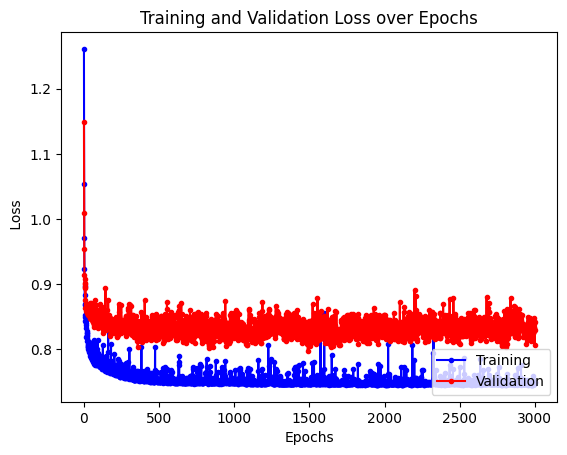

In [ ]:
# Generate the x-axis values (epochs)
ep = range(1, num_epochs+1)

# Plotting the Training graph
plt.plot(ep, train_losses, marker='.', linestyle='-', color='b')

# Plotting the Validation graph
plt.plot(ep, valid_losses, marker='.', linestyle='-', color='r')

# Set Graph parameters
plt.xlabel('Epochs')
plt.ylabel(' Loss')
plt.title('Training and Validation Loss over Epochs')

# Display the plot
plt.legend(["Training", "Validation"], loc ="lower right")
plt.show()